## Classification : Imbalanced Data
- Objective : 
    1. Classify yes class  along with their probability.

## 1.0 Constrains

### 1.1 Modeling Constraints : 
- Modeling Type : Classification    
- Model Explainaibility : 
    - 1. One Logistic Regression Model : Explainable Model
    - 2. Another Black Box Model : 
        
    
### 1.2 Data Constraint :
- Primary Data : 
    - Dependent / Outcome Variable :  y (0/1)
    - Independent / Predictor Variables :  100 Feature Variables (Categorical, numerical)
- Imbalanced Data :  


### 1.3 Evaluation Metrics Constraint:
- Imbalanced Data specific Evaluation Metrics
- General constraints i.e accuracy leads to improper evaluation / modeling & final choice.

### 1.4 Framework Constraint : 
- This constraint is self-selected based on ease of use and data size.
- Scikit-learn. 
    - Scikit-Learn : Given that the Data-size is comparatively small, scikit-learn  is selected as the framework, given its comparative ease  or use and faster Iteration possiblity.
- TensorFlow/ Keras : Complex Deep Neural Network  modeling and GPU support is provided by TensorFlow / Keras, and hence is used for more complex NN modeling.
- StatsModel :
    - Scikit-learn provides more varied models(Forest, Boosting, Bagging, SVM, NNs), powerful parameter customisation and control. However the LR model generated by them have few model and model parameter statistics compared to StatsModel (i.e p-value, 95% CI, marginal_effects ). Hence we will use StatsModel's LogisticRegression in the second part.



## 1. Data Load

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def load_data(path, delimiter=","):
    df = pd.read_csv(path, delimiter=delimiter)
    duplicateRows = df[df.duplicated()]

    print(f"\nLoading File : {path}")
    print(f" ...Rows: {len(df)}. Cols : {len(df.columns)}")
    if len(duplicateRows) > 0:
        print(f" ...WARNING: Duplicate Row Found. Total No of Duplicate Rows is  {len(duplicateRows)}")
        print(f"     ...Initiating Row Deduplication .....")
        df = df.drop_duplicates(keep="last")
        print(f"     ...Total No of unique rows is {len(df)}")

    return df


# customer propensity dataframe
train_df = load_data("Data/exercise_40_train.csv", delimiter=",")
test_df = load_data("Data/exercise_40_test.csv", delimiter=",")
train_df_orig = train_df.copy()
test_df_orig = test_df.copy()


# View Sample Data
train_df.head()



Loading File : Data/exercise_40_train.csv
 ...Rows: 40000. Cols : 101

Loading File : Data/exercise_40_test.csv
 ...Rows: 10000. Cols : 100


y        x1         x2        x3        x4        x5        x6        x7  \
0  0  0.165254  18.060003       Wed  1.077380 -1.339233 -1.584341   0.0062%   
1  1  2.441471  18.416307    Friday  1.482586  0.920817 -0.759931   0.0064%   
2  1  4.427278  19.188092  Thursday  0.145652  0.366093  0.709962   -8e-04%   
3  0  3.925235  19.901257   Tuesday  1.763602 -0.251926 -0.827461  -0.0057%   
4  0  2.868802  22.202473    Sunday  3.405119  0.083162  1.381504   0.0109%   

         x8        x9  ...       x91       x92  x93       x94       x95  \
0  0.220784  1.816481  ... -0.397427  0.909479   no  5.492487       NaN   
1  1.192441  3.513950  ...  0.656651  9.093466   no  3.346429  4.321172   
2  0.952323  0.782974  ...  2.059615  0.305170   no  4.456565       NaN   
3 -0.520756  1.825586  ...  0.899392  5.971782   no  4.100022  1.151085   
4 -0.732739  2.151990  ...  3.003595  1.046096  yes  3.234033  2.074927   

         x96        x97  x98  x99        x100  
0  10.255579   7.627730    0  yes  104.251338  
1        NaN  10.505284    1  yes  101.230645  
2   8.754572   7.810979    0  yes  109.345215  
3        NaN   9.178325    1  yes  103.021970  
4   9.987006  11.702664    0  yes   92.925935  

[5 rows x 101 columns]

## 2. Exploratory Data Analysis (EDA) :
Because there are large no of features, we will primairly use statistical tools for EDA and only use Visualisation  for secondary EDA.
- Statistical Tests : (Primarily)
- Visualisation Plots (Secondarily)


### 2.1 Class Label Distribution 
- Y label distribution across TrainTest Data
- Observation : Imbalanced Data 
    - Proper Loss Function / Evaluation methodologies to suit Imblanaced Data to be used.    
    - Evaluation method to be used : 
        - Not to use accuracy.
        - Use AUC, F1-Score, Roc curve, sensitivity, specificity

Train Data : % of True Class 14.5075 %


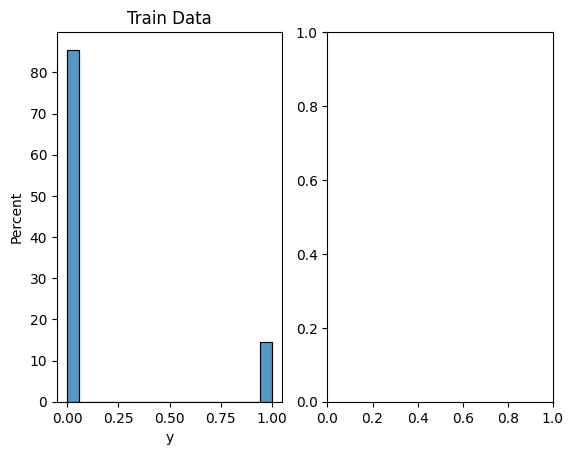

In [2]:
import warnings

warnings.filterwarnings("ignore")

fig, axs = plt.subplots(ncols=2)
sns.histplot(train_df["y"], stat="percent", ax=axs[0]).set(title="Train Data")


def get_y_percentage(train_df, data_type="Train"):
    print(f"{data_type} Data : % of True Class {len(train_df[train_df.y==1]) * 100.0/ len(train_df) } %")


get_y_percentage(train_df)


### 2.2 EDA : Univariate Analysis
#### 2.2.0 EDA Prep : Compile Column List by Type
- Identify Numerical / Categorical columns, so that further preprocessing can be done respectively
- Identify if some categorical columns are mislabelled due to Errors or lack of preprocessing e.g "$50.00"


In [3]:
def get_all_column_and_types(train_df):
    candidate_numeric_int_columns = list(train_df.select_dtypes(include=["int64"]).columns)
    candidate_numeric_float_columns = list(train_df.select_dtypes(include=["float64"]).columns)
    candidate_object_cols = list(train_df.select_dtypes(include=["object"]).columns)
    candidate_bool_cols = list(train_df.select_dtypes(include=["bool"]).columns)

    candidate_cols_n_type = {
        "int": candidate_numeric_int_columns,
        "float": candidate_numeric_float_columns,
        "object": candidate_object_cols,
        "bool": candidate_bool_cols,
    }
    return candidate_cols_n_type


candidate_cols_n_type = get_all_column_and_types(train_df)

candidate_numeric_int_columns = candidate_cols_n_type["int"]
candidate_numeric_float_columns = candidate_cols_n_type["float"]
candidate_object_cols = candidate_cols_n_type["object"]
candidate_bool_cols = candidate_cols_n_type["bool"]
print(f"candidate_numeric_int_columns    : {candidate_numeric_int_columns  }")
print(f"candidate_numeric_float_columns  : {candidate_numeric_float_columns}")
print(f"candidate_object_cols            : {candidate_object_cols          }")
print(f"candidate_bool_cols              : {candidate_bool_cols            }")


assert len(train_df.columns) == len(candidate_numeric_int_columns) + len(candidate_numeric_float_columns) + len(
    candidate_object_cols
) + len(candidate_bool_cols)


candidate_numeric_int_columns    : ['y', 'x59', 'x98']
candidate_numeric_float_columns  : ['x1', 'x2', 'x4', 'x5', 'x6', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x20', 'x21', 'x22', 'x23', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x32', 'x34', 'x35', 'x36', 'x37', 'x38', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'x47', 'x48', 'x49', 'x50', 'x51', 'x52', 'x53', 'x54', 'x55', 'x56', 'x57', 'x58', 'x61', 'x62', 'x63', 'x64', 'x66', 'x67', 'x68', 'x69', 'x70', 'x71', 'x72', 'x73', 'x74', 'x75', 'x76', 'x78', 'x79', 'x80', 'x81', 'x82', 'x83', 'x84', 'x85', 'x86', 'x87', 'x88', 'x89', 'x90', 'x91', 'x92', 'x94', 'x95', 'x96', 'x97', 'x100']
candidate_object_cols            : ['x3', 'x7', 'x19', 'x24', 'x31', 'x33', 'x39', 'x60', 'x65', 'x77', 'x93', 'x99']
candidate_bool_cols              : []


#### 2.2.1 EDA Univariate Analysis : Categorical Variables  
- Categorical Value Validity Check : OK
- Missing Value Check : 
- Candidate Categorical Variables Build:
    - Recategorise Pandas Int columns (with 0/1 values only) as Binary Categorical Variables
    - Inspect Pandas Object Columns for Categorical Variables reassignment possibility     


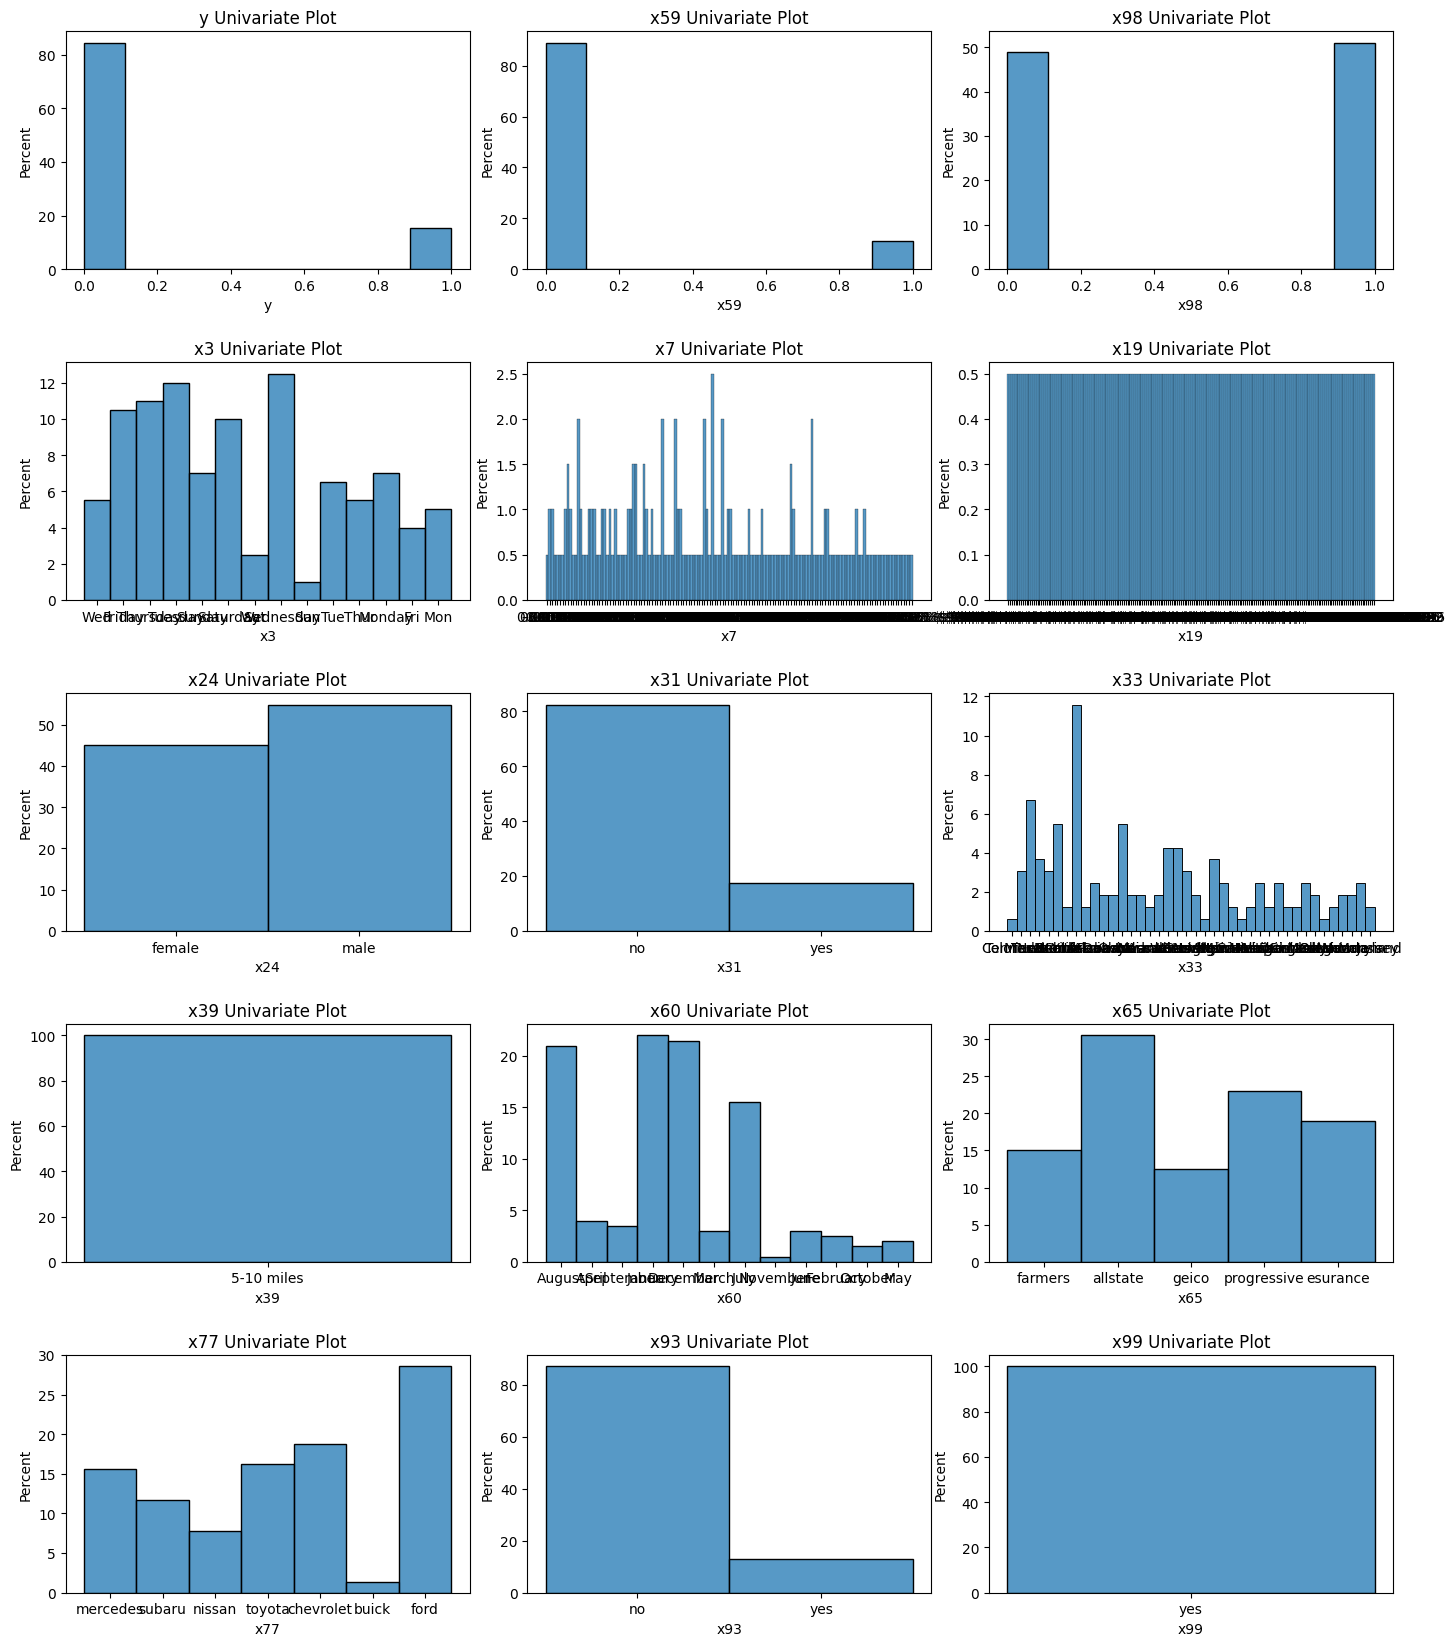

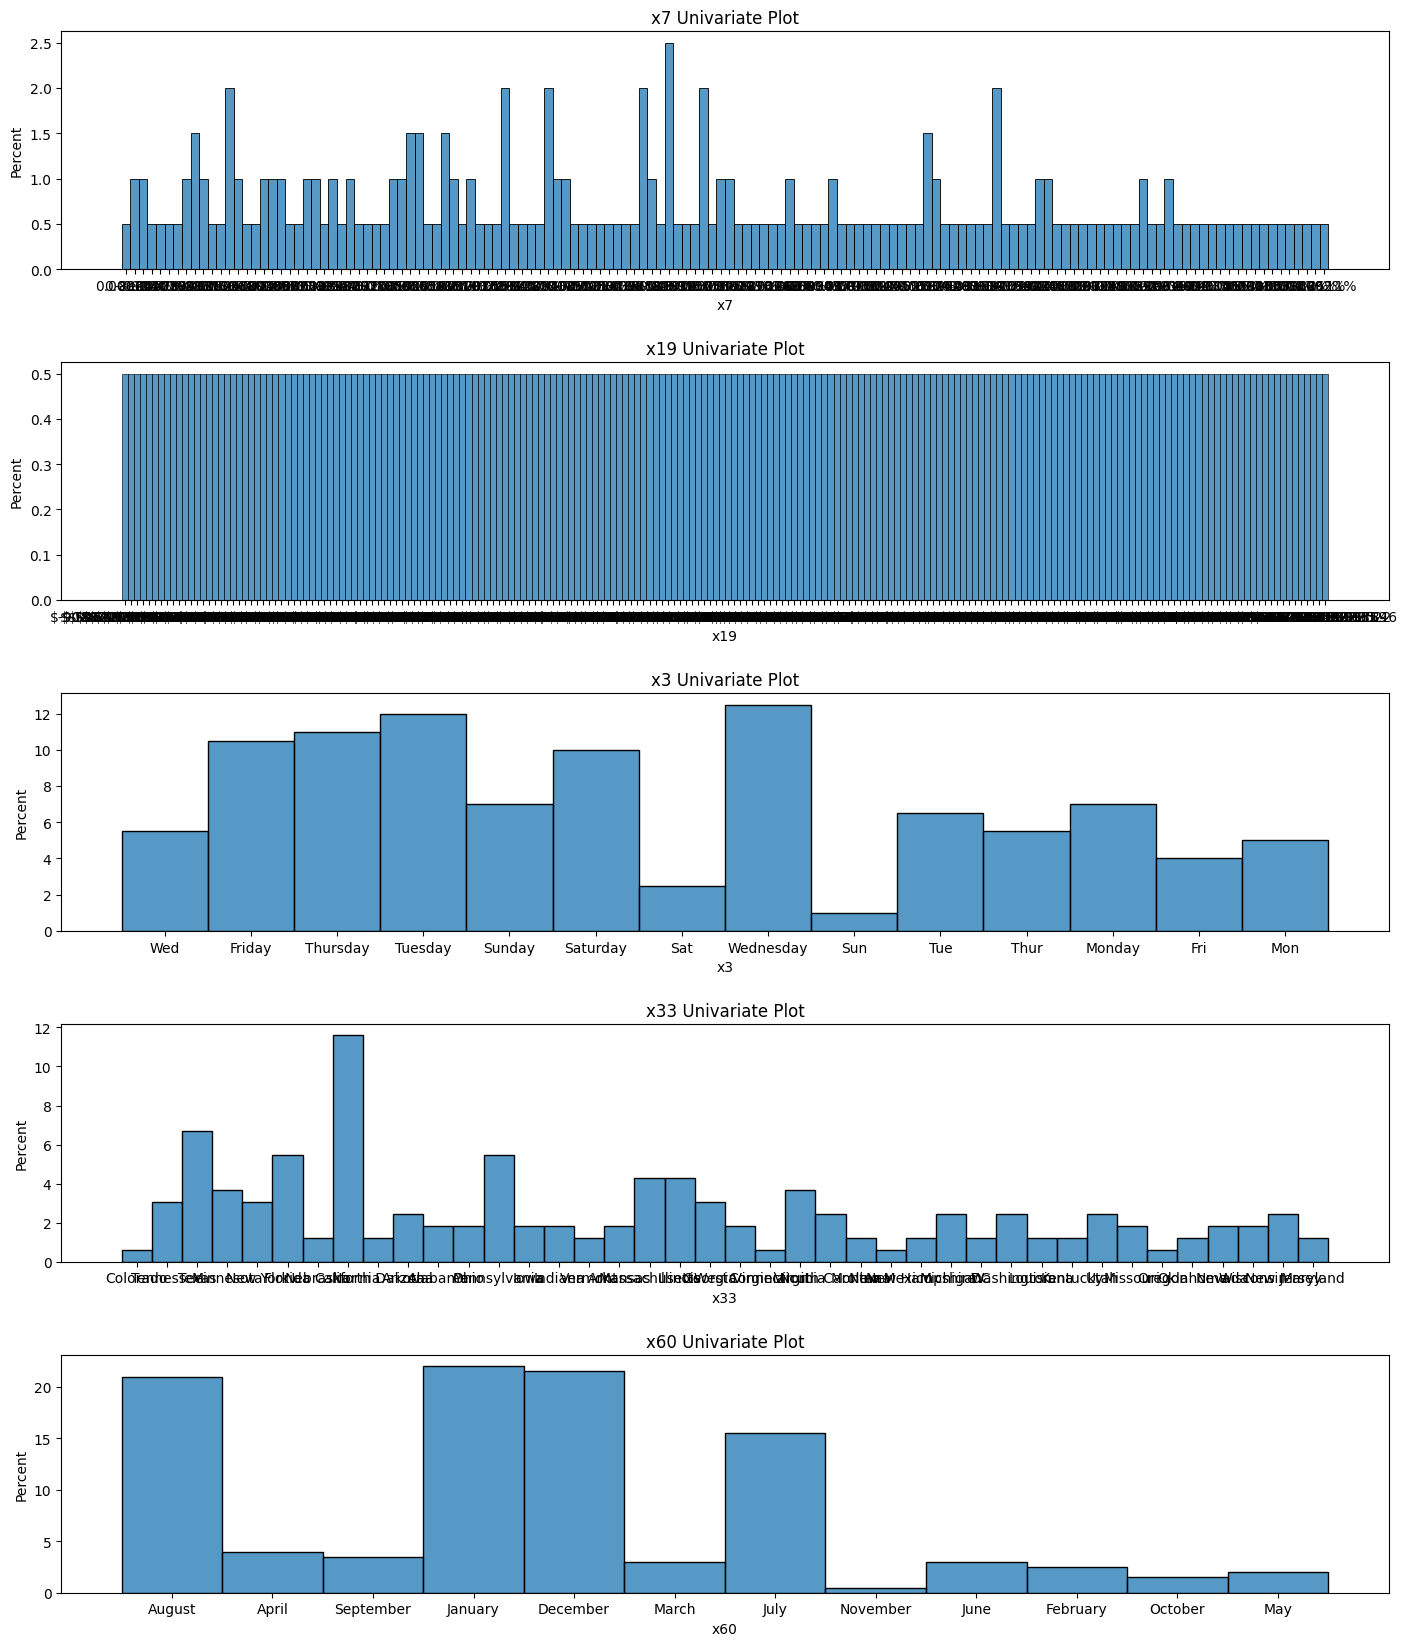

In [4]:
def univariate_plot_for_variables(
    df, categorical_columns, n_cols, figsize_x=5, figsize_y=6, top_in_betweeen_subplot_spacing=2.0, stat="percent"
):
    row_idx, col_idx = 0, 0
    n_rows = int(np.ceil(len(categorical_columns) / n_cols))
    fig, axs = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(figsize_x, figsize_y))
    fig.tight_layout()
    plt.subplots_adjust(top=top_in_betweeen_subplot_spacing)

    for i, col in enumerate(categorical_columns):        
        no_of_plots = i + 1
        if n_cols == 1:
            sns.histplot(df[col], stat=stat, ax=axs[row_idx]).set(title=col + " Univariate Plot")
        else:
            sns.histplot(df[col], stat=stat, ax=axs[row_idx][col_idx]).set(title=col + " Univariate Plot")
        col_idx += 1

        if no_of_plots % n_cols == 0:
            row_idx += 1
            col_idx = 0


univariate_plot_for_variables(
    train_df[0:200],
    candidate_numeric_int_columns + candidate_object_cols,
    n_cols=3,
    figsize_x=14,
    figsize_y=8,
    top_in_betweeen_subplot_spacing=2.0,
)

univariate_plot_for_variables(
    train_df[0:200],
    ['x7','x19', 'x3','x33', 'x60'],
    n_cols=1,
    figsize_x=14,
    figsize_y=8,
    top_in_betweeen_subplot_spacing=2.0,
)


#####  2.2.1.1 PreProcessing : Fix Data Errors: 
- Candidate Categorical Variables To Numerical
- Some columns have been interpreted by pandas as objects, while they are in-fact numerical variables. e.g $100.0 value would be treated as object because of \$. It in fact should be numerical variable.
- Observed Columns that required fix
    - Convert into numerical column
    - x7  - Remove % from x7 (0.0062%, 0.0064%)
    - x19 - Remove $ from x19 ($-908.65, $-1864.96)


In [5]:
orig_train_df = train_df.copy()
orig_test_df = test_df.copy()
train_df[['x3', 'x7', 'x19', 'x33', 'x60']].head()

x3        x7                 x19        x33        x60
0       Wed   0.0062%  $-908.650758424405   Colorado     August
1    Friday   0.0064%   $-1864.9622875143  Tennessee      April
2  Thursday   -8e-04%  $-543.187402955527      Texas  September
3   Tuesday  -0.0057%  $-182.626380634258  Minnesota  September
4    Sunday   0.0109%   $967.007090837503   New York    January

In [6]:
def fix_data_syntax_error(train_df):    
    train_df['x7'] = train_df['x7'].apply(lambda x : float(x.replace('%','')))
    train_df['x19'] = train_df['x19'].apply(lambda x : float(x.replace('$','')))
    return train_df

train_df, test_df = orig_train_df.copy(), orig_test_df.copy()
numerical_columns = candidate_numeric_float_columns + ['x7', 'x19']
categorical_cols_from_object_cols = candidate_object_cols.copy()
categorical_cols_from_object_cols.remove('x7')
categorical_cols_from_object_cols.remove('x19')
categorical_columns =  ['x59', 'x98'] + categorical_cols_from_object_cols

train_df = fix_data_syntax_error(train_df)
test_df = fix_data_syntax_error(test_df)
train_df[['x3', 'x7', 'x19', 'x33', 'x60']].head()





x3      x7          x19        x33        x60
0       Wed  0.0062  -908.650758   Colorado     August
1    Friday  0.0064 -1864.962288  Tennessee      April
2  Thursday -0.0008  -543.187403      Texas  September
3   Tuesday -0.0057  -182.626381  Minnesota  September
4    Sunday  0.0109   967.007091   New York    January

#### 2.2.1 EDA Univariate Analysis : Categorical Variables Continued
- Inspecting mult-valued categorical variables more

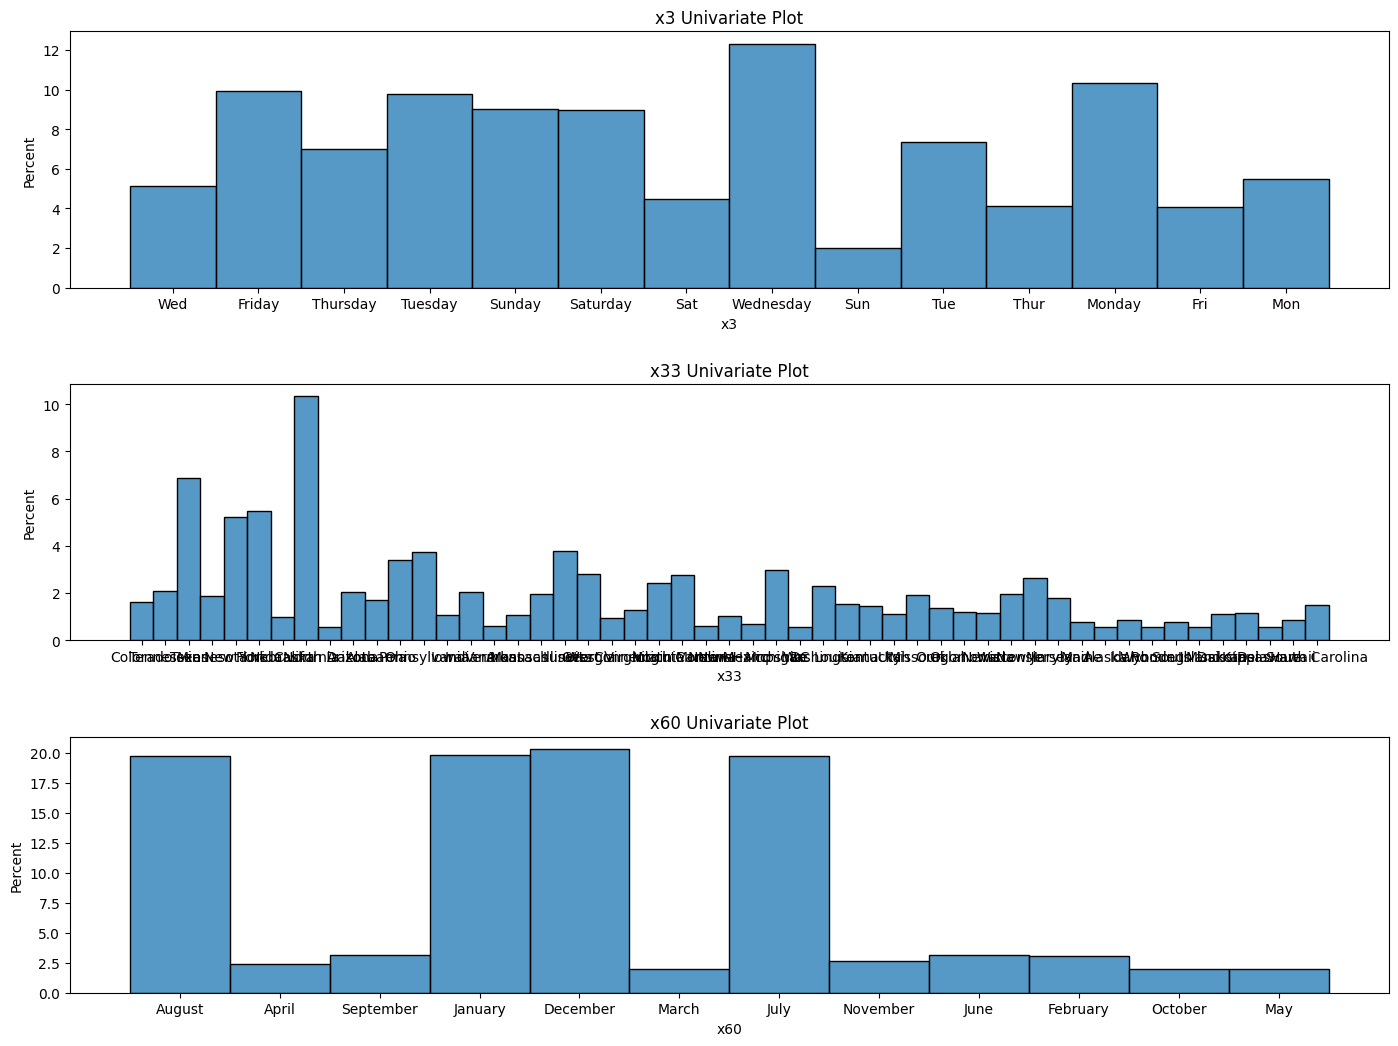

In [7]:
# univariate_plot_for_variables(train_df, categorical_columns,
#                               n_cols=3, figsize_x=14, figsize_y=8,
#                               top_in_betweeen_subplot_spacing=2.0)

univariate_plot_for_variables(train_df, ['x3','x33', 'x60'],
                              n_cols=1, figsize_x=14, figsize_y=5,
                              top_in_betweeen_subplot_spacing=2.0)

In [8]:
# Variable Type Identification
assert len(numerical_columns)+ len(categorical_columns)+1 ==len(train_df.columns) 



### 2.3 EDA Missing Values:

#### 2.3.1 EDA Missing Values: Categorical Variables

In [9]:
def get_missing_value_percentage(df, categorical_columns, show_missing_only=False):
    print("Missing Values %")
    missing_val_df = pd.DataFrame(columns=["column", "missing_value_percent"])
    total_rows = len(df)

    for col in categorical_columns:
        missing_value_df = df[(df[col] == "unknown") | (df[col].isnull() == True)]
        missing_value_percentage = round(len(missing_value_df) * 100.0 / total_rows, 2)
        missing_val_df = missing_val_df.append(
            {"column": col, "missing_value_percent": missing_value_percentage}, ignore_index=True
        )

    return missing_val_df.sort_values(by=["missing_value_percent"], ascending=False)


# get_missing_value_percentage(train_df, categorical_columns, show_missing_only=True)
miss_val_df = get_missing_value_percentage(train_df, categorical_columns, show_missing_only=False)
miss_val_df


Missing Values %


column  missing_value_percent
11    x99                  32.09
9     x77                  23.14
5     x33                  17.93
3     x24                   9.64
0     x59                   0.00
1     x98                   0.00
2      x3                   0.00
4     x31                   0.00
6     x39                   0.00
7     x60                   0.00
8     x65                   0.00
10    x93                   0.00

In [10]:
keep_variables =  miss_val_df[miss_val_df.missing_value_percent>=32]['column']

# list(miss_val_df[miss_val_df.missing_value_percent>=20]['column'])

##### 2.3.1.1 Proprocessing :  Fix Missing Value (Categorical)
- Options :
    - 1. Elimination : Record Elimintion or Variable Elimination
    - 2. Fill : Most Frequent Fill, Model Based Fill
    - 3. Special Indicator: e.g  missing_test means test was not required and has information with missing label
    - 4. Keep : Treat them as a class of their own
    - 5. Proportionate Fill. Fill missing values in the proportion they are represeted in the Data.

##### a No Missing Data
- Following Features have no missing data
- x59, x98, x3, x31, x39, x60, x65, x93


##### b. Eliminate Missing Data : 
- Why ?
    - Small enough records that they can be safely deleted. Does not reduce the data size significantly.
    - Given small amount, highly likely to be data errors in collection, entry, processing.
    - We want these error to not dilute or degrade prediction for ~98% of cases. Eliminating in favor of better modelling prediction.        -     
- What variables ?    
    - No Features small amount of missing values observed.

##### c. Keep : As Separate Class: 
- Why ?    
    - Because there are large enough no. of records
    - Discarding them leads to substantial loss of training data
    - It is also important to check if keeping them as separate class makes sense logically and/or from business point of view
    - Given the higher amount of missing records, the  missing value is likely to be not a Data error but most likely the reality / practicality of the real world. 
    - If we eliminate them, then we have to be  very careful to exclude those customer's prediction  because the model did not scope them in.  If we do not, then because of data drift in training vs real world, the prediction is highly likely to be inaccurate.
- What variables to Keep ?
    - X77 : Vehicle Brand (Nissand / Ford) :  ~23% Missing : Keep as separate class.
        - Keeping because a person may not drive a vehicle and in those cases this feature will not have any values and valid.
        - It is always best to confirm with business Domain Expert. We will assume valid for current case.
        

##### d. Fill :
-  Porportionate Fill :
    - X24 (10% Missing) : Proportionate Fill
    - X33 (18% Missing) : Proportionate Fill - coz belongs to some day (Sunday-Saturday)
    - X99 (32% Missing) : Remove Variable because this feature contains Static Value throughout (100% value is yes)
    


In [11]:
ckpt_train_df_pre_missing_val = train_df.copy()
ckpt_test_df_pre_missing_val = test_df.copy()


import numpy as np


def isNaN(num):
    return num != num


def fill_missing_values_with_proportionate_fill_random(df, col, percent_proportion=None):
    null_values = df[col].isnull().values
    unique_values, count_proportion = np.unique(df[col].values[~null_values], return_counts=1)
    percent_proportion = [p / count_proportion.sum() for p in count_proportion]
    print(unique_values, percent_proportion)
    df[col] = df[col].apply(lambda x: np.random.choice(unique_values, p=percent_proportion) if x is None else x)

    fill_proportion = {val: proportion for val, proportion in zip(unique_values, percent_proportion)}
    return df, fill_proportion


def get_missing_values_proportion(df, col):
    null_values = df[col].isnull().values
    unique_values, count_proportion = np.unique(df[col].values[~null_values], return_counts=1)
    percent_proportion = [round(p / count_proportion.sum(), 2) for p in count_proportion]
    # Edge case : If proportion does not sum upto 1, then use 4 decimal rounding and adjust last element
    if sum(percent_proportion) != 1:
        percent_proportion = [round(p / count_proportion.sum(), 3) for p in count_proportion]
        percent_proportion[-1] = 1 - sum(percent_proportion[:-1])

    print(f"\n{col}\n   ...", unique_values, percent_proportion)
    return (list(unique_values), list(percent_proportion))


def get_rows_drop_count(df, previous_no_of_rows):
    no_of_rows_dropped = previous_no_of_rows - len(df)
    percent_of_rows_dropped = round(no_of_rows_dropped * 100.0 / previous_no_of_rows, 2)
    print(f"\nNo. of rows dropped : {no_of_rows_dropped} ({percent_of_rows_dropped} %) ")


def preprocess_missing_data(
    df,
    eliminate_variables,
    remove_records_if_col_has_missing_values_4_variables,
    keep_missing_values_4_variables,
    fill_missing_values_proportionatately_variables,
    fill_missing_values_with_mean_variables,
    is_train_data=True,
    fill_proportion_for_test_data=None,
):
    previous_no_of_rows = len(df)
    fill_from_train_data = {}

    for col in eliminate_variables:
        # Remove rows containing missing values
        print(f" ... Removing Column Variable {col}")
        df = df.drop(col, axis=1)

    for col in remove_records_if_col_has_missing_values_4_variables:
        # Remove rows containing missing values
        print(f" ... Removing Rows containing missing values for Column Variable {col}")
        df = df.dropna(axis=0, how="any", subset=[col])

    for col in keep_missing_values_4_variables:
        # Keep as missing_class
        print(f" ... Keeping Missing Values for Column Variable {col}")
        df[col].fillna("missing", inplace=True)

    for col in fill_missing_values_with_mean_variables:
        # Mean Fill variables
        if is_train_data:
            cur_col_mean_val = round(df[col].mean(), 2)
            fill_from_train_data[col] = cur_col_mean_val
        else:
            cur_col_mean_val = fill_proportion_for_test_data[col]

        print(f" ... Mean Filling Missing Values for Column Variable {col} : {cur_col_mean_val}")
        df[col].fillna(cur_col_mean_val, inplace=True)

    for col in fill_missing_values_proportionatately_variables:
        # Replace :  Proportionate Replacement
        print(f" ... Proportionately Filling Missing Values for Column Variable {col}")
        if fill_proportion_for_test_data is not None:
            cur_fill_val = fill_proportion_for_test_data[col]["fill_val"]
            cur_fill_proportion = fill_proportion_for_test_data[col]["fill_proportion"]
        else:
            cur_fill_val, cur_fill_proportion = get_missing_values_proportion(df, col)
            fill_from_train_data[col] = {"fill_val": cur_fill_val, "fill_proportion": cur_fill_proportion}
        print(f"    {cur_fill_val}")
        print(f"    {cur_fill_proportion}")
        df[col] = df[col].apply(
            lambda x: np.random.choice(cur_fill_val, p=cur_fill_proportion) if x is None or isNaN(x) else x
        )

    get_rows_drop_count(df, previous_no_of_rows)
    return df, fill_from_train_data


categorical_variables_to_mode_fill_if_has_missing_values = []
categorical_variables_to_model_fill_if_has_missing_values = []
categorical_variables_to_eliminate_record_if_has_missing_values = []

eliminate_variables = ["x99"]
if "x99" in categorical_columns:
    categorical_columns.remove("x99")
fill_missing_values_proportionatately_variables = ["x24", "x33"]
fill_missing_values_with_mean_variables = []
keep_missing_values_4_variables = ["x77"]


train_df = ckpt_train_df_pre_missing_val.copy()
test_df = ckpt_test_df_pre_missing_val.copy()
train_df, fill_proportion_from_train_data = preprocess_missing_data(
    train_df,
    eliminate_variables,
    categorical_variables_to_eliminate_record_if_has_missing_values,
    keep_missing_values_4_variables,
    fill_missing_values_proportionatately_variables,
    fill_missing_values_with_mean_variables,
    is_train_data=True,
)
test_df, _ = preprocess_missing_data(
    test_df,
    eliminate_variables,
    categorical_variables_to_eliminate_record_if_has_missing_values,
    keep_missing_values_4_variables,
    fill_missing_values_proportionatately_variables,
    fill_missing_values_with_mean_variables,
    is_train_data=False,
    fill_proportion_for_test_data=fill_proportion_from_train_data,
)

get_y_percentage(train_df_orig, "Train Data Pre Missing value Drop")
get_y_percentage(train_df)


# Verification
assert train_df[categorical_columns].isnull().sum().sum() == 0, "ERROR : Missing Data still exists"
assert test_df[categorical_columns].isnull().sum().sum() == 0, "ERROR : Missing Data still exists in Test Data"


 ... Removing Column Variable x99
 ... Keeping Missing Values for Column Variable x77
 ... Proportionately Filling Missing Values for Column Variable x24

x24
   ... ['female' 'male'] [0.5, 0.5]
    ['female', 'male']
    [0.5, 0.5]
 ... Proportionately Filling Missing Values for Column Variable x33

x33
   ... ['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'DC' 'Delaware' 'Florida' 'Georgia' 'Hawaii' 'Idaho'
 'Illinois' 'Indiana' 'Iowa' 'Kansas' 'Kentucky' 'Louisiana' 'Maine'
 'Maryland' 'Massachusetts' 'Michigan' 'Minnesota' 'Mississippi'
 'Missouri' 'Montana' 'Nebraska' 'Nevada' 'New Hampshire' 'New Jersey'
 'New Mexico' 'New York' 'North Carolina' 'North Dakota' 'Ohio' 'Oklahoma'
 'Oregon' 'Pennsylvania' 'Rhode Island' 'South Carolina' 'South Dakota'
 'Tennessee' 'Texas' 'Utah' 'Vermont' 'Virginia' 'Washington'
 'West Virginia' 'Wisconsin' 'Wyoming'] [0.017, 0.005, 0.02, 0.011, 0.103, 0.016, 0.013, 0.006, 0.005, 0.055, 0.028, 0.009, 0.008, 0.038, 0.

#### 2.3.2 EDA - Bivariate Plot (Categorical Variables)


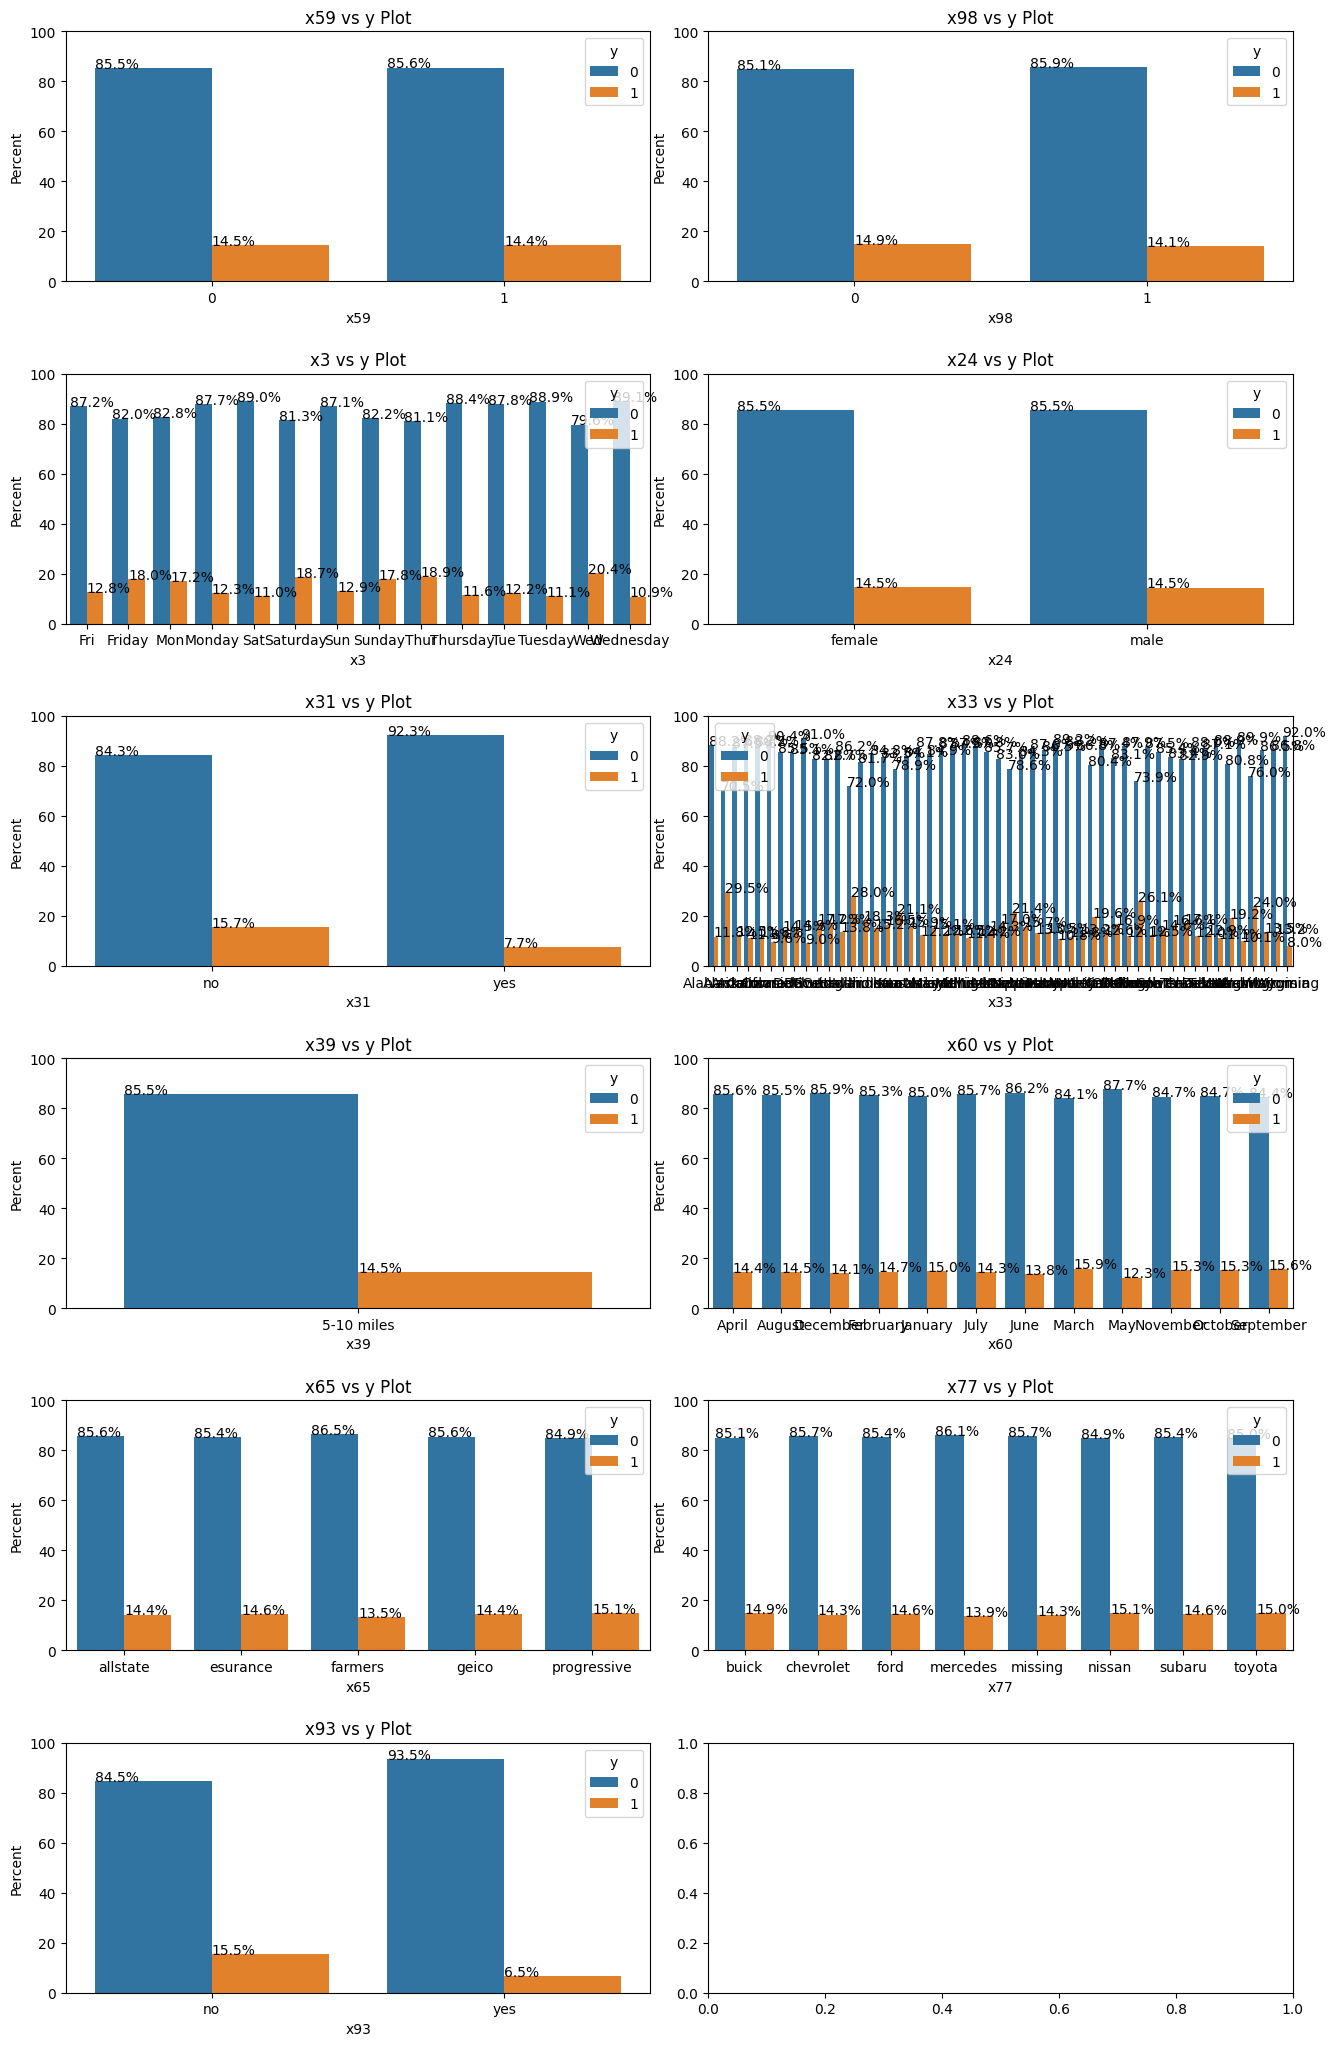

In [12]:
def bivariate_plot_for_categorical_variables(
    df,
    categorical_columns,
    outcome_variable,
    n_cols,
    figsize_x=5,
    figsize_y=6,
    top_in_betweeen_subplot_spacing=2.0,
    order=None,
):
    if outcome_variable in categorical_columns:
        categorical_columns.remove(outcome_variable)

    row_idx, col_idx = 0, 0
    n_rows = int(np.ceil(len(categorical_columns) / n_cols))
    # print(f' n_rows {n_rows} n_cols {n_cols}')
    fig, axs = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(figsize_x, figsize_y))
    fig.tight_layout()
    plt.subplots_adjust(top=top_in_betweeen_subplot_spacing)

    for i, col in enumerate(categorical_columns):
        no_of_plots = i + 1
        # print(row_idx, col_idx, no_of_plots, col)
        cur_row_col_axes = axs[row_idx] if n_cols == 1 else axs[row_idx][col_idx]

        feature, target = col, outcome_variable
        new_df = df[[feature, target]].copy()
        new_df = new_df.groupby(feature)[target].value_counts(normalize=True)
        new_df = new_df.mul(100).rename("Percent").reset_index()
        new_df
        if order and col in order.keys():
            g = sns.barplot(x=feature, y="Percent", hue=target, data=new_df, ax=cur_row_col_axes, order=order[col])
        else:
            g = sns.barplot(x=feature, y="Percent", hue=target, data=new_df, ax=cur_row_col_axes)
        g.set(title=f"{col} vs {outcome_variable} Plot")
        g.set_ylim(0, 100)

        for p in g.patches:
            txt = str(p.get_height().round(1)) + "%"
            txt_x = p.get_x()
            txt_y = p.get_height()
            g.text(txt_x, txt_y, txt)

        # sns.catplot(data=train_df, y=col, x=outcome_variable, kind='strip', ax=cur_row_col_axes).set(title=col+" Bivariate Plot")
        # sns.countplot(hue=outcome_variable, y=col,  data=train_df,  ax=cur_row_col_axes).set(title=col+" Bivariate Plot")
        # dex.count("month", split="y", data=train_df, normalize='month',
        # stacked=True,  title='month vs y', split_order=['yes', 'no'], ax=cur_row_col_axes)
        # sns.stripplot(data=train_df, y=col, x=outcome_variable,  ax=cur_row_col_axes).set(title=col+" Bivariate Plot")
        col_idx += 1

        if no_of_plots % n_cols == 0:
            row_idx += 1
            col_idx = 0


bivariate_plot_for_categorical_variables(
    train_df, categorical_columns, "y", n_cols=2, figsize_x=13, figsize_y=10, top_in_betweeen_subplot_spacing=2.0
)


#### 2.3.3 EDA Missing Values: Numerical Variables
- We will analyse numerical variables for the presence of missing data and then deal with them afterwards

##### 2.3.3.1 Fix Missing Values: Numerical Variables
- Of  the various options available i.e Eliminate, Keep, Fill e.t.c as discussed above, we choose the following options
- Eliminate : 
    - We will eliminate a column if > 40% values are missing.
    - Feature Variables : x44(85%) , x55(81%), x30(81%), x55(45%), x52(40%)
- Fill :
    - Out of various fill methods available i.e mean, median, mode or Model based fill, we will use median fill because our data contains outliers and we want to not 
    - 



In [13]:
import dtale
numerical_missing_val_df = get_missing_value_percentage(train_df, numerical_columns)
dtale.show(numerical_missing_val_df)

# train_df[]

Missing Values %


columns_with_missing_value_percent_between_0_and_40 : ['x74', 'x49', 'x54', 'x95', 'x78', 'x16', 'x89', 'x14', 'x42', 'x85', 'x41', 'x45', 'x61', 'x96', 'x91', 'x80', 'x76', 'x75', 'x11', 'x64', 'x92', 'x26', 'x79', 'x5', 'x83', 'x67', 'x63', 'x86', 'x38', 'x22', 'x68', 'x94', 'x88']


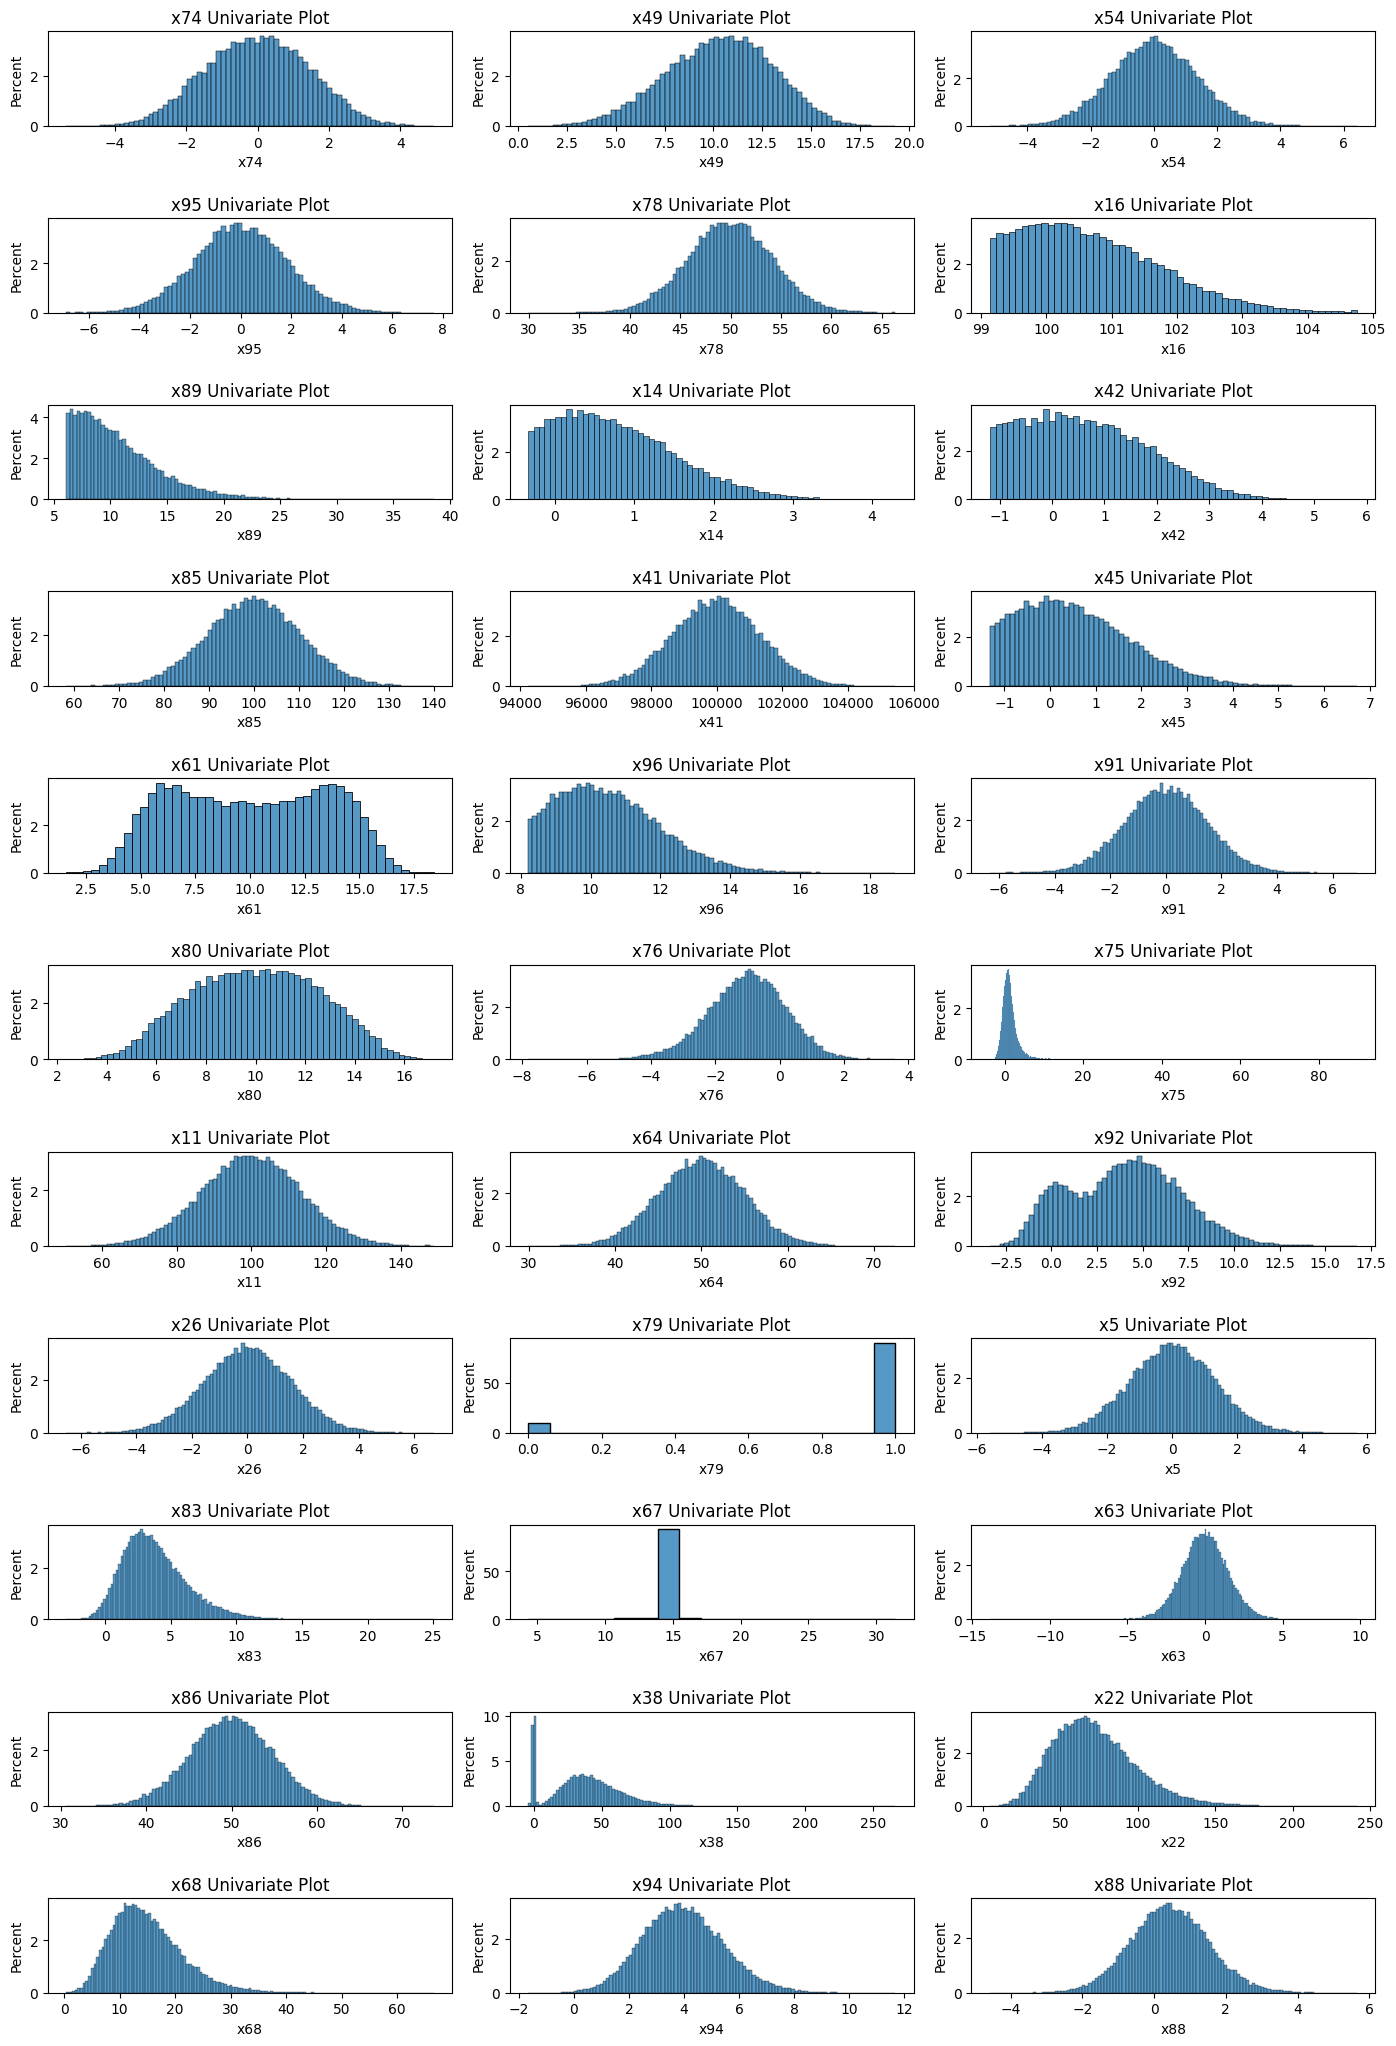

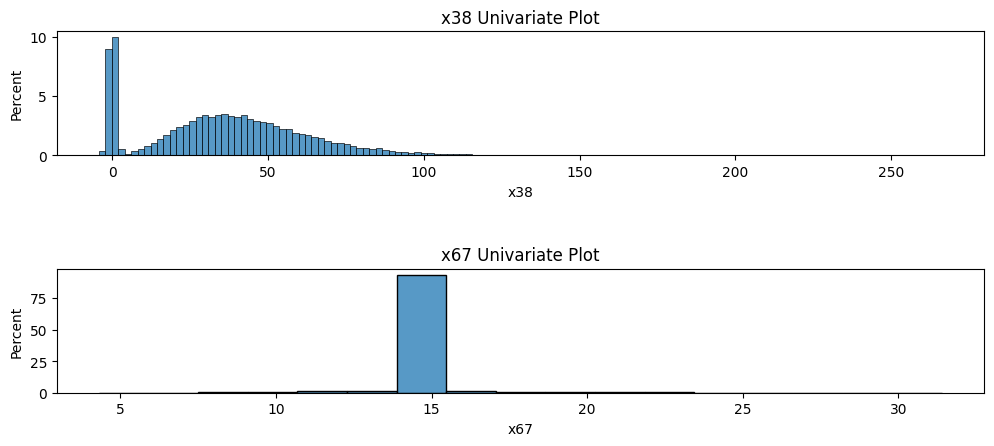

In [14]:
columns_with_missing_value_percent_between_0_and_40 = list(numerical_missing_val_df[(numerical_missing_val_df.missing_value_percent <40) 
                         & (numerical_missing_val_df.missing_value_percent > 0)]['column'])
print(f"columns_with_missing_value_percent_between_0_and_40 : {columns_with_missing_value_percent_between_0_and_40}")
univariate_plot_for_variables(train_df, columns_with_missing_value_percent_between_0_and_40,
                              n_cols=3, figsize_x=14, figsize_y=10,
                              top_in_betweeen_subplot_spacing=2.0)
univariate_plot_for_variables(train_df, ['x38', 'x67'],
                              n_cols=1, figsize_x=10, figsize_y=2,
                              top_in_betweeen_subplot_spacing=2.0)

##### 2.3.3.1 Fix Missing Values: Numerical Variables Contd.
We will handle mising values for numerical variableas as follows
- Eliminate Variables : 
    - Variables : ['x44', 'x57', 'x30']
    - Why? : because they have more than 80% of their data missing.
- Mode Fill / Proportionate Fill :
    - Variables : x79.
    -  We will do proportionate fill for X79. Mode Fill is also a good option. We should be careful not to mean fill x79 and  such binary variables mean fill will wrongly transform it into a continous variable by filling Invalid binary values i.e 0.8,0.9 instead of valid values 0 or 1.
- Mean Fill :
    - Variables: All other  variables we will mean fill
- Future ToDos : Model Based Fill

##### Interesting EDA observation:
- x38 : Has a  strange data distribution with 15% each values at 0 & 1 and normal distribution  for rest. These 0 and 1 values may represent some special indications, which would be nice to investigate / confirm with domain expert. Currently we will keep it as is, because we do not know what the variable represents to make meaningful reasoning.

In [15]:
ckpt_train_df_pre_missing_val_numeric = train_df.copy()
ckpt_test__df_pre_missing_val_numeric = test_df.copy()

In [16]:
def get_missing_value_resolution_recommendation(miss_val_df, eliminate_threhold_percentage=80):
    missing_value_resolution = {
        "eliminate_variables": list(
            miss_val_df[miss_val_df.missing_value_percent >= eliminate_threhold_percentage]["column"]
        ),
        "inspect_variables": list(
            miss_val_df[miss_val_df.missing_value_percent < eliminate_threhold_percentage]["column"]
        ),
    }
    return missing_value_resolution


numeric_miss_val_recommendation = get_missing_value_resolution_recommendation(numerical_missing_val_df, 33)

fill_missing_values_with_mean_variables = numeric_miss_val_recommendation["inspect_variables"]
if "x79" in fill_missing_values_with_mean_variables:
    fill_missing_values_with_mean_variables.remove("x79")

print(
    f"... Remove Variables because they contain >33% missing values : {numeric_miss_val_recommendation['eliminate_variables']}  "
)
print(f"... Mean Fill Variables are : {fill_missing_values_with_mean_variables}")


... Remove Variables because they contain >33% missing values : ['x44', 'x57', 'x30', 'x55', 'x52']  
... Mean Fill Variables are : ['x74', 'x49', 'x54', 'x95', 'x78', 'x16', 'x89', 'x14', 'x42', 'x85', 'x41', 'x45', 'x61', 'x96', 'x91', 'x80', 'x76', 'x75', 'x11', 'x64', 'x92', 'x26', 'x5', 'x83', 'x67', 'x63', 'x86', 'x38', 'x22', 'x68', 'x94', 'x88', 'x90', 'x73', 'x72', 'x71', 'x97', 'x70', 'x69', 'x82', 'x100', 'x84', 'x66', 'x7', 'x87', 'x81', 'x1', 'x62', 'x15', 'x25', 'x23', 'x21', 'x20', 'x18', 'x17', 'x13', 'x28', 'x12', 'x10', 'x9', 'x8', 'x6', 'x4', 'x27', 'x29', 'x58', 'x47', 'x56', 'x53', 'x2', 'x51', 'x50', 'x48', 'x46', 'x32', 'x43', 'x40', 'x37', 'x36', 'x35', 'x34', 'x19']


In [17]:
eliminate_variables = numeric_miss_val_recommendation['eliminate_variables']
for x in numerical_columns:
    if x in eliminate_variables:
        numerical_columns.remove(x)
fill_missing_values_proportionatately_variables = ['x79']
keep_missing_values_4_variables = []
numerical_variables_to_eliminate_record_if_has_missing_values = []

train_df = ckpt_train_df_pre_missing_val_numeric.copy()
test_df = ckpt_test__df_pre_missing_val_numeric.copy()

train_df, fill_proportion_numeric_vars_from_train_data = preprocess_missing_data(train_df,
                                  eliminate_variables,
                                  numerical_variables_to_eliminate_record_if_has_missing_values,
                                  keep_missing_values_4_variables,
                                  fill_missing_values_proportionatately_variables,
                                  fill_missing_values_with_mean_variables,
                                  is_train_data=True                                  
                                   )
print('test_df.columns')
print(fill_proportion_numeric_vars_from_train_data )
test_df, _ = preprocess_missing_data(test_df,
                                  eliminate_variables,
                                  numerical_variables_to_eliminate_record_if_has_missing_values,
                                  keep_missing_values_4_variables,
                                  fill_missing_values_proportionatately_variables,
                                  fill_missing_values_with_mean_variables,
                                  is_train_data=False,
                                  fill_proportion_for_test_data=fill_proportion_numeric_vars_from_train_data                                   
                                   )

get_y_percentage(train_df_orig, 'Train Data Pre Missing value Drop')
get_y_percentage(train_df)

# Verification
assert train_df.isnull().sum().sum() == 0, "ERROR : Missing Data still exists"
assert test_df.isnull().sum().sum() == 0, "ERROR : Missing Data still exists in Test Data"


 ... Removing Column Variable x44
 ... Removing Column Variable x57
 ... Removing Column Variable x30
 ... Removing Column Variable x55
 ... Removing Column Variable x52
 ... Mean Filling Missing Values for Column Variable x74 : -0.0
 ... Mean Filling Missing Values for Column Variable x49 : 10.3
 ... Mean Filling Missing Values for Column Variable x54 : 0.0
 ... Mean Filling Missing Values for Column Variable x95 : 0.03
 ... Mean Filling Missing Values for Column Variable x78 : 49.93
 ... Mean Filling Missing Values for Column Variable x16 : 100.7
 ... Mean Filling Missing Values for Column Variable x89 : 10.77
 ... Mean Filling Missing Values for Column Variable x14 : 0.79
 ... Mean Filling Missing Values for Column Variable x42 : 0.65
 ... Mean Filling Missing Values for Column Variable x85 : 99.99
 ... Mean Filling Missing Values for Column Variable x41 : 99994.12
 ... Mean Filling Missing Values for Column Variable x45 : 0.56
 ... Mean Filling Missing Values for Column Variable x6

### 2.4 EDA : Inadequate Variable Values
- Some values of the columns have very few values ranging from  0.01 to 0.04%. Hence we will remove those values from the categorical columns ltogether, because the data size for those values are too few to make reasonable judgement.


In [18]:
def get_too_few_values(df, min_percent=1):
    min_count = int(min_percent * len(df) / 100.0)
    print("Too Few Values EDA\n")
    for col in list(df.columns):
        if df[col].dtype in [int, float] or \
                df[col].value_counts().loc[lambda x: x < min_count].reset_index()[col].sum() <= 0:
            continue

        print(f"\n{col}")
        small_values_df = df[col].value_counts(
        ).loc[lambda x: x < min_count].reset_index()
        small_values_df['percent'] = small_values_df[col].apply(
            lambda x: str(round(x*100.0/len(df), 2))+'%')
        print(small_values_df)


get_too_few_values(train_df, min_percent=2)

Too Few Values EDA


x3
  index   x3 percent
0   Sun  798    2.0%

x33
             index  x33 percent
0    Massachusetts  773   1.93%
1        Minnesota  771   1.93%
2        Wisconsin  770   1.93%
3         Missouri  763   1.91%
4         Maryland  720    1.8%
5         Colorado  664   1.66%
6          Alabama  663   1.66%
7        Louisiana  613   1.53%
8         Kentucky  604   1.51%
9   South Carolina  585   1.46%
10          Oregon  555   1.39%
11     Connecticut  502   1.25%
12        Oklahoma  488   1.22%
13          Kansas  464   1.16%
14          Nevada  454   1.14%
15            Utah  442    1.1%
16     Mississippi  428   1.07%
17        Arkansas  425   1.06%
18            Iowa  423   1.06%
19      New Mexico  400    1.0%
20        Nebraska  381   0.95%
21   West Virginia  371   0.93%
22          Hawaii  341   0.85%
23           Idaho  332   0.83%
24    Rhode Island  302   0.76%
25           Maine  291   0.73%
26   New Hampshire  289   0.72%
27         Vermont  245   0.61%
2

#### 2.4.1 Inadequate Variable Values : Fix
We will handle inadequate vaiables values as follows
- Sun : We will normalise it to Sunday. 
- State / Month : 
    - We have few data posints for the month of May, October and states. Excluding them is not a good option for now, as we do not want our model to be not able to make predictions for those valid ranges.
    - Hence, we should try to encrich the dataset by adding more values of these values, if possible. If not, then we should be careful and cautious when making predictions for these  months and states.

### 2.5 EDA : Outliers
- Because we have large number of varaibles we will  primarily use statistical methods for Outlier Detection instead of EDA and visualisation approach as primary one for detecting them.
- Generally outlier causes issues with modeling down the pipeline with harder convergence for some models i.e Logistic Regression, Linear Regression which are  especially sensitive to  outliers. Hence we will fix them here.
- Possible solutions are
    - Replacement :
        - Clipping (Flooring or Capping)
        - Fill (Median / Mean/ Model) 
    - Rejection: Remove Data containing outliers
    - Accept:  Accept as separate unique class
        - Leave as-is
        - Treat as separate class
    - Transform : 
        - Log Transformation
        - Binning

In [20]:
def get_outlier_count_via_tukey_method(df):
    total_rows = len(df)
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1

    outlier_count_df = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum().sort_values(ascending=False)
    outlier_count_df = pd.DataFrame(outlier_count_df, columns=["outlier_count"])
    outlier_count_df["%"] = outlier_count_df["outlier_count"].apply(
        lambda x: str(round(x * 100.0 / total_rows, 2)) + "%"
    )
    return outlier_count_df


outlier_df = get_outlier_count_via_tukey_method(train_df[numerical_columns])
dtale.show(outlier_df)


#### 2.5.1 Preprocessing: Outliers (Fix) : Preservation
- Preserving : 
    - We will preserving outlier because the classification itself has ~14% yes class i.e. relatively an outlier phenomenon. Hence the outliers can in fact be signal rather than noise itself.
    - To Do in future : Other option, will be to do Model Comparision with / without outlier removal and compare them.
- Variables to Keep:    
- Variables to modify :    

In [22]:
def clip_to_max_nth_percentile(df, columns, nth):
    for column in columns:
        nth_percentile = np.percentile(df[column], nth)
        print(f"Clipping column {column} to {nth_percentile}")
        df[column] = df[column].apply(lambda x: nth_percentile if x > nth_percentile else x)        
    return df


def clip_to_n_sd_away(df, column, n_sd_away):
    mean = np.mean(df[column])
    std = np.std(df[column])

    lower_bound, upper_bound = mean - n_sd_away * std, mean + n_sd_away * std
    df[column] = df[column].apply(lambda x: lower_bound if x < lower_bound else x)
    df[column] = df[column].apply(lambda x: upper_bound if x > upper_bound else x)
    print(f"Clipped to [{lower_bound}, {upper_bound}] ")
    return df


ckpt_train_df_pre_outlier = train_df.copy()
ckpt_test_df_pre_outlier = test_df.copy()

## 3 PreProcessing 

### 3.0 Normalisation (Categorical Variables)
- We will Normalise duplicate values i.e Sunday, Sun into standard value
- Variables : 
    - x3 has duplicate categorical values. We will normalise it.




In [25]:
def get_col_values_to_check_for_normalisation_sorted(df, columns):
    for col in columns:
        normalise_values = []
        normalise_values = [x if x == x else "a" for x in list(train_df[col].unique())]
        normalise_values.sort()
        print(f"\n...\n{col} values {normalise_values}")


get_col_values_to_check_for_normalisation_sorted(train_df, ["x3", "x60", "x33"])



...
x3 values ['Fri', 'Mon', 'Sat', 'Sun', 'Thur', 'Tue', 'Wed']

...
x60 values ['April', 'August', 'December', 'February', 'January', 'July', 'June', 'March', 'May', 'November', 'October', 'September']

...
x33 values ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'DC', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']


In [24]:
def normalise_categorical_variables(df, mapping=None):
    for col, value_mapping in mapping.items():
        df[col] = df[col].apply(lambda x: value_mapping.get(x, x))
    return df


mapping_4_categorical_variables_normalisation = {
    "x3": {
        "Friday": "Fri",
        "Monday": "Mon",
        "Saturday": "Sat",
        "Sunday": "Sun",
        "Thursday": "Thur",
        "Tuesday": "Tue",
        "Wednesday": "Wed",
    }
}

train_df = normalise_categorical_variables(train_df, mapping_4_categorical_variables_normalisation)
test_df = normalise_categorical_variables(test_df, mapping_4_categorical_variables_normalisation)

get_col_values_to_check_for_normalisation_sorted(train_df, ["x3"])



...
x3 values ['Fri', 'Mon', 'Sat', 'Sun', 'Thur', 'Tue', 'Wed']


### 3.1 Invalid Data : 
- Done  in earlier Steps
- Data Range Check:  
    - x39 : 100% value is static
- Irrelevant Feature Check : EDA  does not show presence of easily identifiable irrelevant features.
- Any other Data Errors identified from EDA.

### 3.2 Missing Values:
-  Done  in earlier Steps after respective EDA

### 3.3 Categorical Data Encoding:
We will do the following encoding for the following categorical variables
- x39 : Although candidate for one-hot encoding, it contains  constant value throughout, hence we will drop the variable.
- One-hot Dummy encoding :
    - X3 , x60, x65, x77
- Binary Encoding :
    -  Variables: x24(male/female), x31(yes/no), x93(yes/no) ,(Already 0/1 - x59, x98) 
- Ordinal Transformation: Not done for this iteration

In [26]:
## Static Value
train_df.drop(columns=['x39'], inplace=True)
test_df.drop(columns=['x39'], inplace=True)

ckpt_train_df_pre_categorical_encoding = train_df.copy()
ckpt_test_df_pre_categorical_encoding = test_df.copy()

In [27]:
def encode_binary_variables(df, columns, mapping=None):
    binary_encode_mapping = {}

    for col in columns:
        # {'yes': 1, 'no':0}
        cur_col_val_2_binary = {}
        if col not in mapping.keys():
            for i, val in enumerate(list(df[col].unique())):
                cur_col_val_2_binary[val] = i
        else:
            cur_col_val_2_binary = mapping[col]

        if len(cur_col_val_2_binary.keys()) > 2:
            print(
                f'ERROR : {col} could not be binary encoded, because it contains more than two values {",".join(cur_unique_values)}'
            )
            continue

        binary_encode_mapping.update({col: cur_col_val_2_binary})
        df[col] = df[col].apply(lambda x: cur_col_val_2_binary[x])

    return df, binary_encode_mapping


def encode_categorical_variables(
    df,
    categorical_columns_to_dummy_variable_encode,
    categorical_variables_to_binary_encode,
    binary_encoding_mapping_dict={},
    label_binary_encode_map=None,
):
    ## Dummy variables transformation
    print(f"... Dummy Encoding for {categorical_columns_to_dummy_variable_encode}")
    df = pd.get_dummies(df, columns=categorical_columns_to_dummy_variable_encode)
    df.columns

    ## Binary Encoder    
    df, binary_encode_map = encode_binary_variables(
        df, categorical_variables_to_binary_encode, binary_encoding_mapping_dict
    )
    print(f"Binary Encoding mapping used is : {binary_encode_map}")

    # Binary Encode Labels For y
    if label_binary_encode_map is not None:
        df, binary_encode_map_y = encode_binary_variables(df, ["y"], label_binary_encode_map)
        print(f"Binary Encoding mapping used is : {binary_encode_map_y}")    

    return df, binary_encode_map


train_df = ckpt_train_df_pre_categorical_encoding.copy()
test_df = ckpt_test_df_pre_categorical_encoding.copy()
categorical_columns_to_dummy_variable_encode = ["x3", "x60", "x65", "x77", "x33"]
# x24(male/female), x31(yes/no), x93(yes/no) ,(Already 0/1 - x59, x98)
categorical_variables_to_binary_encode = ["x24", "x31", "x93"]

# train_binary_encode_map = {'pdays':{0:0, 1:1}}
train_df, binary_encode_map_for_test_data = encode_categorical_variables(
    train_df,
    categorical_columns_to_dummy_variable_encode,
    categorical_variables_to_binary_encode,
)
test_df, _ = encode_categorical_variables(
    test_df,
    categorical_columns_to_dummy_variable_encode,
    categorical_variables_to_binary_encode,
    binary_encode_map_for_test_data,
)


... Dummy Encoding for ['x3', 'x60', 'x65', 'x77', 'x33']
Binary Encoding mapping used is : {'x24': {'female': 0, 'male': 1}, 'x31': {'no': 0, 'yes': 1}, 'x93': {'no': 0, 'yes': 1}}
... Dummy Encoding for ['x3', 'x60', 'x65', 'x77', 'x33']
Binary Encoding mapping used is : {'x24': {'female': 0, 'male': 1}, 'x31': {'no': 0, 'yes': 1}, 'x93': {'no': 0, 'yes': 1}}


### 3.4 Data Skewness :
We will primarily use Statistical test for skewness detection because of the large no of numerical variables.
- Skewed Variables : x75:
    - The skewness seems to be due to the large 10% values at 29 right end.This is interesting. And it can be a good candidate for clipping . 
    - The distribution seems good, except for the right-most extreme value. Hence we leave it as is.

Highly skewed features are : x75    5.810823
x84    4.856787
x32    3.163456
x21    2.807555
x67    2.650149
x35    2.090003
x89    1.572096
x73    1.570462
x13    1.024864
x83    0.960007
x16    0.873721
x68    0.860877
x14    0.831943
x9     0.811741
x62    0.769746
dtype: float64


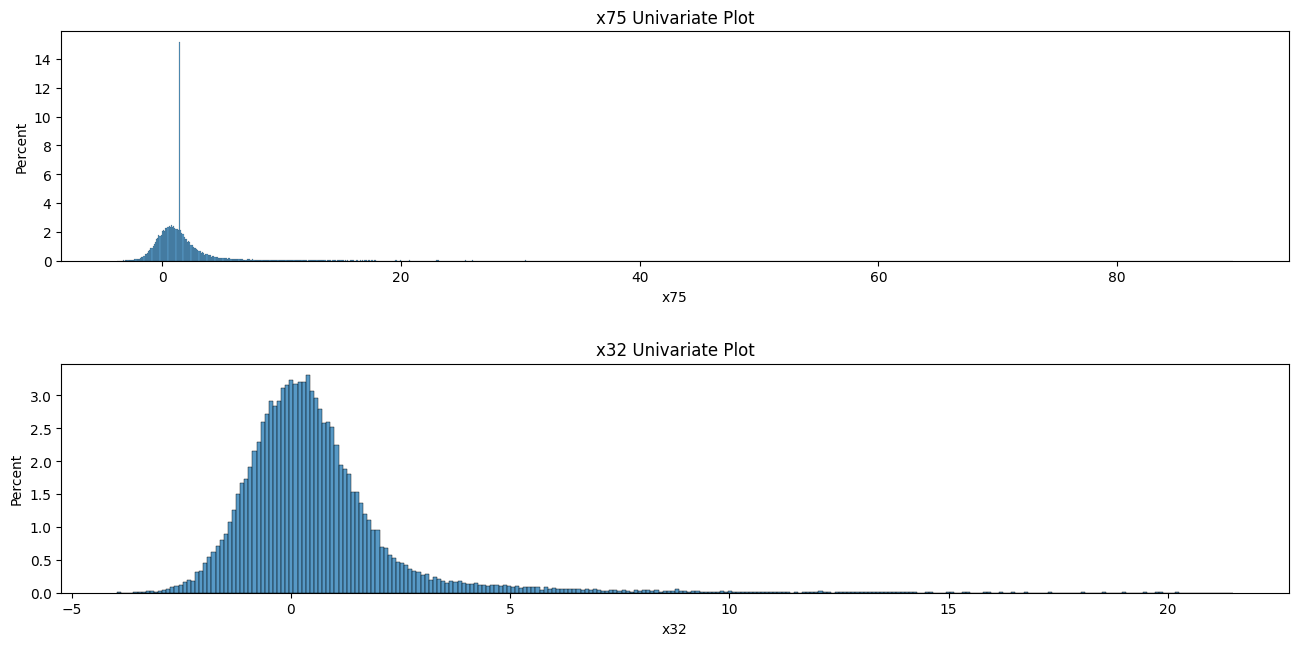

Executing shutdown due to inactivity...


2023-02-20 20:38:13,591 - INFO     - Executing shutdown due to inactivity...


Executing shutdown...


2023-02-20 20:38:13,692 - INFO     - Executing shutdown...


Exception on /shutdown [GET]
Traceback (most recent call last):
  File "/home/bikal/work/venv_ds_3.10/lib/python3.10/site-packages/flask/app.py", line 2528, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/bikal/work/venv_ds_3.10/lib/python3.10/site-packages/flask/app.py", line 1825, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/bikal/work/venv_ds_3.10/lib/python3.10/site-packages/flask/app.py", line 1823, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/bikal/work/venv_ds_3.10/lib/python3.10/site-packages/flask/app.py", line 1799, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
  File "/home/bikal/work/venv_ds_3.10/lib/python3.10/site-packages/dtale/app.py", line 435, in shutdown
    shutdown_server()
  File "/home/bikal/work/venv_ds_3.10/lib/python3.10/site-packages/dtale/app.py", line 421, in shutdown_server
    raise RuntimeError("Not running with the Werkzeu

2023-02-20 20:38:13,696 - ERROR    - Exception on /shutdown [GET]
Traceback (most recent call last):
  File "/home/bikal/work/venv_ds_3.10/lib/python3.10/site-packages/flask/app.py", line 2528, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/bikal/work/venv_ds_3.10/lib/python3.10/site-packages/flask/app.py", line 1825, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/bikal/work/venv_ds_3.10/lib/python3.10/site-packages/flask/app.py", line 1823, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/bikal/work/venv_ds_3.10/lib/python3.10/site-packages/flask/app.py", line 1799, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
  File "/home/bikal/work/venv_ds_3.10/lib/python3.10/site-packages/dtale/app.py", line 435, in shutdown
    shutdown_server()
  File "/home/bikal/work/venv_ds_3.10/lib/python3.10/site-packages/dtale/app.py", line 421, in shutdown_server
    raise Runti

In [81]:
from scipy.stats import skew


def handle_data_skew(df, columns):
    epsilon = 0.001
    for col in columns:
        df[col + "_log"] = df[col].apply(lambda x: np.log(x + epsilon))
    return df


def get_skewed_features(df, numerical_columns, skew_threshold=0.75):
    skew_feat_scores = df[numerical_columns].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
    skewed_feats = skew_feat_scores[skew_feat_scores > 0.75]
    print(f"Highly skewed features are : {skewed_feats}")
    return skewed_feats


skewed_variables = get_skewed_features(train_df, numerical_columns)
univariate_plot_for_variables(
    train_df, ["x75", "x32"], n_cols=1, figsize_x=13, figsize_y=3, top_in_betweeen_subplot_spacing=2.0
)


### 3.5 Feature Scaling :
- Some models i.e Decision Tree are robust to unscaled data, however regression, NNs, KNNs, k-means are extremely sensitive to unscaled features. It leads to all sorts of problem ranging from incorrect modeling to  unstable model to non-convergence.
- Variables: In our case, the vairables have large scales ranging from 99999 to 0. Hence scaling is very important for us.

Proper scaling should be choosen. Because we have  outliers and want to preserved them, we will use RobustScaler, which uses median and is less sennsitive or and is less affected with outliers presence.

1. StandardScaler : Very Outlier sensitive because mean and sd are sensitive to outliers.
2. MinMaxscaler : Very Outlier sensitive
3. MaxAbsScaler : Outlier sensitive
4. RobustScaler : Centering and scaling based on percentiles,hence less outliers sensitive + Outliers  in transformed data are preserved.
5. QuantileTransformer : Outlier sensitive but outliers are clipped.

We will choose RobustScaler to scale  while also preserving the outliers in our data.



In [31]:
train_stats = train_df.describe().T.reset_index()
train_stats = train_stats.sort_values(by="mean", ascending=False)
dtale.show(train_stats)


Exception occurred while processing request: 'NoneType' object is not iterable
Traceback (most recent call last):
  File "/home/bikal/work/venv_ds_3.10/lib/python3.10/site-packages/dtale/views.py", line 111, in _handle_exceptions
    return func(*args, **kwargs)
  File "/home/bikal/work/venv_ds_3.10/lib/python3.10/site-packages/dtale/views.py", line 2541, in get_data
    curr_dtypes = [c["name"] for c in global_state.get_dtypes(data_id)]
TypeError: 'NoneType' object is not iterable


2023-02-20 17:24:48,295 - ERROR    - Exception occurred while processing request: 'NoneType' object is not iterable
Traceback (most recent call last):
  File "/home/bikal/work/venv_ds_3.10/lib/python3.10/site-packages/dtale/views.py", line 111, in _handle_exceptions
    return func(*args, **kwargs)
  File "/home/bikal/work/venv_ds_3.10/lib/python3.10/site-packages/dtale/views.py", line 2541, in get_data
    curr_dtypes = [c["name"] for c in global_state.get_dtypes(data_id)]
TypeError: 'NoneType' object is not iterable


#### 3.5.1 Fix Scaling:
- Variables have wide scales from 99927 to -6.2 mean. 
- Hence we will scale them, so that stable model can be found and that model convergence happens faster.
- We will rescale all variable with mean  greater than 2 or less than -2

In [32]:
ckpt_train_df_pre_scaling = train_df.copy()
ckpt_test__df_pre_scaling = test_df.copy()

from sklearn.preprocessing import RobustScaler, MinMaxScaler


def handle_variable_scaling(df, all_numerical_columns, is_train_data=True, scaler=None, inplace=False):
    to_scale_columns = []
    for col in all_numerical_columns:
        if inplace:
            to_scale_columns.append(col)
            continue
        else:
            df["scl_" + col] = df[col]
            to_scale_columns.append("scl_" + col)

    print(f"New Scaled Columns created {to_scale_columns}")

    if is_train_data:
        print("Creating Training Scaler")
        scaler = RobustScaler()
        scaler.fit(df[to_scale_columns])

    df[to_scale_columns] = scaler.transform(df[to_scale_columns])
    return df, scaler


train_df = ckpt_train_df_pre_scaling.copy()
test_df = ckpt_test__df_pre_scaling.copy()

variables_to_scale = train_stats[(train_stats["mean"] > 2) | (train_stats["mean"] < -2)]["index"]
print(f" Following {len(variables_to_scale)} Variables are going to be scaled {list(variables_to_scale)}")

numerical_columns_to_scale = variables_to_scale
train_df, scaler_from_training = handle_variable_scaling(
    train_df, numerical_columns_to_scale, is_train_data=True, inplace=True
)
test_df, _ = handle_variable_scaling(
    test_df, numerical_columns_to_scale, is_train_data=False, scaler=scaler_from_training, inplace=True
)


 Following 49 Variables are going to be scaled ['x41', 'x50', 'x27', 'x58', 'x16', 'x100', 'x11', 'x85', 'x18', 'x22', 'x36', 'x53', 'x48', 'x34', 'x64', 'x86', 'x47', 'x72', 'x78', 'x38', 'x37', 'x2', 'x28', 'x40', 'x68', 'x67', 'x21', 'x89', 'x96', 'x49', 'x80', 'x61', 'x97', 'x17', 'x73', 'x25', 'x20', 'x92', 'x94', 'x13', 'x62', 'x83', 'x12', 'x90', 'x1', 'x9', 'x84', 'x19', 'x82']
New Scaled Columns created ['x41', 'x50', 'x27', 'x58', 'x16', 'x100', 'x11', 'x85', 'x18', 'x22', 'x36', 'x53', 'x48', 'x34', 'x64', 'x86', 'x47', 'x72', 'x78', 'x38', 'x37', 'x2', 'x28', 'x40', 'x68', 'x67', 'x21', 'x89', 'x96', 'x49', 'x80', 'x61', 'x97', 'x17', 'x73', 'x25', 'x20', 'x92', 'x94', 'x13', 'x62', 'x83', 'x12', 'x90', 'x1', 'x9', 'x84', 'x19', 'x82']
Creating Training Scaler
New Scaled Columns created ['x41', 'x50', 'x27', 'x58', 'x16', 'x100', 'x11', 'x85', 'x18', 'x22', 'x36', 'x53', 'x48', 'x34', 'x64', 'x86', 'x47', 'x72', 'x78', 'x38', 'x37', 'x2', 'x28', 'x40', 'x68', 'x67', 'x21', 

#### 3.5.2 Scaling: Verify

In [33]:
train_stats_post_scale = train_df.describe().T.reset_index()
train_stats_post_scale = train_stats_post_scale.sort_values(by="mean", ascending=False)
dtale.show(train_stats_post_scale)

### 3.6 Correlation :
- Correlation causes problems during modeling. Unstable model at best and non-coverging models at worst. 
- We will use statistical tests to  get highly correlated variables.
- Variables :
    - No highly correlated variables were observed (>0.8). Hence no processing was necessary

<AxesSubplot: >

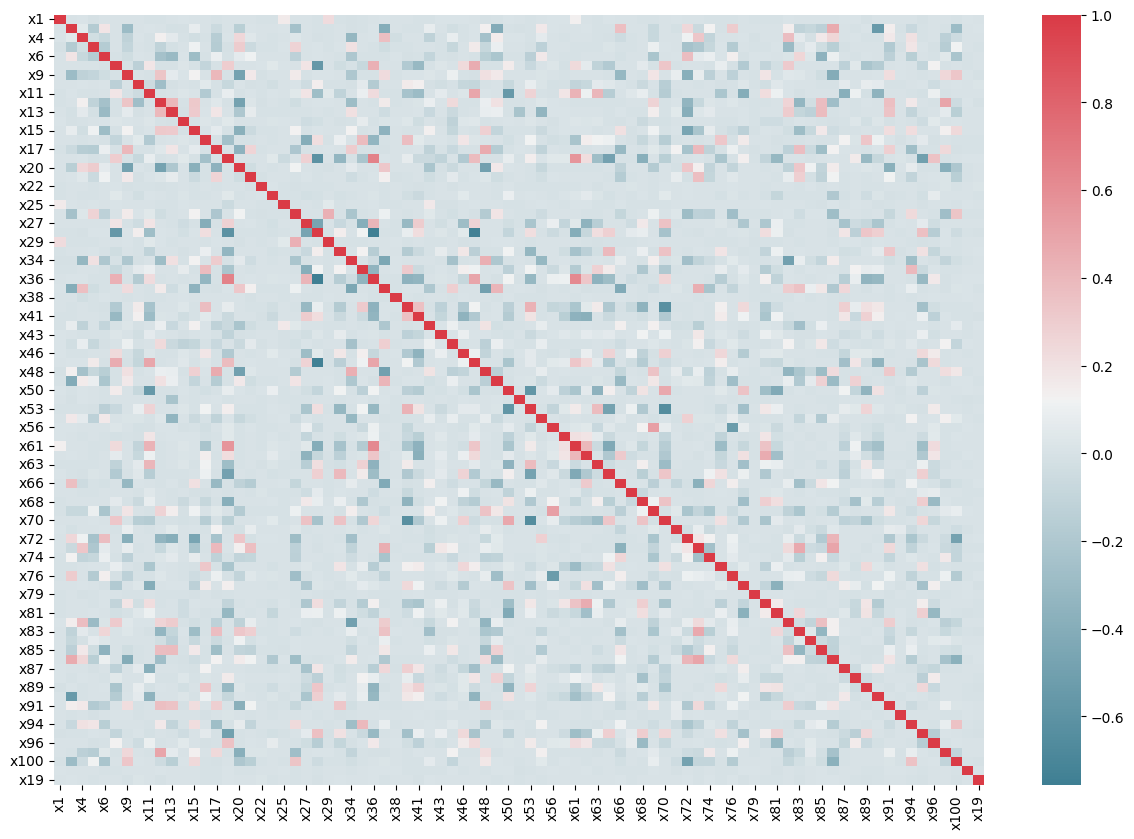

In [35]:
import numpy as np

correlation = train_df[numerical_columns].corr()

f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(correlation, cmap=sns.diverging_palette(220, 10, as_cmap=True), ax=ax)

In [36]:
def get_highly_correlated_variables(df: pd.DataFrame, threshold: float):
    xCorr = df.corr()
    xFiltered = xCorr[((xCorr >= threshold) | (xCorr <= -threshold)) & (xCorr != 1.000)]
    xFlattened = xFiltered.unstack().sort_values().drop_duplicates()
    return xFlattened


def is_same_column_variant(col1, col2):
    if len(col1) > len(col2):
        col1, col2 = col2, col1

    smaller_name_col, longer_name_col = col1, col2
    return smaller_name_col in longer_name_col


def get_removal_recommendation_for_highly_correlated_variables(highly_correlated_variables, cp_train_df):
    """Remove variables with lowest variance"""
    cor_df = pd.DataFrame(highly_correlated_variables.reset_index())
    cor_df.columns = ["variable_1", "variable_2", "correlation"]
    cor_df["variance_var1"] = cor_df["variable_1"].apply(lambda x: cp_train_df[x].var())
    cor_df["variance_var2"] = cor_df["variable_2"].apply(lambda x: cp_train_df[x].var())

    cor_df["recommended_removal"] = cor_df.apply(
        lambda row: row["variable_1"] if row["variance_var1"] < row["variance_var2"] else row["variable_2"], axis=1
    )

    cor_df["is_same_col_variant"] = cor_df.apply(
        lambda row: is_same_column_variant(row["variable_1"], row["variable_2"]), axis=1
    )
    cor_df = cor_df[cor_df.is_same_col_variant == False]
    return cor_df.sort_values(by=["correlation"])


all_number_columns = list(train_df.select_dtypes(include="number").columns)
highly_correlated_variables_df = get_highly_correlated_variables(train_df[all_number_columns], 0.7)
highly_correlated_variables_with_removal_recommendation = get_removal_recommendation_for_highly_correlated_variables(
    highly_correlated_variables_df, train_df
)
highly_correlated_variables_with_removal_recommendation


variable_1 variable_2  correlation  variance_var1  variance_var2  \
0        x28        x36    -0.755564       0.545768       0.548604   
1        x28        x47    -0.741358       0.545768       0.544519   

  recommended_removal  is_same_col_variant  
0                 x28                False  
1                 x47                False

### 3.7 Low Variance Vairablese
We will remove features that have low variance or variability (i.e features that are close to zero).
- Variance is range dependent, hence must be done after scaling.
- No Variable Removed. Because In our case, there are no variables with very low variance.
- Why ?
    - Because features with low variance or variability  do not provide any information to a ML model for learning the pattern.
- How ?
    - Dummmy variables are expected to have low variance, hence we will exclude them from the analysis here.
    



Non-Dummy Features with low variance are : ['x7'] 


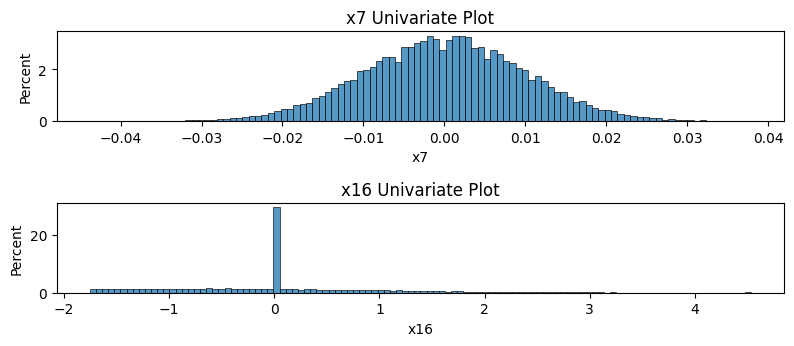

In [40]:
low_variance_variables = train_df[all_number_columns].var().sort_values()[0:30]
low_variance_variables_df = low_variance_variables.reset_index()
low_variance_variables_df["col"] = low_variance_variables_df["index"]
dtale.show(low_variance_variables_df)

low_variance_variables = list(low_variance_variables_df[low_variance_variables_df[0] <= 0.2]["col"])
non_dummy_low_variance_variables = []
for features in low_variance_variables:
    # Dummy variables have _. Using the rule to remove those dummy variables
    if "_" not in features:
        non_dummy_low_variance_variables.append(features)

print(f"Non-Dummy Features with low variance are : {non_dummy_low_variance_variables} ")
univariate_plot_for_variables(
    train_df,
    non_dummy_low_variance_variables + ["x16"],
    n_cols=1,
    figsize_x=8,
    figsize_y=2,
    top_in_betweeen_subplot_spacing=1.5,
)

dtale.show(low_variance_variables_df)


#### 3.7.1 Low Variance Fix:
- None Removed because all are valid. 
    - Binary categorical variables : x59, x79,... are binary categorical variables and hence acceptable.
    - x7  and x70 have variance but seem to be -vely affected by scales. We will scale them up so that their variance is captured and the models later can easily converge.

In [41]:
train_df['x7'] = train_df['x7']*100
test_df['x7'] = test_df['x7']*100

### 3.8 Final Check : EDA
- We will do a final EDA check post processing fixes applied, to ensure that not further preprocessing is necessary and to ensure that the features are ready for modeling.


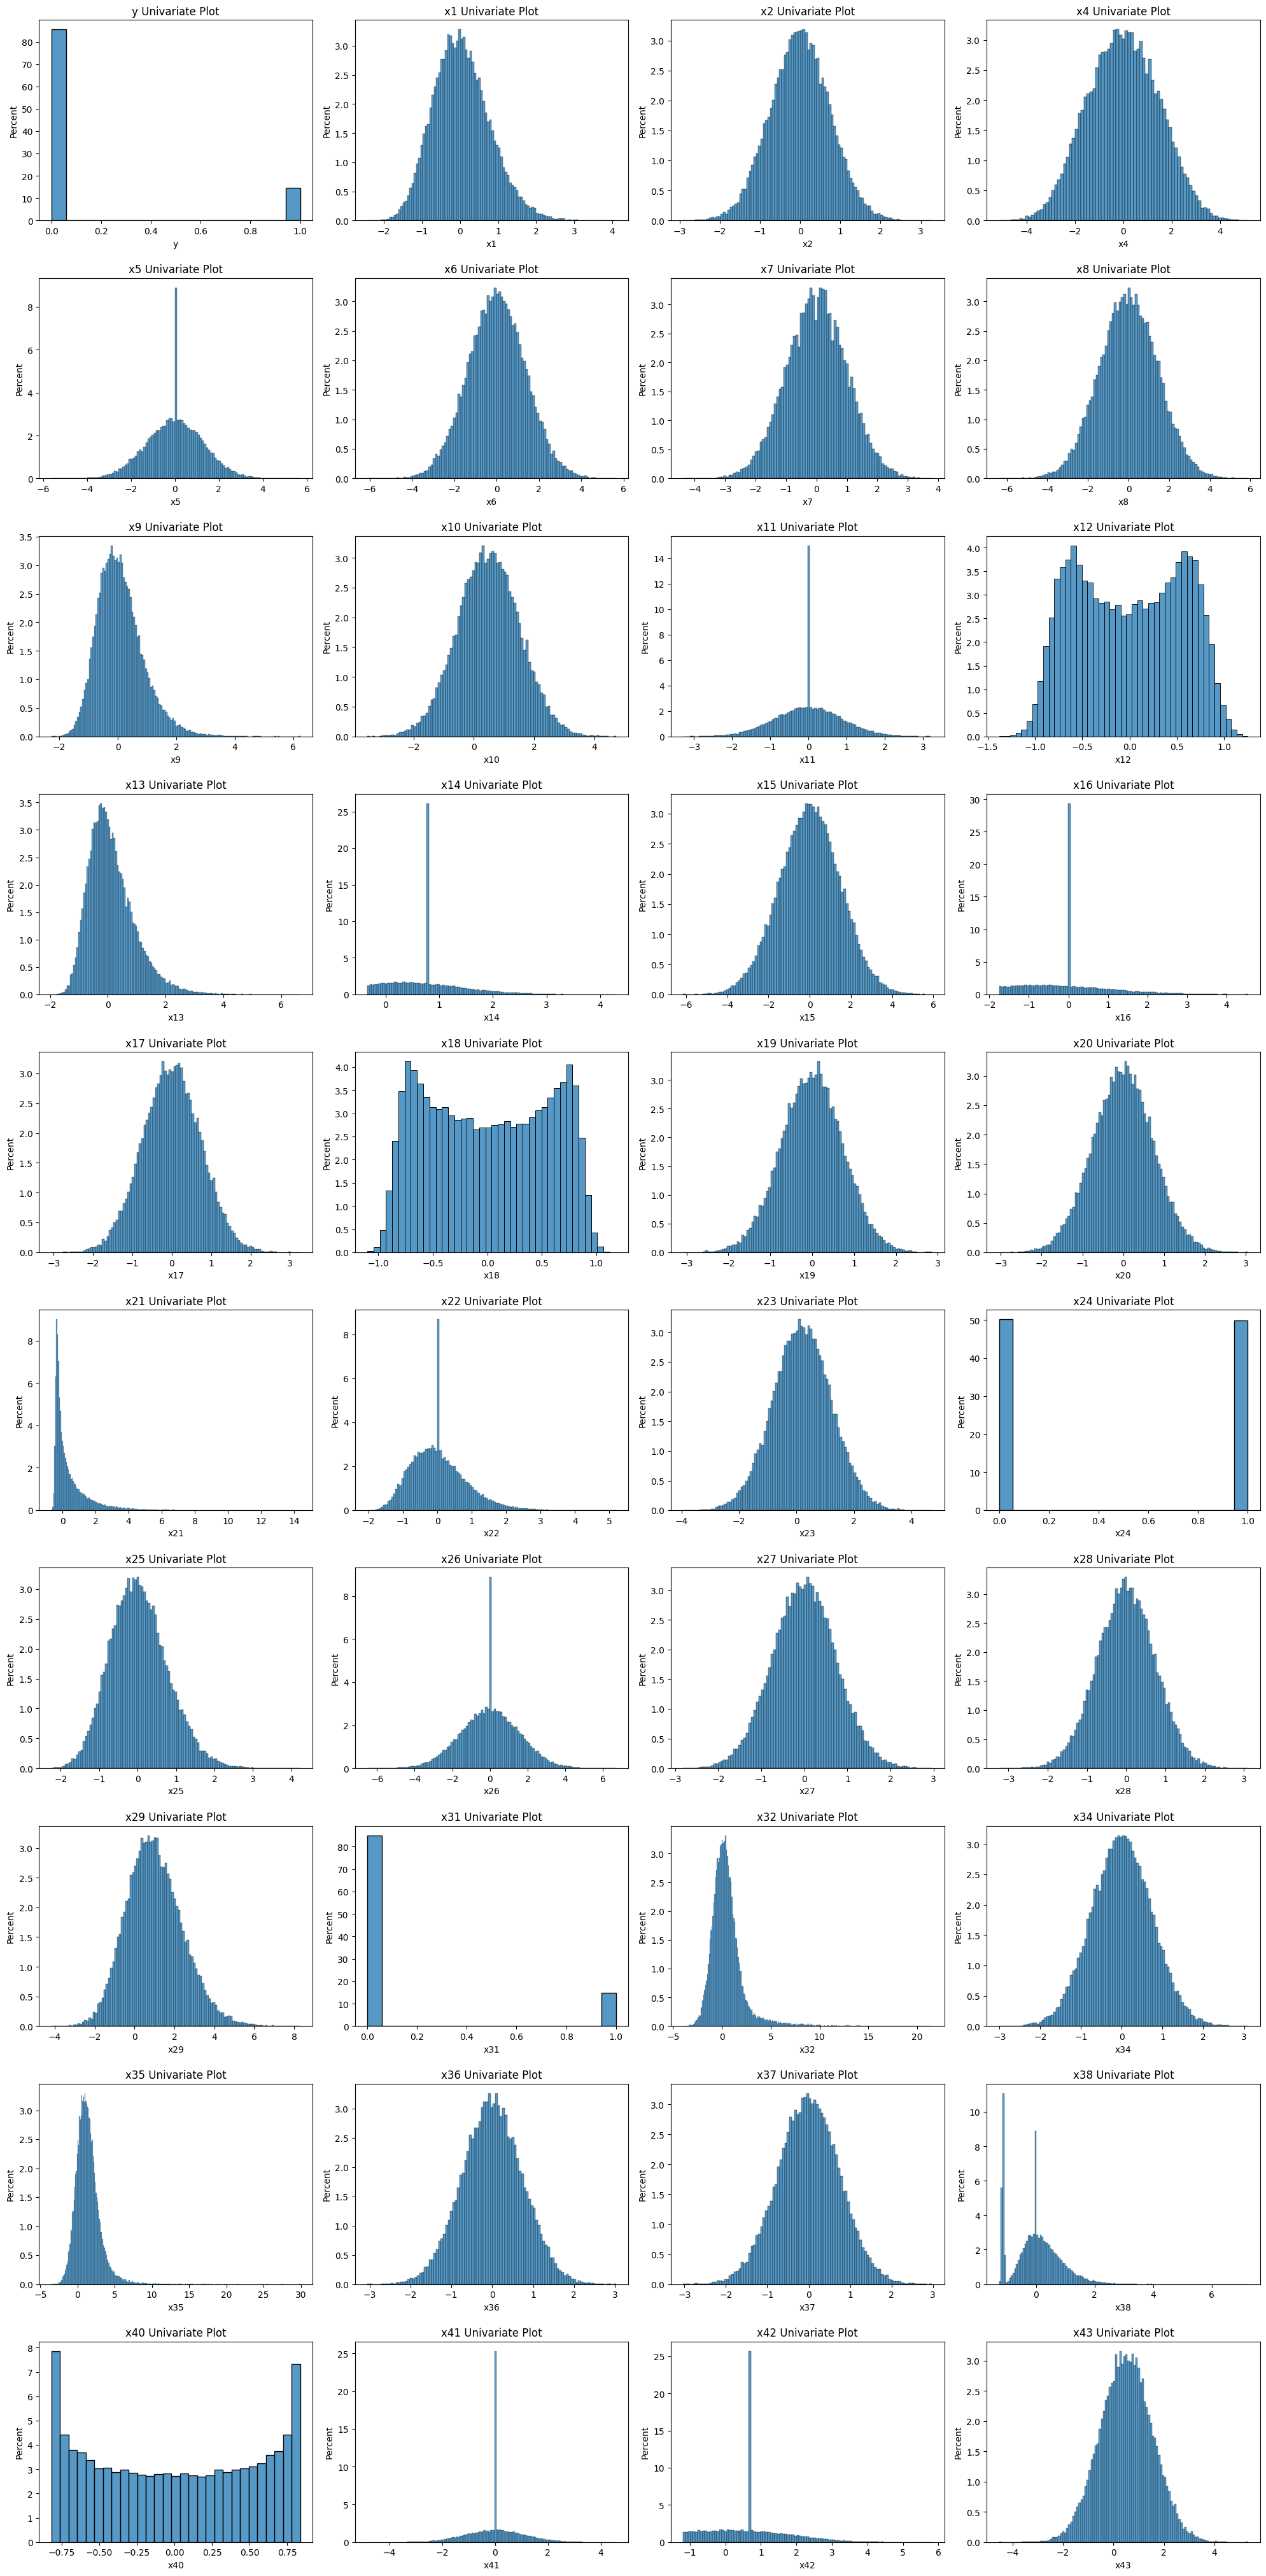

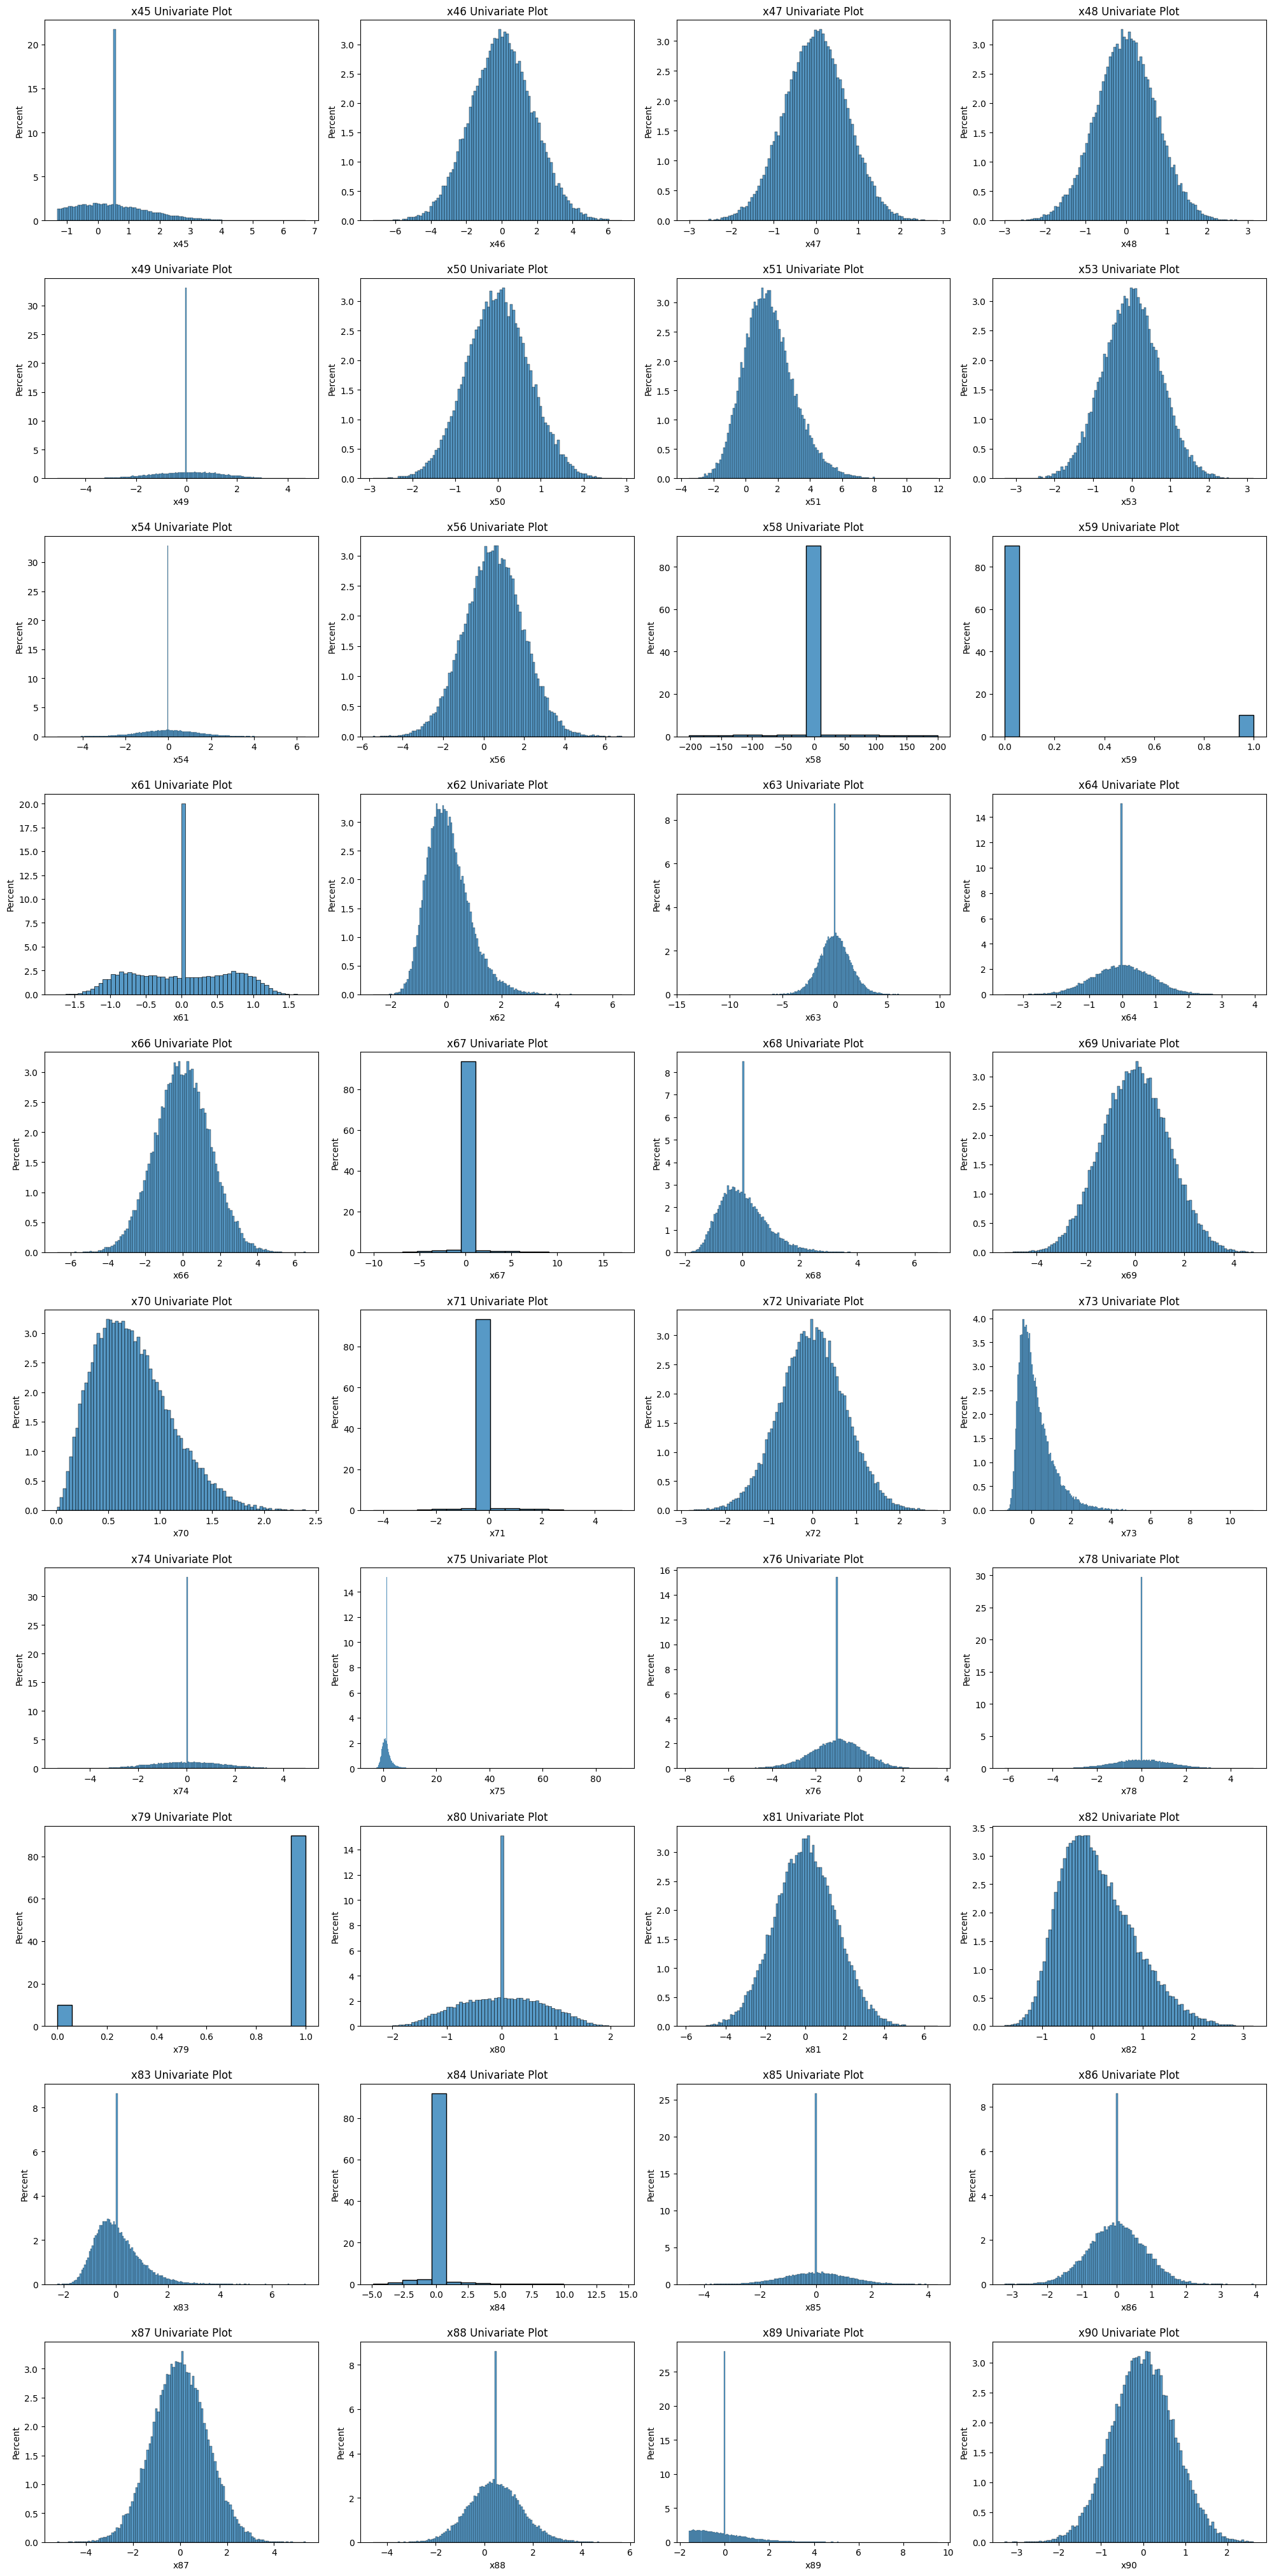

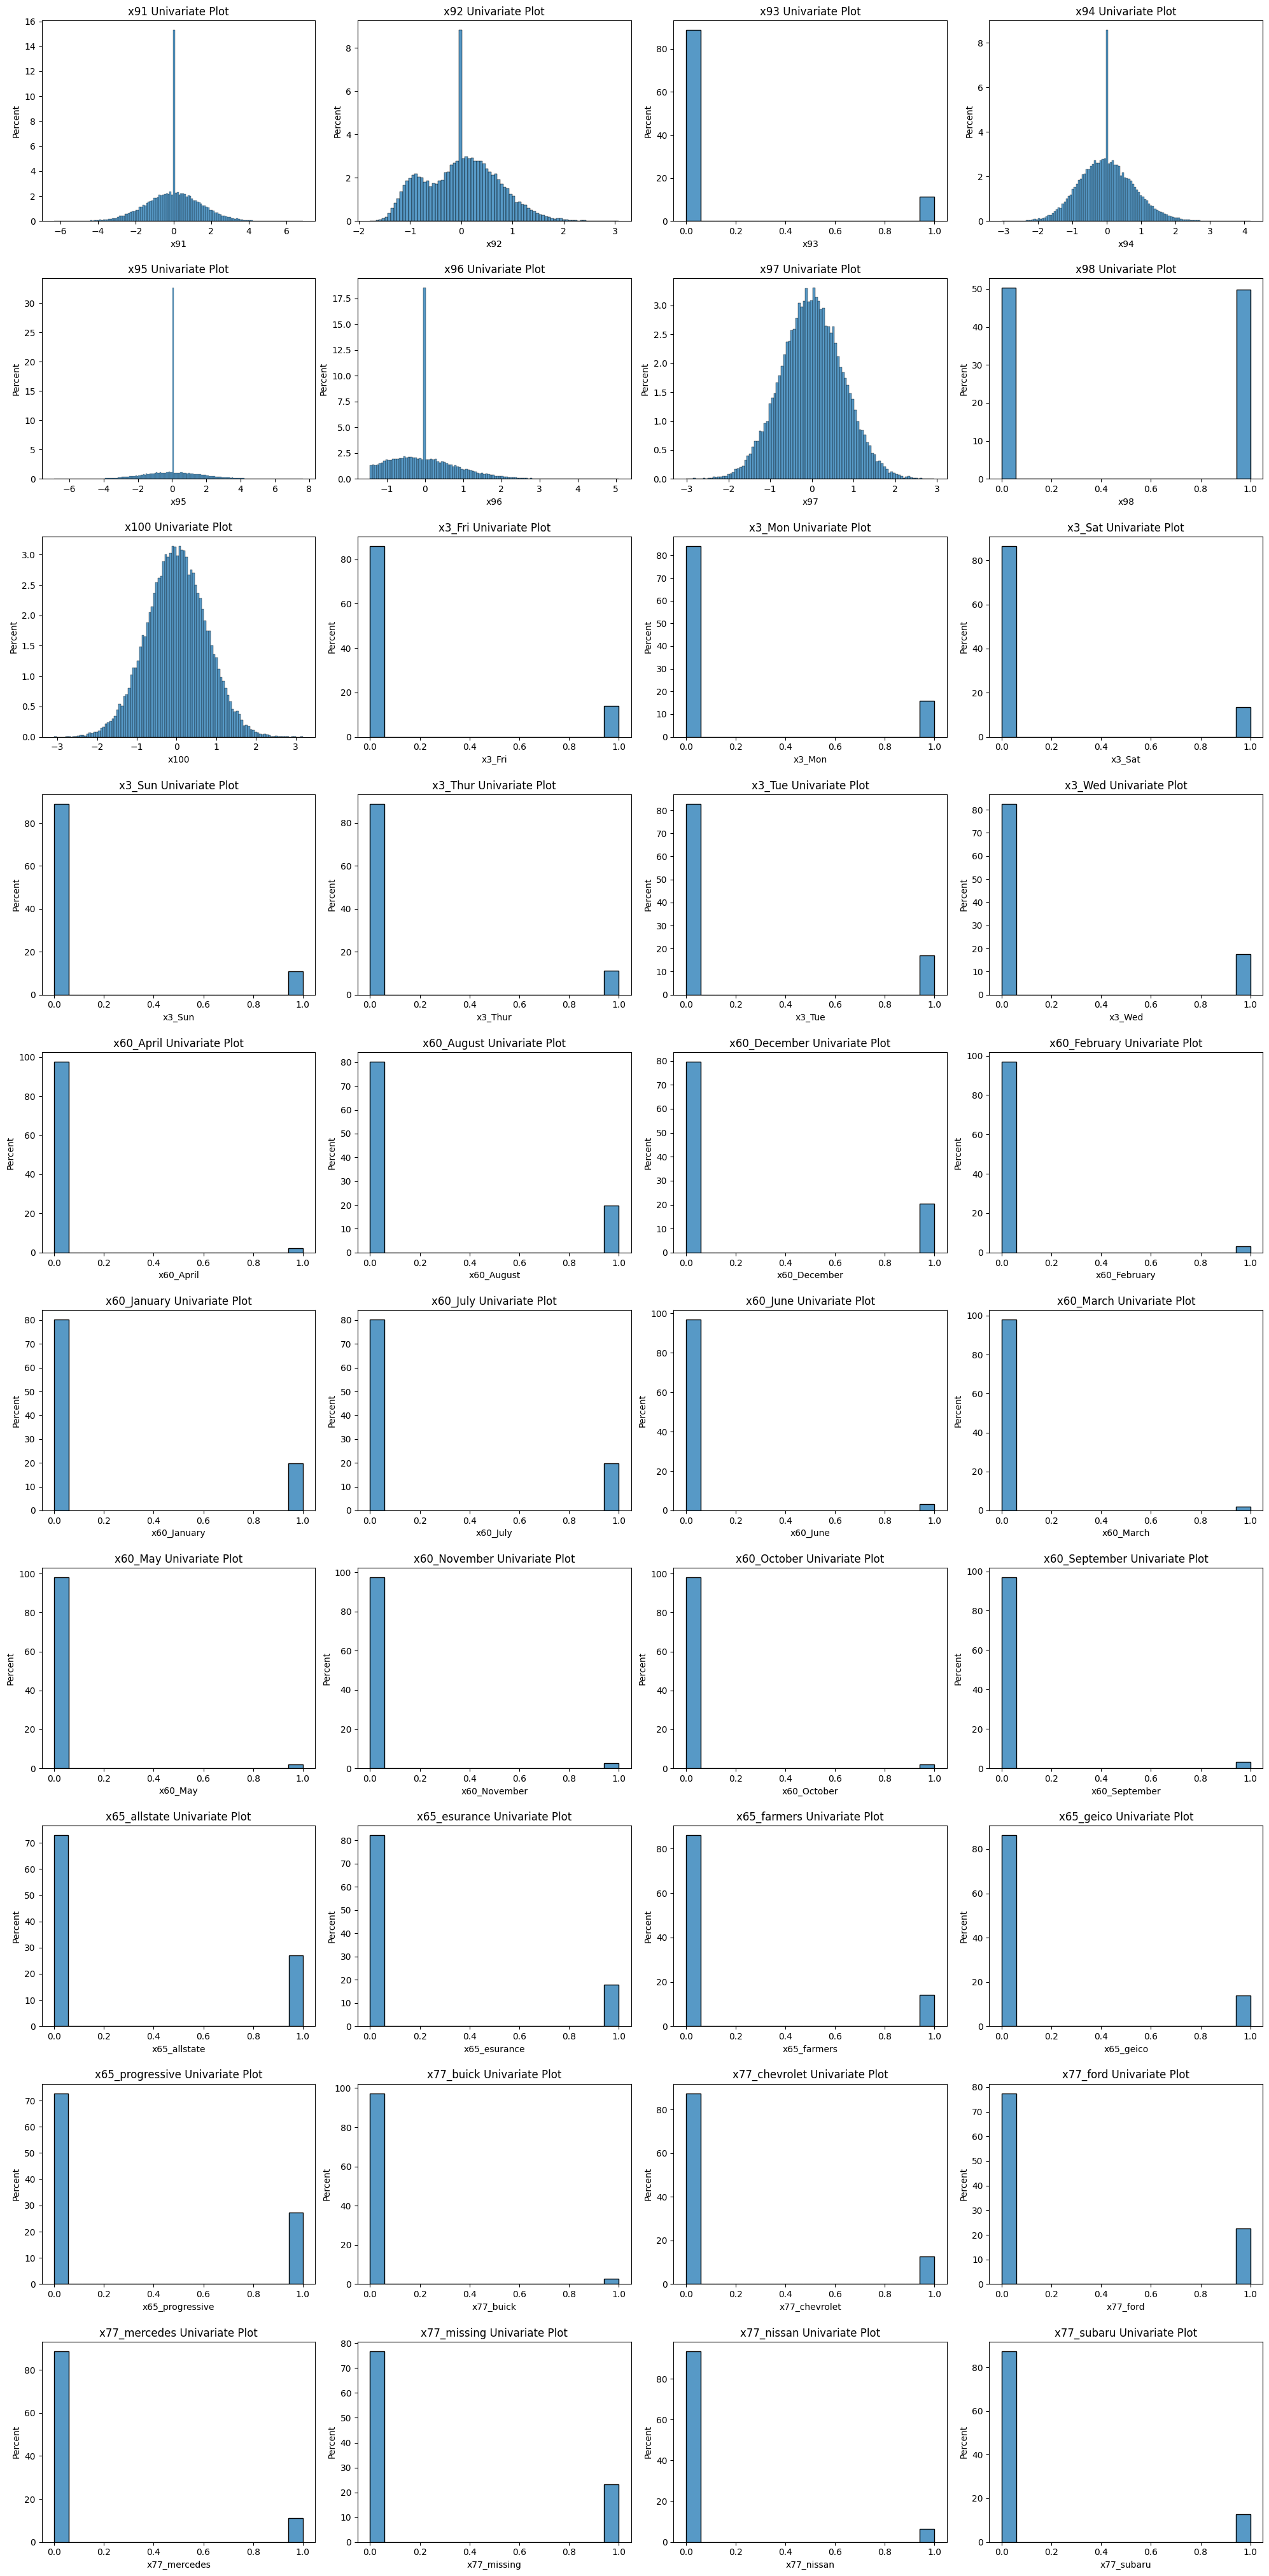

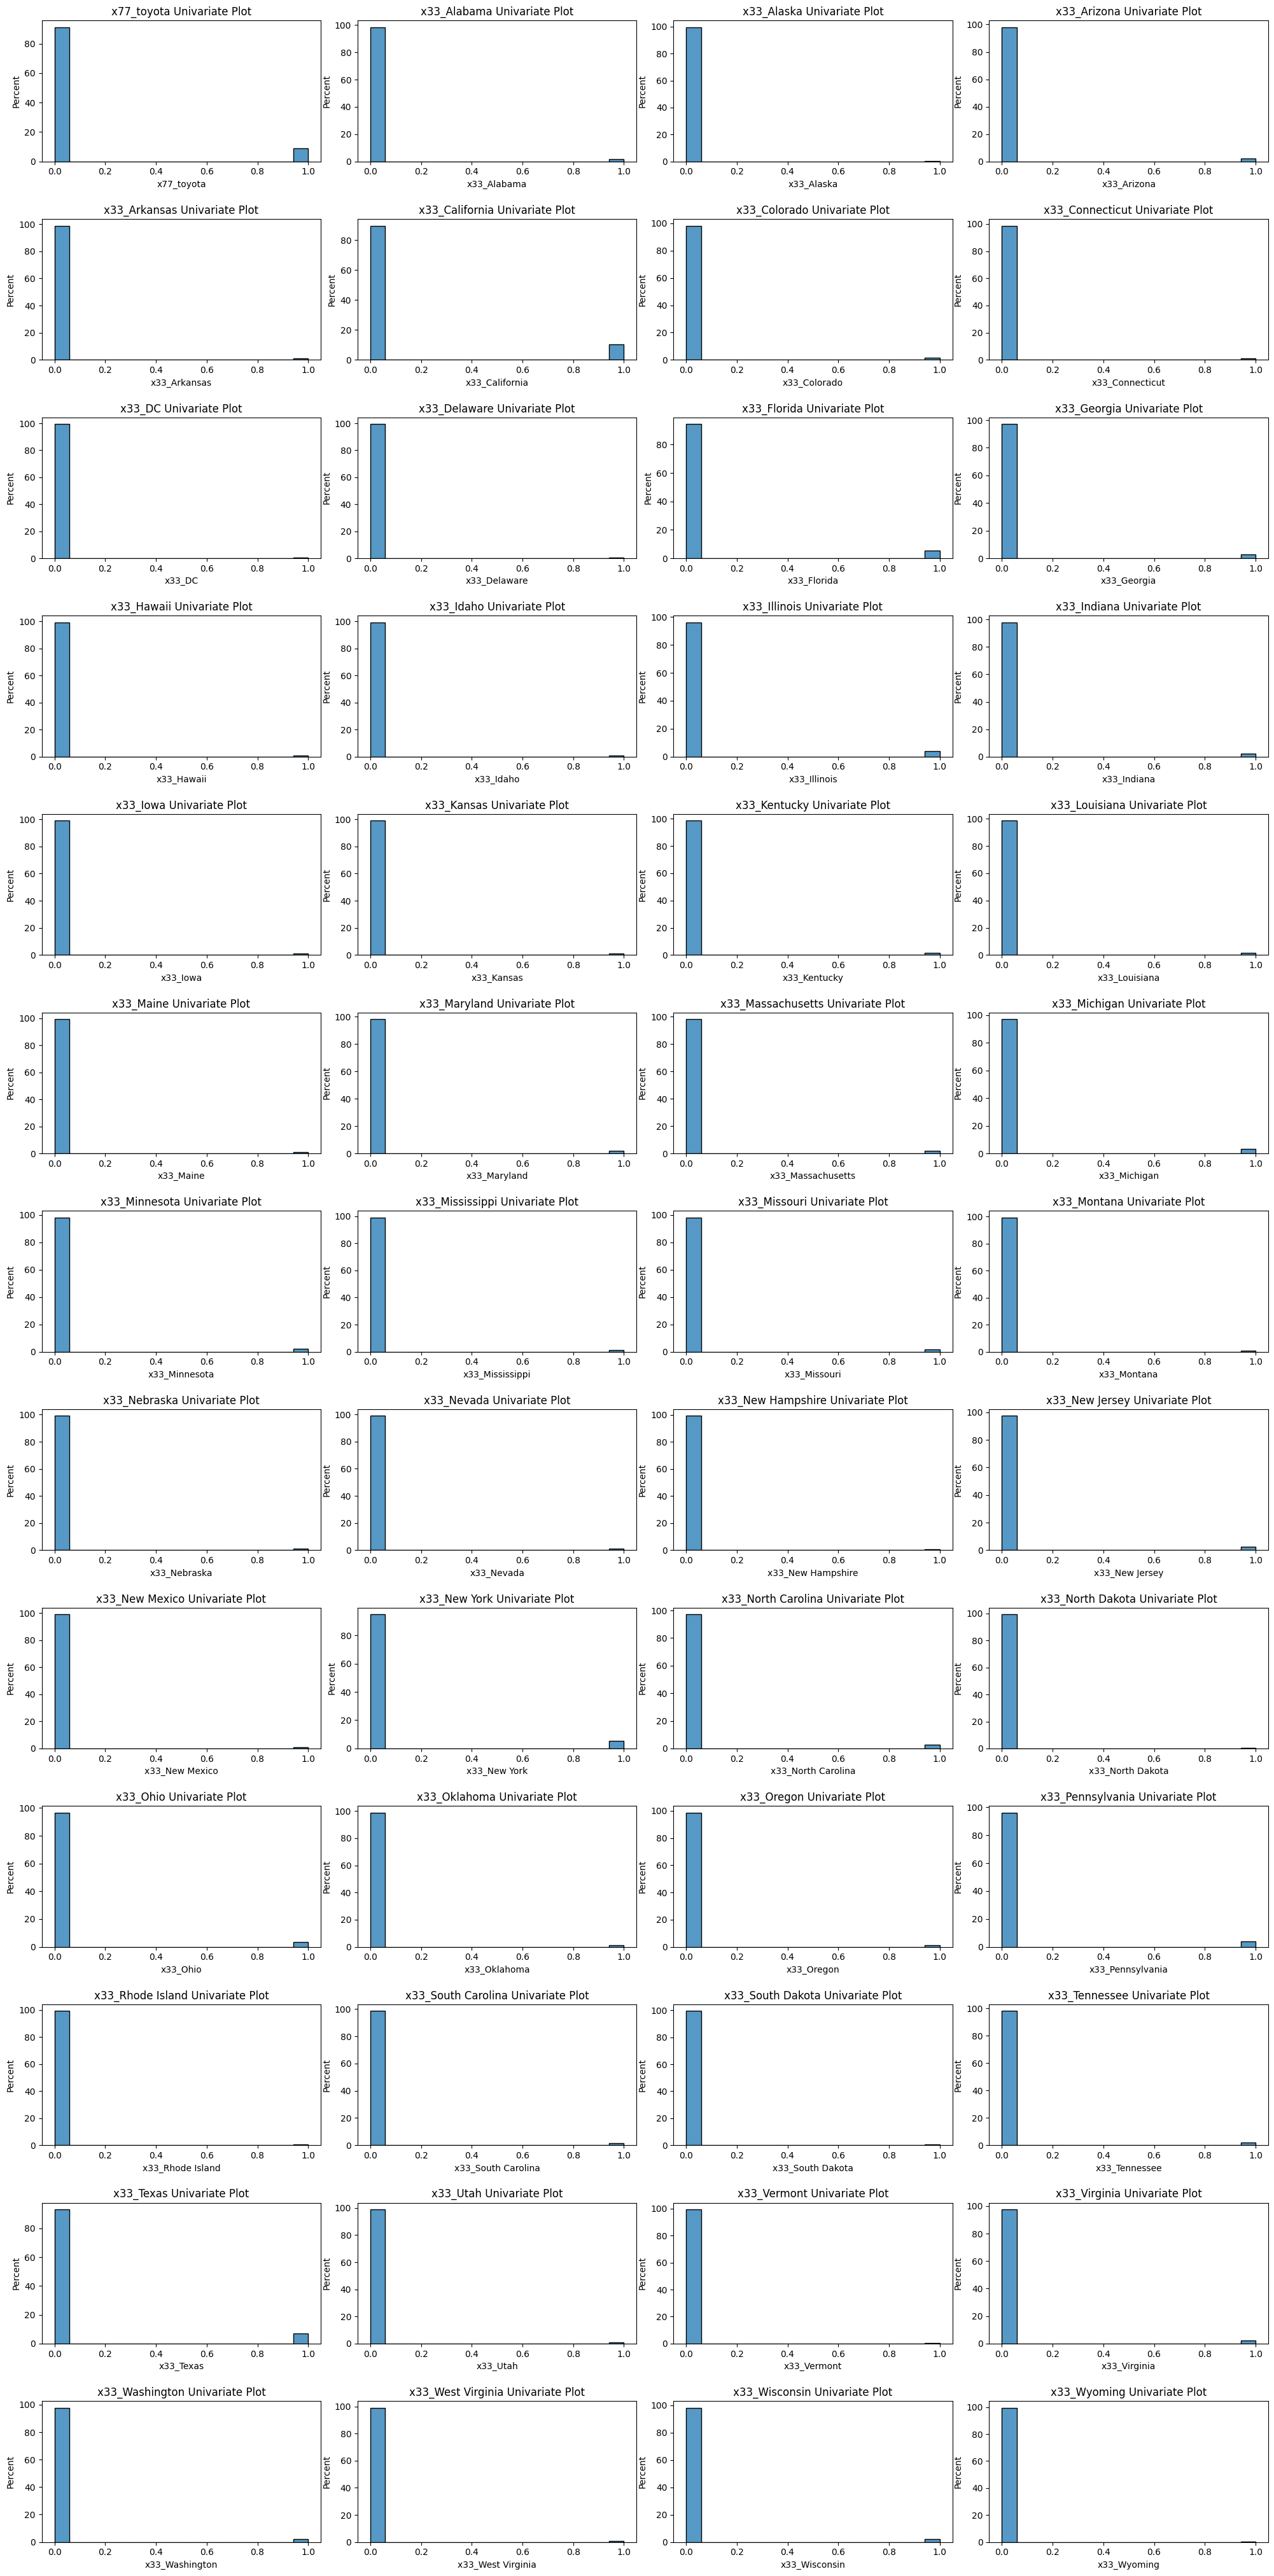

In [42]:
all_columns = list(train_df.columns)
univariate_plot_for_variables(train_df, all_columns[0:40],
                              n_cols=4, figsize_x=20, figsize_y=20,
                              top_in_betweeen_subplot_spacing=2)
univariate_plot_for_variables(train_df, all_columns[40:80],
                              n_cols=4, figsize_x=20, figsize_y=20,
                              top_in_betweeen_subplot_spacing=2)
univariate_plot_for_variables(train_df, all_columns[80:120],
                              n_cols=4, figsize_x=20, figsize_y=20,
                              top_in_betweeen_subplot_spacing=2)
univariate_plot_for_variables(train_df, all_columns[120:],
                              n_cols=4, figsize_x=20, figsize_y=20,
                              top_in_betweeen_subplot_spacing=2)

#### 3.8.1 Final EDA Check : Bivariate Analysis 

##### 3.8.1.1 Bivariate EDA : Numerical variables (vs Class Label)


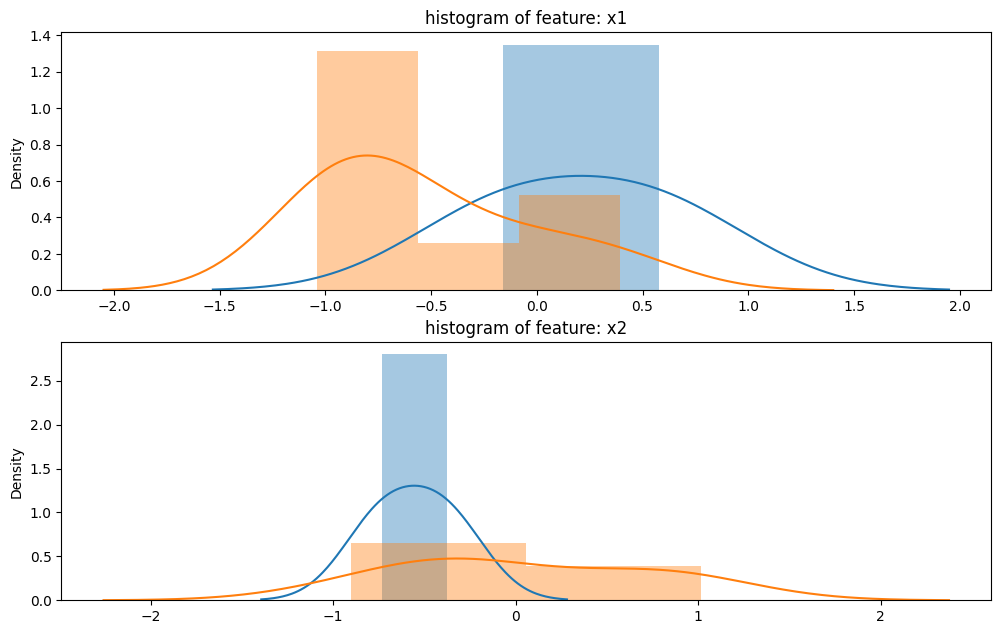

In [43]:
import matplotlib.gridspec as gridspec


def bivariate_plot_numerical_vs_binary_label(df, numerical_columns, class_label):
    plt.figure(figsize=(12, 28 * 4))
    gs = gridspec.GridSpec(28, 1)
    for i, col in enumerate(df[numerical_columns]):
        ax = plt.subplot(gs[i])
        sns.distplot(df[col][df[class_label] == 1])
        sns.distplot(df[col][df[class_label] == 0])
        ax.set_xlabel("")
        ax.set_title("histogram of feature: " + str(col))
    plt.show()


bivariate_plot_numerical_vs_binary_label(train_df[0:10], numerical_columns[0:2], "y")


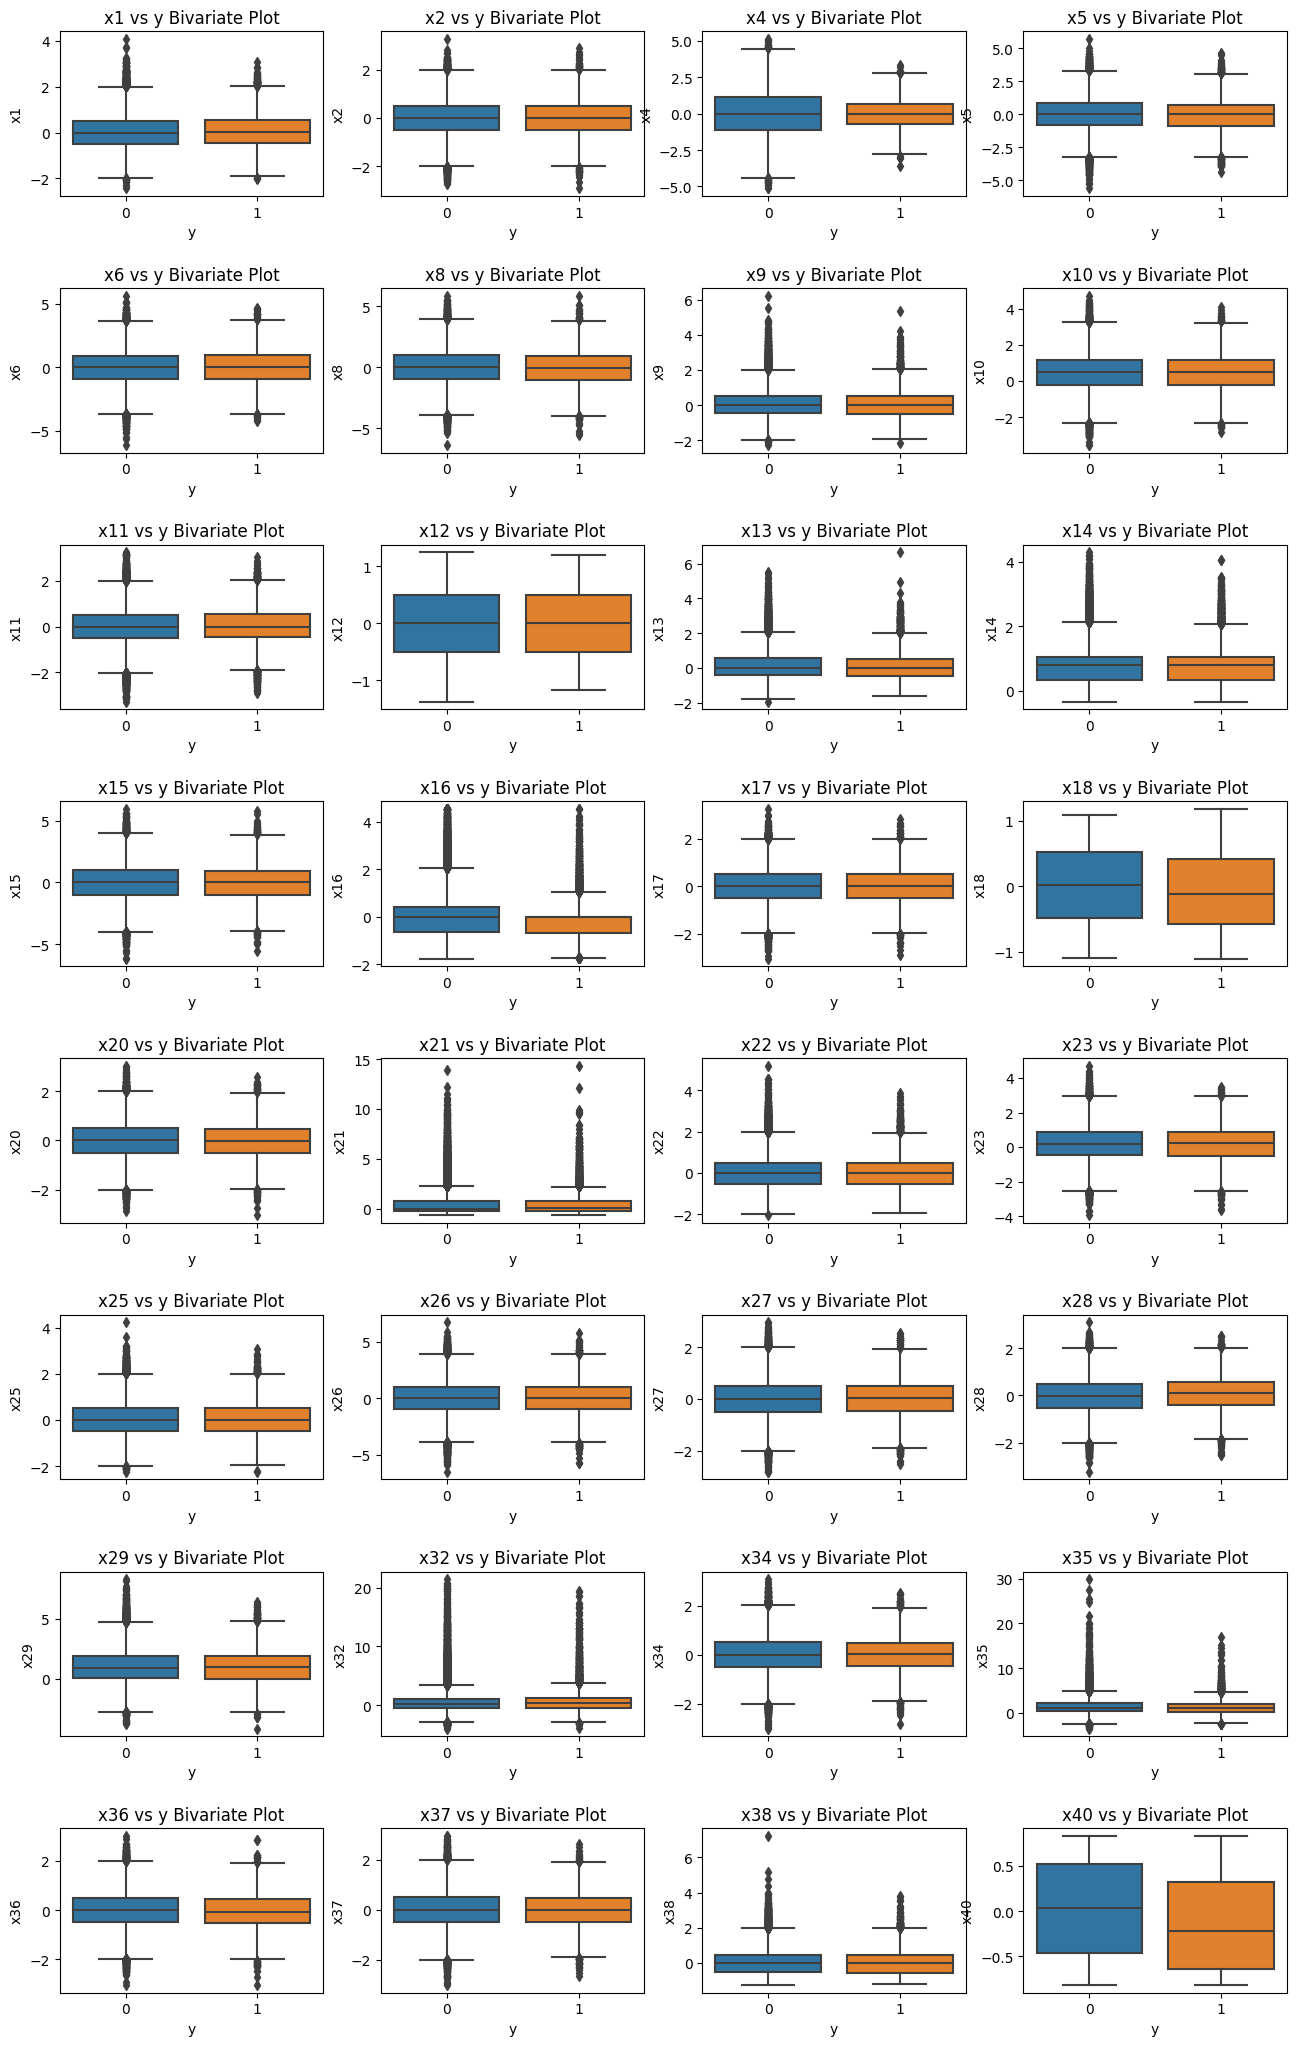

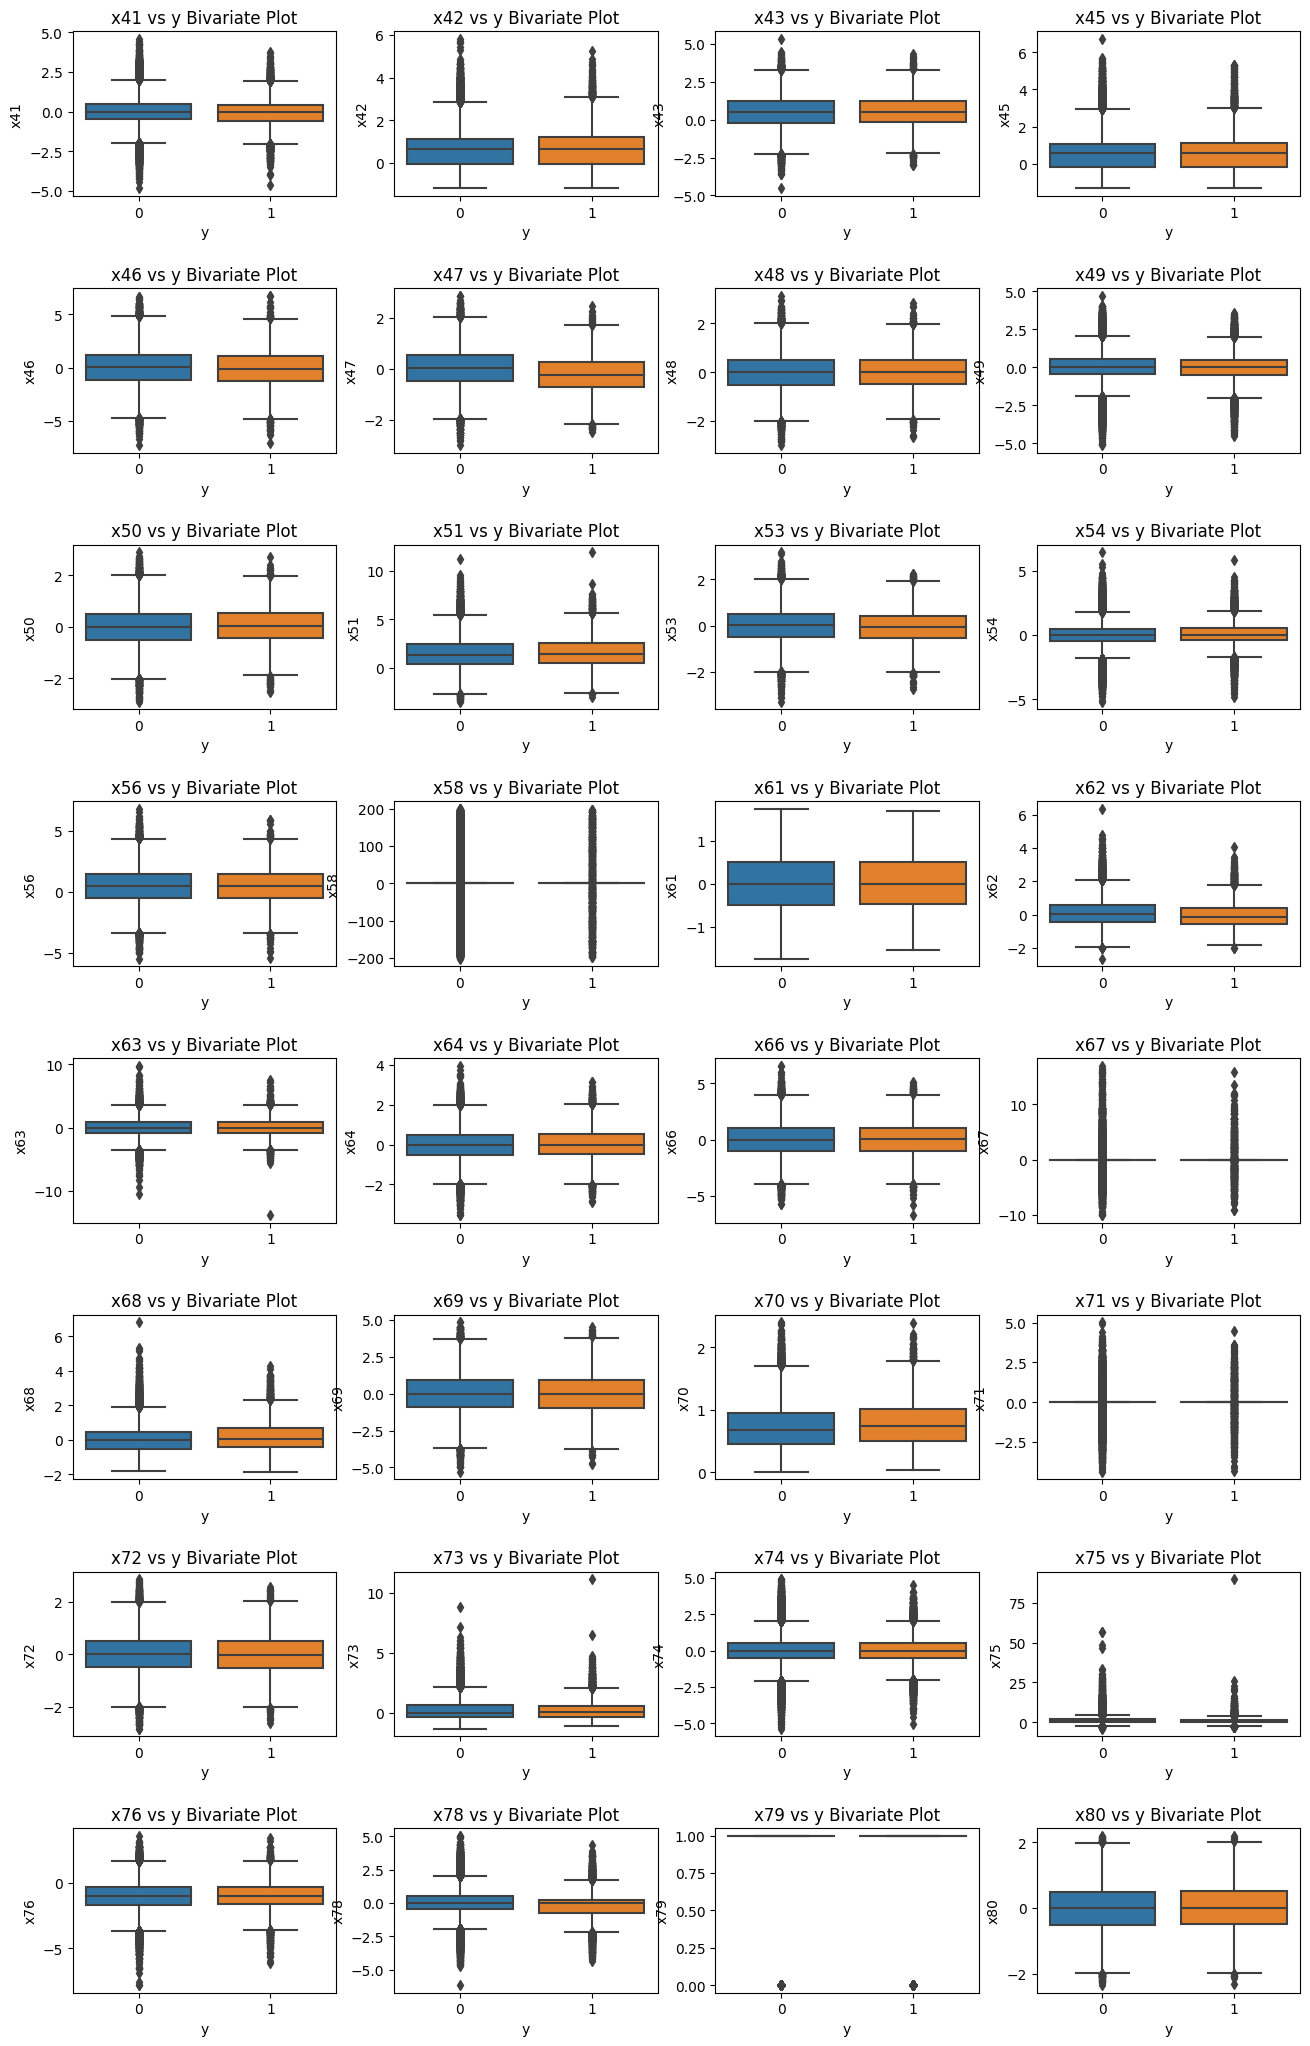

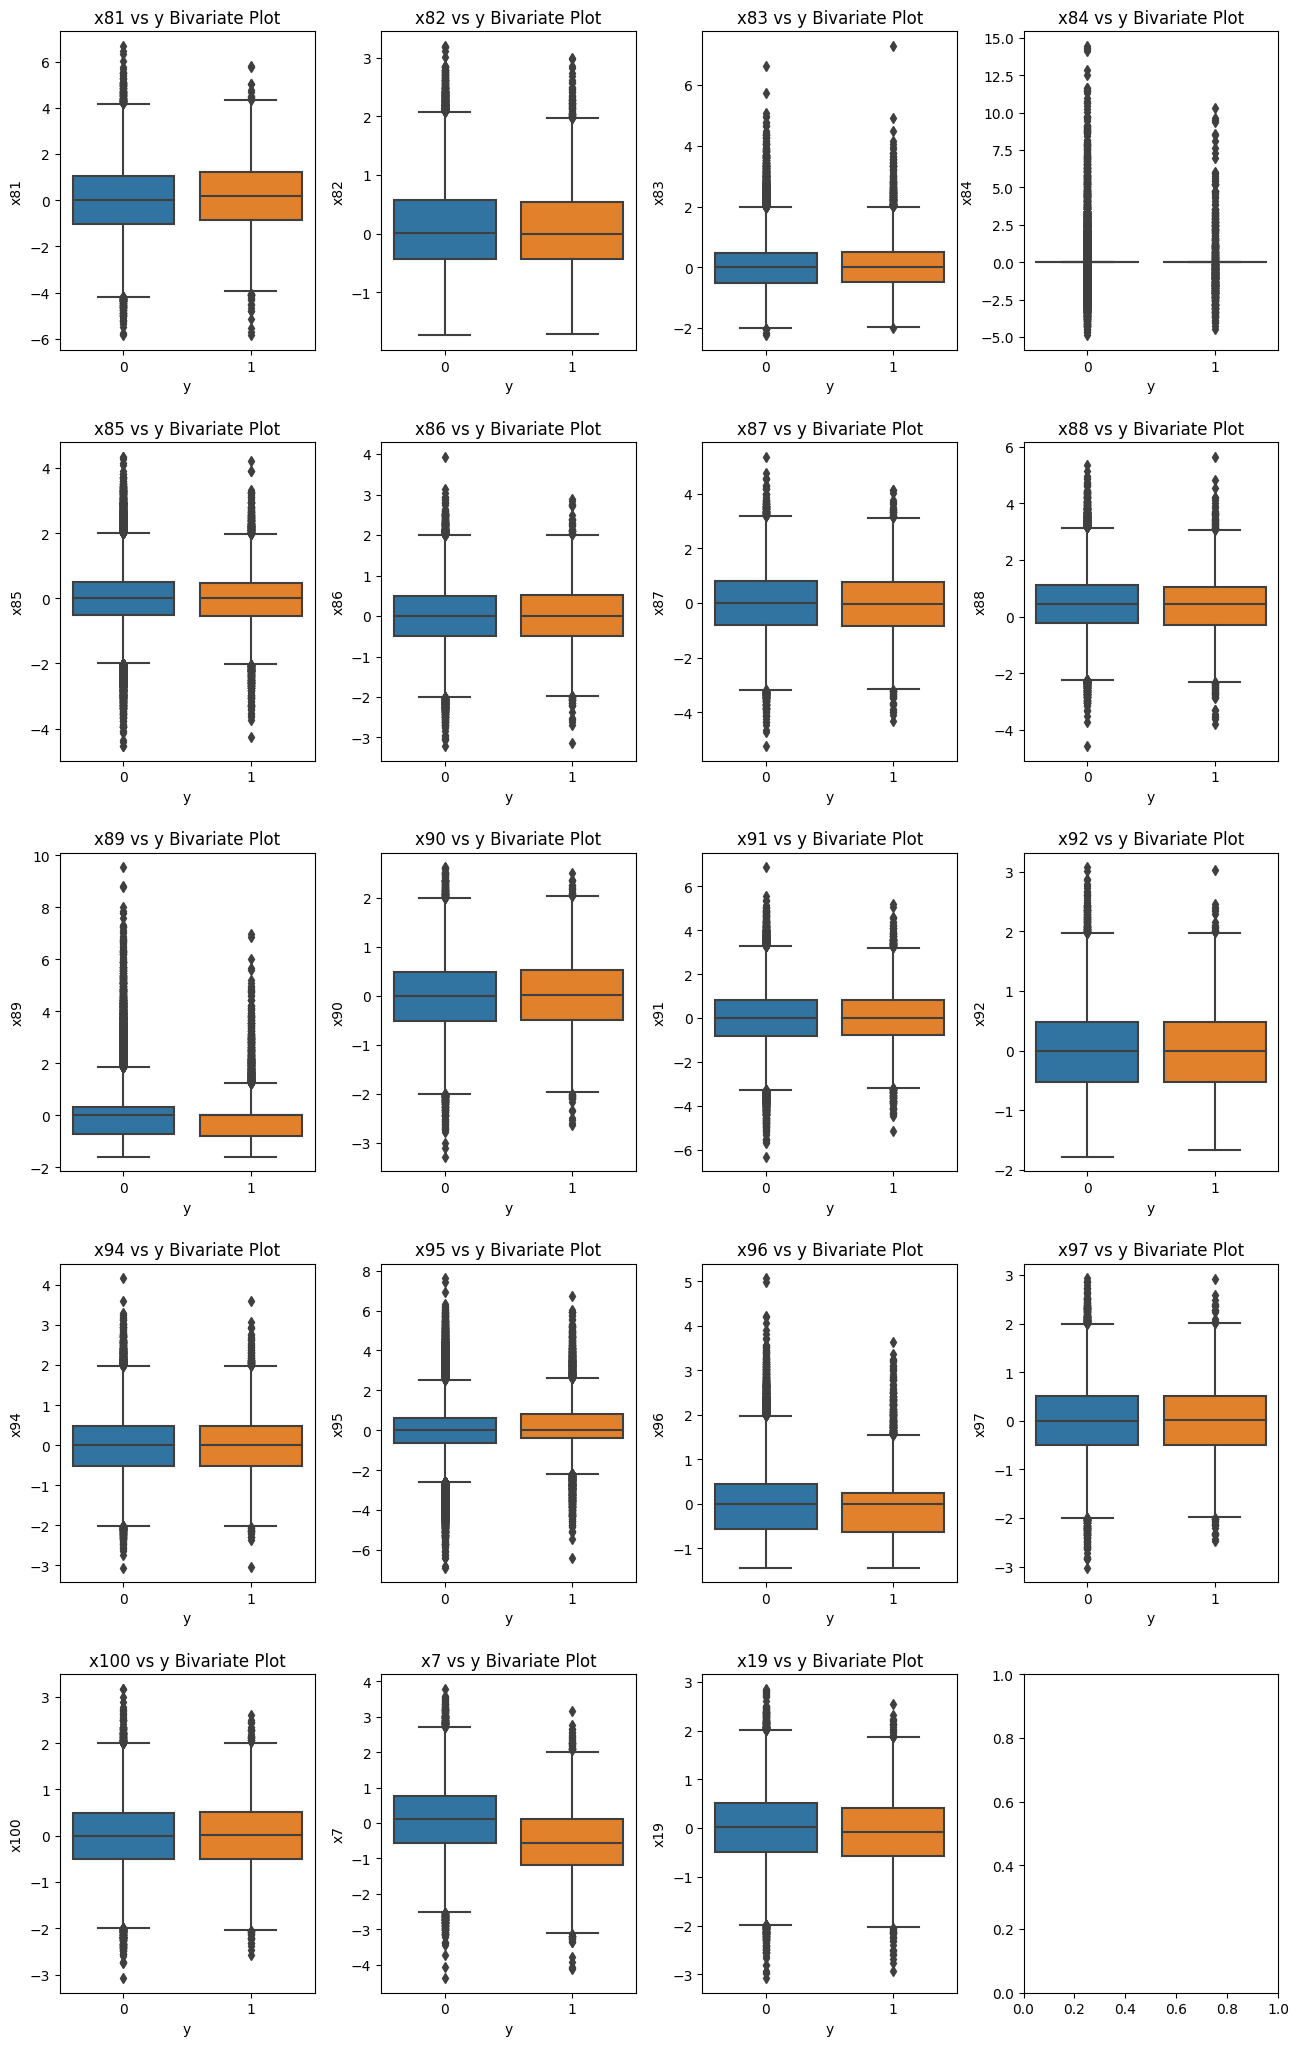

In [44]:
def bivariate_plot_for_numerical_variables(
    df,
    numerical_columns,
    outcome_variable,
    n_cols,
    figsize_x=5,
    figsize_y=6,
    top_in_betweeen_subplot_spacing=2.0,
    order=None,
):
    if outcome_variable in numerical_columns:
        numerical_columns.remove(outcome_variable)

    row_idx, col_idx = 0, 0
    n_rows = int(np.ceil(len(numerical_columns) / n_cols))
    # print(f' n_rows {n_rows} n_cols {n_cols}')
    fig, axs = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(figsize_x, figsize_y))
    fig.tight_layout()
    plt.subplots_adjust(top=top_in_betweeen_subplot_spacing)

    for i, col in enumerate(numerical_columns):
        no_of_plots = i + 1
        # print(row_idx, col_idx, no_of_plots, col)
        cur_row_col_axes = axs[row_idx] if n_cols == 1 else axs[row_idx][col_idx]
        feature, target = col, outcome_variable
        g = sns.boxplot(data=df, x="y", y=col, ax=cur_row_col_axes)
        # g = sns.distplot(df[col][df[outcome_variable] == 1], ax=cur_row_col_axes)
        # g = sns.distplot(df[col][df[outcome_variable] == 0], ax=cur_row_col_axes)
        g.set(title=f"{col} vs {outcome_variable} Bivariate Plot")

        col_idx += 1
        if no_of_plots % n_cols == 0:
            row_idx += 1
            col_idx = 0


bivariate_plot_for_numerical_variables(
    train_df, numerical_columns[0:32], "y", n_cols=4, figsize_x=13, figsize_y=10, top_in_betweeen_subplot_spacing=2.0
)
bivariate_plot_for_numerical_variables(
    train_df, numerical_columns[32:64], "y", n_cols=4, figsize_x=13, figsize_y=10, top_in_betweeen_subplot_spacing=2.0
)
bivariate_plot_for_numerical_variables(
    train_df, numerical_columns[64:], "y", n_cols=4, figsize_x=13, figsize_y=10, top_in_betweeen_subplot_spacing=2.0
)


## 4. Modeling

### 4.1 Dataset creation:  Train/ Validation Data
- Split Train Data into Train/ Validation Data - 70-30%



In [45]:
## Sanity Check
# Test_df does not have outcome variable (y column)
assert len(train_df.columns) == len(test_df.columns) + 1


## DataSet Creation
def get_stratified_data(X_df, y_series, test_size=0.2, verbose=False, seed=4):
    from sklearn.model_selection import StratifiedShuffleSplit

    feature_cols = list(X_df.columns)
    # target_col = y_df.columns

    X = np.array(X_df)
    y = np.array(y_series)

    sss = StratifiedShuffleSplit(n_splits=2, test_size=test_size, random_state=seed)
    sss.get_n_splits(X, y)

    for train_index, test_index in sss.split(X, y):
        if verbose:
            print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

    X_train = pd.DataFrame(X_train, columns=feature_cols)
    X_test = pd.DataFrame(X_test, columns=feature_cols)

    y_train = pd.DataFrame(y_train)
    y_test = pd.DataFrame(y_test)

    if verbose:
        print(f"\n ...No. of Training Data : {len(X_train)}")
        print(f" ...No. of Test Data     : {len(X_test)}")
        print(f" ...No. of Features : {len(X_train.columns)}")
        print(f" ...Train Bincount : {np.bincount(y_train[0])}")
        print(f" ...Test Bincount  : {np.bincount(y_test[0])}")

    return X_train, y_train, X_test, y_test


feature_columns = list(train_df.columns)
feature_columns.remove("y")
# feature_columns
X_all = train_df[feature_columns]
y_all = train_df["y"]

X_train, y_train, X_valid, y_valid = get_stratified_data(X_all, y_all, test_size=0.2, verbose=True)


assert (
    X_train.isnull().sum().sum() == 0
), "ERROR: Missing values has cripped up during preprocessing. Invetigate and Fix"


TRAIN: [  309 29661 12802 ... 39161 36620  6392] TEST: [25266 37182  8592 ... 14682 15691 39481]
TRAIN: [24571 16075  2874 ... 33494 11280 34824] TEST: [ 2283  9365 11857 ... 28712 39145 16578]

 ...No. of Training Data : 32000
 ...No. of Test Data     : 8000
 ...No. of Features : 171
 ...Train Bincount : [27358  4642]
 ...Test Bincount  : [6839 1161]


#### 4.1.1 Dataset creation:  Synthetic Balanced Data
We will create a synthtically balanced train dataset and use them later to test Data balanced vs non-balanced models later.


In [51]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=4)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)
print("[0class 1class] =  ", np.bincount(y_train_smote[0]))


[0class 1class] =   [27358 27358]


### 4.2 Evaluation Metric Selection:

- Accuracy is a bad Evaluation metric given  highly imbalanced nature of Data.
- We will choose AUC, recall, F1-score and additionally use confusion matrix. 
- Recall : Ability of model to find all positive classes
- Precision : Ability of model to not label as positive a sample that is negative.
- Balanced accuracy : avg of recall across all classes.


In [46]:
from sklearn.model_selection import cross_validate

scoring = ["roc_auc", "recall", "precision", "accuracy", "balanced_accuracy", "f1"]

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from typing import List
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn import tree
from sklearn.model_selection import cross_validate


# Defining the confusion matrix function
def plot_confusion_matrix(cm, class_labels, title="Confusion matrix", cmap=plt.cm.Blues):
    import itertools

    plt.figure(figsize=(3, 3))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_labels))
    plt.xticks(tick_marks, class_labels, rotation=45)
    plt.yticks(tick_marks, class_labels)

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()


def area_under_roc(y, pred):
    from sklearn import metrics

    # fpr,tpr, thresholds = metrics.roc_curve(y, pred, pos_label=2 )
    auc = metrics.roc_auc_score(y, pred)
    # print('fpr,tpr, AUC (higher is better)', fpr, tpr, auc)
    print("AUC (higher is better)", auc)
    return auc


def eval_classification(
    y_test,
    ypred_test,
    class_labels=["Retained", "Churn - Lost"],
    title="Confusion Matrix",
    metrics=["confusion_matrix"],
):
    returned_metrics = []

    if "auc" in metrics:
        auc = area_under_roc(y_test, ypred_test)
        returned_metrics.append(auc)
    if "confusion_matrix" in metrics:
        print("Confusion report is")
        print(classification_report(y_test, ypred_test))
        conf_matrix = confusion_matrix(y_test, ypred_test)
        plot_confusion_matrix(conf_matrix, class_labels=class_labels, title=title)
        returned_metrics.append(conf_matrix)

    return returned_metrics[0] if len(returned_metrics) == 1 else returned_metrics


def plot_roc(y_test: List[int], y_test_proba: List[float]):
    auc = roc_auc_score(y_test, y_test_proba)
    print("Logistic: ROC AUC=%.3f" % (auc))

    # # keep probabilities for the positive outcome only
    # probability_positive_class = y_test_proba[:, 1]
    probability_positive_class = y_test_proba

    fpr, tpr, _ = roc_curve(y_test, probability_positive_class)

    pyplot.plot(fpr, tpr, marker=".", label="")
    pyplot.title("ROC Curve")
    pyplot.xlabel("False Positive Rate (False Alarm Rate)")
    pyplot.ylabel("True Positive Rate ( Sensitivity, Hit Rate)")
    pyplot.legend()
    pyplot.show()


def plot_roc_for_binary_prediction_label(y_test, y_test_prediction):
    from plot_metric.functions import BinaryClassification

    bc = BinaryClassification(y_test, y_test_prediction, labels=["Class 1", "Class 2"])
    # Figures
    plt.figure(figsize=(5, 5))
    bc.plot_roc_curve()
    plt.show()


def create_new_score_tracker_df(scoring):
    score_tracker_dict = {"model_name": []}
    scores = {}
    for cur_scoring in scoring:
        score_tracker_dict.update({cur_scoring: []})

    score_tracker_df = pd.DataFrame(score_tracker_dict)
    return score_tracker_df


def add_cv_score_to_df(df, model_descriptor_name, scoring, cur_clf_cv_result):
    cur_scores = {"model_name": model_descriptor_name}
    for cur_scoring in scoring:
        cur_scores.update({cur_scoring: round(cur_clf_cv_result["test_" + cur_scoring].mean(), 2)})

    df = df.append(cur_scores, ignore_index=True)
    df = df.drop_duplicates(keep="last")
    return df


def get_cv_scores(clf, model_descriptor_name, X, y, scoring, score_tracker_df=None, cv_fold=5):
    # Create Score tracker df if first run
    if score_tracker_df is None:
        print("Created New Score Tracker")
        score_tracker_df = create_new_score_tracker_df(scoring)

    cur_clf_cv_result = cross_validate(clf, X, y, cv=cv_fold, scoring=scoring)
    score_tracker_df = add_cv_score_to_df(score_tracker_df, model_descriptor_name, scoring, cur_clf_cv_result)

    return score_tracker_df


def get_benchmark_cv_scores(clf, x_columns, df, model_name, score_tracker_df=None):
    if x_columns is None:
        x_columns = list(df.columns)
        x_columns.remove("y")
    print(f" Columns : {len(x_columns)}")
    cur_X_train, cur_y_train, _, _ = get_stratified_data(df[x_columns], df["y"], test_size=0.01, seed=4)
    score_tracker_df = get_cv_scores(
        clf=clf,
        X=cur_X_train,
        y=cur_y_train,
        cv_fold=5,
        scoring=scoring,
        model_descriptor_name=model_name,
        score_tracker_df=score_tracker_df,
    )
    return score_tracker_df


def get_clasifier_evaluation(clf, X_train=X_train, y_train=y_train, X_valid=X_valid, y_valid=y_valid):
    clf.fit(X_train, y_train)
    y_pred_valid = clf.predict(X_valid)
    eval_classification(y_valid, y_pred_valid, class_labels=["no", "yes"], metrics=["auc", "confusion_matrix"])


def simple_tree(
    X_trainR,
    y_trainR,
    X_testR,
    y_testR,
    max_depth=None,
    class_weight=None,
    class_labels=["yes", "no"],
    metrics=["confusion_matrix"],
):
    from sklearn import tree

    clf = tree.DecisionTreeClassifier(max_depth=max_depth, class_weight=class_weight)
    clf.fit(X_trainR, y_trainR)
    ypred_testR = clf.predict(X_testR)

    eval_classification(y_testR, ypred_testR, class_labels=class_labels, metrics=metrics)
    return clf


### 4.3 Benchmark Model: Tree Based

#### 4.3.1 Simple Tree


TRAIN: [  309 29661 12802 ... 39161 36620  6392] TEST: [25266 37182  8592 ... 14682 15691 39481]
TRAIN: [24571 16075  2874 ... 33494 11280 34824] TEST: [ 2283  9365 11857 ... 28712 39145 16578]

 ...No. of Training Data : 32000
 ...No. of Test Data     : 8000
 ...No. of Features : 171
 ...Train Bincount : [27358  4642]
 ...Test Bincount  : [6839 1161]
AUC (higher is better) 0.5717218304754903
Confusion report is
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      6839
           1       0.26      0.28      0.27      1161

    accuracy                           0.78      8000
   macro avg       0.57      0.57      0.57      8000
weighted avg       0.79      0.78      0.78      8000



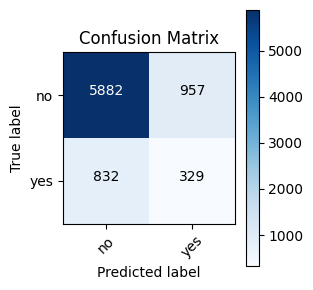

In [47]:
train_df_no_preproces = ckpt_train_df_pre_scaling.copy()
feature_columns = list(train_df_no_preproces.columns)
feature_columns.remove("y")
feature_columns
X_all_no_preprocess = train_df_no_preproces[feature_columns]
y_all_no_preprocess = train_df_no_preproces["y"]

X_train_no_preprocess, y_train_no_preprocess, X_valid_no_preprocess, y_valid_no_preprocess = get_stratified_data(
    X_all_no_preprocess, y_all_no_preprocess, test_size=0.2, verbose=True
)


simple_tree_clf = simple_tree(
    X_train_no_preprocess,
    y_train_no_preprocess,
    X_valid_no_preprocess,
    y_valid_no_preprocess,
    class_weight=None,
    class_labels=["no", "yes"],
    metrics=["auc", "confusion_matrix"],
)


In [48]:
scoring = ["roc_auc", "recall", "precision", "accuracy", "balanced_accuracy", "f1" ]
score_tracker_df = get_cv_scores(
    clf=tree.DecisionTreeClassifier(max_depth=None, class_weight=None),
    X=X_train,
    y=y_train,
    cv_fold=5,
    scoring=scoring,
    model_descriptor_name="Simple Tree Unbalanced",
    score_tracker_df=None,
)
score_tracker_df = get_cv_scores(
    clf=tree.DecisionTreeClassifier(max_depth=None, class_weight="balanced"),
    X=X_train,
    y=y_train,
    cv_fold=5,
    scoring=scoring,
    model_descriptor_name="Simple Tree balanced",
    score_tracker_df=score_tracker_df,
)
score_tracker_df

Created New Score Tracker


model_name  roc_auc  recall  precision  accuracy  \
0  Simple Tree Unbalanced     0.56    0.27       0.25      0.77   
1    Simple Tree balanced     0.56    0.26       0.25      0.78   

   balanced_accuracy    f1  
0               0.56  0.26  
1               0.56  0.26

#### 4.3.1 Boosted Trees
- AdaBoost
- Gradient Boost :
    - Gradient Boosting is fairly robust to over-fitting, hence large n_estimators is preferable.
- XgBoost
    - XGBoost Tree Params :
        - max_depth: Larger value, more complex model  and hence overfitting potential.
        - lambda : l2 regularissation strength. Higher value  reduces model complexity (undefitting)
        - sampling_method: gradient_based(non-uniform)
        - eta: learning_rate : larger eta, less model complexity.

In [49]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

# from sklearn.ensemble import RandomForestClassifier
# random_forest_clf = RandomForestClassifier(n_estimators=200, class_weight='balanced')

ada_boost_clf = AdaBoostClassifier(n_estimators=100, learning_rate=1.5, random_state=40)
score_tracker_df = get_benchmark_cv_scores(
    ada_boost_clf, None, train_df, "Boosted Tree (AdaBoost)-LR_1.5", score_tracker_df
)

ada_boost_clf = AdaBoostClassifier(n_estimators=100, learning_rate=1.7, random_state=40)
score_tracker_df = get_benchmark_cv_scores(
    ada_boost_clf, None, train_df, "Boosted Tree (AdaBoost)-LR_1.7", score_tracker_df
)

gradient_boost_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.5, random_state=40)
score_tracker_df = get_benchmark_cv_scores(
    gradient_boost_clf, None, train_df, "Boosted Tree (GradientBoost)-n_estimator_100-LR_1.5", score_tracker_df
)

xgb = XGBClassifier()
score_tracker_df = get_benchmark_cv_scores(xgb, None, train_df, "XGB-",score_tracker_df)

score_tracker_df


 Columns : 171
 Columns : 171
 Columns : 171


model_name  roc_auc  recall  \
0                             Simple Tree Unbalanced     0.56    0.27   
1                               Simple Tree balanced     0.56    0.26   
2                     Boosted Tree (AdaBoost)-LR_1.5     0.79    0.22   
3                     Boosted Tree (AdaBoost)-LR_1.7     0.79    0.23   
4  Boosted Tree (GradientBoost)-n_estimator_100-L...     0.72    0.23   

   precision  accuracy  balanced_accuracy    f1  
0       0.25      0.77               0.56  0.26  
1       0.25      0.78               0.56  0.26  
2       0.53      0.86               0.59  0.31  
3       0.51      0.86               0.60  0.32  
4       0.37      0.83               0.58  0.28

#### 4.3.2 Boosted Trees : With SMOTE


AUC (higher is better) 0.5865221240242068
Confusion report is
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      6839
           1       0.42      0.22      0.29      1161

    accuracy                           0.84      8000
   macro avg       0.65      0.59      0.60      8000
weighted avg       0.81      0.84      0.82      8000



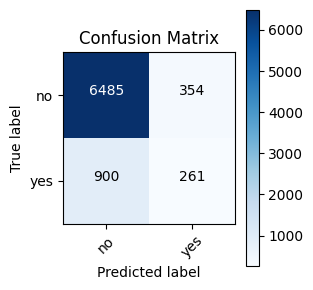

In [52]:
ada_boost_clf = AdaBoostClassifier(n_estimators=100, learning_rate=1.7, random_state=40)
get_clasifier_evaluation(ada_boost_clf, X_train_smote, y_train_smote, X_valid, y_valid)



#### 4.4 Logistic Regression Modeling
- Params :
    - Smaller C ~ stronger regularisation like in SVM / SVC.



In [53]:
lr_clf = LogisticRegression(penalty="l2", C=0.01, class_weight="balanced")
score_tracker_df = get_benchmark_cv_scores(lr_clf, None, train_df, "LR-l2-0.01", score_tracker_df)

lr_clf = LogisticRegression(penalty="l2", C=1.01, class_weight="balanced")
score_tracker_df = get_benchmark_cv_scores(lr_clf, None, train_df, "LR-l2-1", score_tracker_df)

lr_clf = LogisticRegression(penalty="l1", solver="saga", C=0.1, class_weight="balanced")
score_tracker_df = get_benchmark_cv_scores(lr_clf, None, train_df, "LR-l1-0.1", score_tracker_df)

# lr_clf = LogisticRegression(penalty="l2", solver="liblinear", C=0.001, class_weight="balanced")
lr_clf = LogisticRegression(penalty="l1", solver="saga", C=0.1, class_weight="balanced")
score_tracker_df = get_benchmark_cv_scores(lr_clf, None, train_df, "LR-l1-0.1-SMOTE", score_tracker_df)


score_tracker_df


 Columns : 171
 Columns : 171
 Columns : 171
 Columns : 171


model_name  roc_auc  recall  \
0                             Simple Tree Unbalanced     0.56    0.27   
1                               Simple Tree balanced     0.56    0.26   
2                     Boosted Tree (AdaBoost)-LR_1.5     0.79    0.22   
3                     Boosted Tree (AdaBoost)-LR_1.7     0.79    0.23   
4  Boosted Tree (GradientBoost)-n_estimator_100-L...     0.72    0.23   
5                                         LR-l2-0.01     0.76    0.69   
6                                            LR-l2-1     0.76    0.69   
7                                          LR-l1-0.1     0.76    0.70   
8                                    LR-l1-0.1-SMOTE     0.76    0.70   

   precision  accuracy  balanced_accuracy    f1  
0       0.25      0.77               0.56  0.26  
1       0.25      0.78               0.56  0.26  
2       0.53      0.86               0.59  0.31  
3       0.51      0.86               0.60  0.32  
4       0.37      0.83               0.58  0.28  
5       0.27      0.69               0.69  0.39  
6       0.27      0.69               0.69  0.39  
7       0.27      0.68               0.69  0.39  
8       0.27      0.68               0.69  0.39

AUC (higher is better) 0.6991591015656141
Confusion report is
              precision    recall  f1-score   support

           0       0.93      0.68      0.79      6839
           1       0.28      0.72      0.40      1161

    accuracy                           0.69      8000
   macro avg       0.61      0.70      0.59      8000
weighted avg       0.84      0.69      0.73      8000



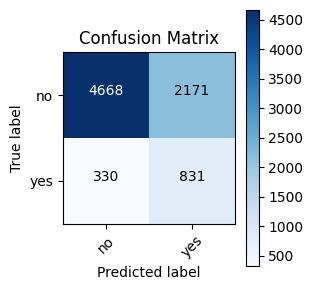

In [55]:
get_clasifier_evaluation(lr_clf, X_train, y_train, X_valid, y_valid)

#### 4.4.1 Logistic Regression: Test Prediction 
- We will now train on the full dataset rather than on train set only.  Then we will make final  probability prediction on X_test and write it to a file

In [54]:
# glmresults
def write_yes_probability_to_a_file(predict_probability, file_name):
    class_1_probability_df = pd.DataFrame(columns=["class_1_probability"])

    for i, class_proba in enumerate(predict_probability):
        _, one_proba = class_proba[0], class_proba[1]
        class_1_probability_df.loc[i] = round(one_proba, 4)

    class_1_probability_df.to_csv(file_name, header=None, index=None)
    return class_1_probability_df


feature_columns = list(train_df.columns)
feature_columns.remove("y")
X_all = train_df[feature_columns]
y_all = train_df["y"]

lr_clf = LogisticRegression(penalty="l1", solver="saga", C=0.1, class_weight="balanced")
lr_clf.fit(X_all, y_all)
y_test_predicted = lr_clf.predict_proba(test_df)

write_yes_probability_to_a_file(y_test_predicted, "Data/glmresults.csv")


class_1_probability
0                  0.1428
1                  0.2696
2                  0.7541
3                  0.4711
4                  0.0735
...                   ...
9995               0.1327
9996               0.6153
9997               0.4840
9998               0.6394
9999               0.1248

[10000 rows x 1 columns]

#### 4.5 Deep Neural Networks Modeling
- We will use Keras here because Sklearn only provides a single layer simple NN and more importantly it lacks GPU support. Both of which are addressed by Keras.
- Class Weights : 
    - Because we have highly imbalanced data, we will use class_weights 
-  Training Data :
    

In [61]:
def plot_loss(history, label, n):
    # Use a log scale on y-axis to show the wide range of values.
    plt.semilogy(history.epoch, history.history["loss"], label="Train " + label)
    plt.semilogy(history.epoch, history.history["val_loss"], label="Val " + label, linestyle="--")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")


def plot_metrics(history, metrics=["loss", "recall", "precision"]):
    for n, metric in enumerate(metrics):
        name = metric.replace("_", " ").capitalize()
        plt.subplot(2, 2, n + 1)
        plt.plot(history.epoch, history.history[metric], label="Train")
        plt.plot(history.epoch, history.history["val_" + metric], linestyle="--", label="Val")
        plt.xlabel("Epoch")
        plt.ylabel(name)
        plt.ylim([plt.ylim()[0] - 0.1, plt.ylim()[1]])
        plt.legend()
    plt.show()


def print_auc(train_history, at_epoch):
    print(f"Training AUC at epoch {at_epoch} :  {train_history.history['auc'][at_epoch]}")
    print(f"Validation AUC at epoch {at_epoch} :  {train_history.history['val_auc'][at_epoch]}")


def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion matrix @{:.2f}".format(p))
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")
    plt.show()

    print("Legitimate TrueClass Detected (True Negatives): ", cm[0][0])
    print("Legitimate TrueClass Incorrectly Detected (False Positives): ", cm[0][1])
    print("Fraudulent TrueClass Missed (False Negatives): ", cm[1][0])
    print("Fraudulent TrueClass Detected (True Positives): ", cm[1][1])
    print("Total FalseClass: ", np.sum(cm[1]))


import sklearn


def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

    plt.plot(100 * fp, 100 * tp, label=name, linewidth=2, **kwargs)
    plt.xlabel("False positives (False Alarm Rate) [%]")
    plt.ylabel("True positives ( Sensitivity, Hit Rate) [%]")
    plt.xlim([-0.5, 100])
    plt.ylim([0, 100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect("equal")


def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(recall, precision, label=name, linewidth=2, **kwargs)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect("equal")


def plot_hist_of_predictions(train_features, train_labels, test_features, clf_model, batch_size=128):
    train_predictions = model_dnn.predict(train_features, batch_size=batch_size)
    test_predictions = model_dnn.predict(test_features, batch_size=batch_size)

    predictions_df = pd.DataFrame({"Prediction": train_predictions.ravel(), "Label": train_labels.ravel()})
    predictions_df = pd.concat(
        [
            predictions_df[predictions_df["Label"] == 0].sample(5000, random_state=0),
            predictions_df[predictions_df["Label"] == 1].sample(500, random_state=0),
        ]
    )
    import plotly.express as px

    fig = px.histogram(
        predictions_df,
        x="Prediction",
        title="Prediction values",
        color="Label",
        marginal="box",
        labels={"0": "NoClass", "1": "YesClass"},
    )
    fig.update_traces(opacity=0.75)
    fig.update_layout(barmode="overlay")
    fig.show()


Weight for class no: 0.58
Weight for class yes: 3.45
Output layer Bias for faster/ better convergence : [-1.77386368]
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 64)                11008     
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 128)               8320      
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 19,457
Trainable params: 19,457
Non-trainable params: 

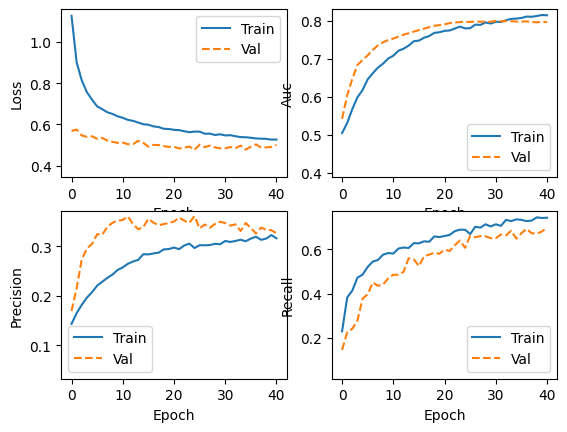

63/63 [==============================] - 0s 637us/step


In [62]:
from tensorflow.keras import Sequential
from tensorflow.keras.metrics import AUC, Recall, Precision, BinaryAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.initializers import Constant
from tensorflow.keras.losses import SquaredHinge, BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping


def create_nn_model(no_of_features, learning_rate=0.001, output_layer_bias=None):
    METRICS = [
        AUC(name="auc", from_logits=True),
        Recall(name="recall"),
        Precision(name="precision"),
        BinaryAccuracy(name="BinaryAccuracy"),  # Accuracy for True Class
        AUC(name="prc", curve="PR"),
    ]
    # For imbalanced Data, we want to add intial bias for better convergence at the output layer
    if output_layer_bias is not None:
        output_layer_bias = Constant(output_layer_bias)

    model = Sequential(
        [
            Dense(64, activation="relu", input_shape=(no_of_features,)),  # input_layer
            Dropout(0.5),
            Dense(128, activation="relu"),  # hidden_layer
            Dropout(0.5),
            Dense(1, activation="sigmoid", bias_initializer=output_layer_bias),  # output_layer
        ]
    )

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=BinaryCrossentropy(), metrics=METRICS)
    return model


# Transform DataFrame in Numpy array, as expected by Keras NN models down the line
X_train_np_arr = np.array(X_train)
y_train_np_arr = np.array(y_train)
X_valid_np_arr = np.array(X_valid)
y_valid_np_arr = np.array(y_valid)
X_train_smote_np_arr = np.array(X_train_smote)
y_train_smote_np_arr = np.array(y_train_smote)


##  Imbalanced Data Handling:
# Class Weight
no_of_features = X_train_np_arr.shape[-1]
yes_class_count = sum(y_train_np_arr)[0]
no_class_count = len(y_train_np_arr) - yes_class_count
total = no_class_count + yes_class_count
# total /2.0 to ensure losses for both classes get equal importance
weight_for_yes = (1 / yes_class_count) * (total / 2.0)
weight_for_no = (1 / no_class_count) * (total / 2.0)
class_weight = {0: weight_for_no, 1: weight_for_yes}
print("Weight for class no: {:.2f}".format(weight_for_no))
print("Weight for class yes: {:.2f}".format(weight_for_yes))
output_layer_bias = np.log([yes_class_count / no_class_count])
print(f"Output layer Bias for faster/ better convergence : {output_layer_bias}")


early_stopping = EarlyStopping(monitor="val_auc", verbose=1, patience=10, mode="max", restore_best_weights=True)


model_dnn = create_nn_model(no_of_features, learning_rate=0.001, output_layer_bias=output_layer_bias)
model_dnn.summary()
train_history = model_dnn.fit(
    X_train_np_arr,
    y_train_np_arr,
    validation_data=(X_valid_np_arr, y_valid_np_arr),
    batch_size=1024,
    epochs=500,
    callbacks=[early_stopping],
    class_weight=class_weight,
    verbose=0,
)
y_valid_dnn_predicted = model_dnn.predict(X_valid_np_arr, batch_size=8024)
print_auc(train_history, 36)
plot_metrics(train_history, metrics=["loss", "auc", "precision", "recall"])
plot_hist_of_predictions(X_train_np_arr, y_train_np_arr, X_valid_np_arr, model_dnn)


In [63]:
print_auc(train_history, 31)
# print_auc(train_history, 97)
# print_auc(train_history, 113)

Training AUC at epoch 31 :  0.7961822748184204
Validation AUC at epoch 31 :  0.7982476949691772


##### 4.5.1 DNN with smote
- Because we are using class_weights, smote is observed to have not much positive impact on the model performance improvement

Restoring model weights from the end of the best epoch: 66.
Epoch 76: early stopping
Training AUC at epoch 50 :  0.7951669096946716
Validation AUC at epoch 50 :  0.7849267721176147


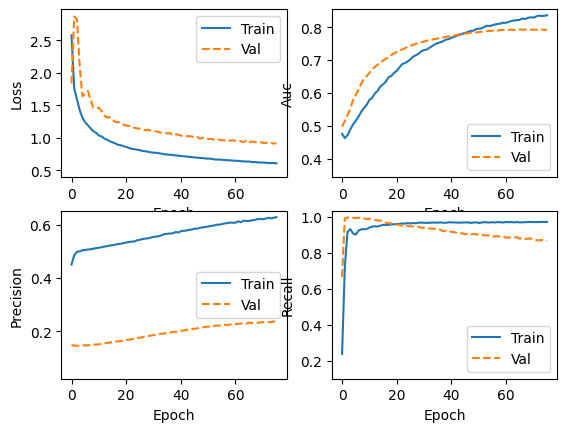

In [64]:
model_smote = create_nn_model(no_of_features, learning_rate=0.001, output_layer_bias=output_layer_bias)
train_history_smote = model_smote.fit(X_train_smote_np_arr, y_train_smote_np_arr,          
          validation_data=(X_valid_np_arr, y_valid_np_arr),
          batch_size=8024, epochs=500, callbacks=[early_stopping], class_weight=class_weight,
          verbose=0
          )
print_auc(train_history_smote, 50)
plot_metrics(train_history_smote, metrics=['loss', 'auc', 'precision', 'recall'])

##### 4.5.2 DNN with Categorical Cross-entropy:
- We transformed the binary representation of (0/1) into dummy representation [0,1] and trained with categorical cross-entropy loss.

Weight for class no: 0.58
Weight for class yes: 3.45
Output layer Bias for faster/ better convergence : [-1.77386368]
Restoring model weights from the end of the best epoch: 543.
Epoch 593: early stopping


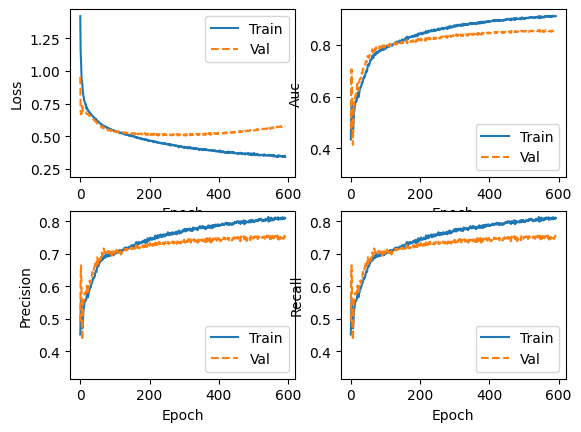

In [83]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.metrics import AUC, Recall, Precision, BinaryAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.initializers import Constant
from tensorflow.keras.losses import (
    SquaredHinge,
    BinaryCrossentropy,
    SparseCategoricalCrossentropy,
    CategoricalCrossentropy,
)
from tensorflow.keras.callbacks import EarlyStopping


def create_nn_model(no_of_features, learning_rate=0.001, output_layer_bias=None):
    METRICS = [
        AUC(name="auc", from_logits=True),
        Recall(name="recall"),
        Precision(name="precision"),
        BinaryAccuracy(name="BinaryAccuracy"),  # Accuracy for True Class
    ]
    # For imbalanced Data, we want to add intial bias for better convergence at the output layer
    if output_layer_bias is not None:
        output_layer_bias = Constant(output_layer_bias)

    model = Sequential(
        [
            Dense(64, activation="relu", input_shape=(no_of_features,)),  # input_layer
            Dropout(0.5),
            Dense(128, activation="relu"),  # hidden_layer
            Dropout(0.5),
            Dense(2, activation="softmax", name="predictions", bias_initializer=output_layer_bias),  # output_layer
        ]
    )

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        #   loss=BinaryCrossentropy(),
        loss=CategoricalCrossentropy(),
        metrics=METRICS,
    )
    return model


# Transform DataFrame in Numpy array, as expected by Keras NN models down the line
X_train_np_arr = np.array(X_train)
y_train_np_arr = np.array(y_train)
X_valid_np_arr = np.array(X_valid)
y_valid_np_arr = np.array(y_valid)
X_train_smote_np_arr = np.array(X_train_smote)
y_train_smote_np_arr = np.array(y_train_smote)
y_train_np_arr_cross_entropy = tf.one_hot(y_train_np_arr, depth=2)
y_valid_np_arr_cross_entropy = tf.one_hot(y_valid_np_arr, depth=2)
y_train_np_arr_cross_entropy = tf.reshape(y_train_np_arr_cross_entropy, [y_train_np_arr_cross_entropy.shape[0], 2])
y_valid_np_arr_cross_entropy = tf.reshape(y_valid_np_arr_cross_entropy, [y_valid_np_arr_cross_entropy.shape[0], 2])


##  Imbalanced Data Handling:
# Class Weight
yes_class_count = sum(y_train_np_arr)[0]
no_class_count = len(y_train_np_arr) - yes_class_count
total = no_class_count + yes_class_count
weight_for_yes = (1 / yes_class_count) * (total / 2.0) # total /2.0 to ensure losses for both classes get equal importance
weight_for_no = (1 / no_class_count) * (total / 2.0)
class_weight = {0: weight_for_no, 1: weight_for_yes}
print("Weight for class no: {:.2f}".format(weight_for_no))
print("Weight for class yes: {:.2f}".format(weight_for_yes))

output_layer_bias = np.log([yes_class_count / no_class_count])
print(f"Output layer Bias for faster/ better convergence : {output_layer_bias}")


early_stopping = EarlyStopping(monitor="val_auc", verbose=1, patience=50, mode="max", restore_best_weights=True)

no_of_features = X_train_np_arr.shape[-1]
model_dnn_cross_entropy = create_nn_model(no_of_features, learning_rate=0.001, output_layer_bias=output_layer_bias)
# model_dnn.summary()
train_history_cross_entropy = model_dnn_cross_entropy.fit(
    X_train_np_arr,
    y_train_np_arr_cross_entropy,
    validation_data=(X_valid_np_arr, y_valid_np_arr_cross_entropy),
    batch_size=8024,
    epochs=1000,
    callbacks=[early_stopping],
    class_weight=class_weight,
    verbose=0,
)
plot_metrics(train_history_cross_entropy, metrics=["loss", "auc", "precision", "recall"])


In [84]:
print_auc(train_history_cross_entropy, 40)
print_auc(train_history_cross_entropy, 100)
print_auc(train_history_cross_entropy, 150)
print_auc(train_history_cross_entropy, 200)
print_auc(train_history_cross_entropy, 300)
print_auc(train_history_cross_entropy, 479)

Training AUC at epoch 40 :  0.6763357520103455
Validation AUC at epoch 40 :  0.7207580208778381
Training AUC at epoch 100 :  0.7909448146820068
Validation AUC at epoch 100 :  0.7973334789276123
Training AUC at epoch 150 :  0.8180625438690186
Validation AUC at epoch 150 :  0.8116292357444763
Training AUC at epoch 200 :  0.8442750573158264
Validation AUC at epoch 200 :  0.8179750442504883
Training AUC at epoch 300 :  0.8768588304519653
Validation AUC at epoch 300 :  0.8394731283187866
Training AUC at epoch 479 :  0.9038078784942627
Validation AUC at epoch 479 :  0.8530420064926147


### 4.6 Final Model Selection :  Deep Neural Networks
- Based on the AUc score on the Evaluation Dataset, we selected two models
    - Model 1: Logistic Regression : 
            - Validation AUC  :  0.7
    - Model 2: NN(1 hidden layer with class weighting and output layer bias applied) - without SMOTE Data Balancing
        - AUC Score :  
            - Training AUC at epoch 479    :  0.91
            - Validation AUC at epoch 479 :  0.86

1/1 [==============================] - 0s 16ms/step


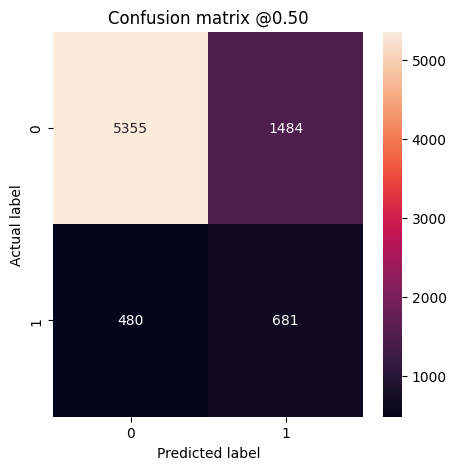

Legitimate TrueClass Detected (True Negatives):  5355
Legitimate TrueClass Incorrectly Detected (False Positives):  1484
Fraudulent TrueClass Missed (False Negatives):  480
Fraudulent TrueClass Detected (True Positives):  681
Total FalseClass:  1161


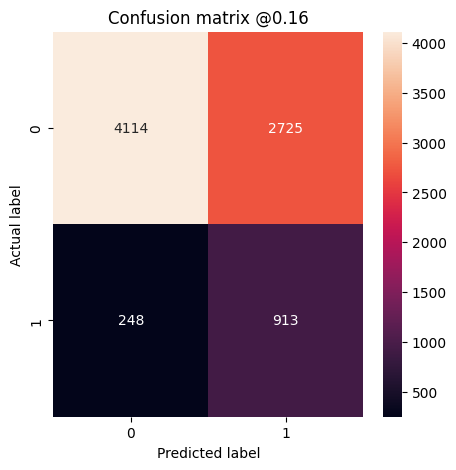

Legitimate TrueClass Detected (True Negatives):  4114
Legitimate TrueClass Incorrectly Detected (False Positives):  2725
Fraudulent TrueClass Missed (False Negatives):  248
Fraudulent TrueClass Detected (True Positives):  913
Total FalseClass:  1161


In [85]:
y_train_predicted_crossentropy = model_dnn_cross_entropy.predict(X_train_np_arr, batch_size=8024)
y_valid_predicted_crossentropy = model_dnn_cross_entropy.predict(X_valid_np_arr, batch_size=8024)
y_train_predicted_one_class = tf.gather(y_train_predicted_crossentropy, [1], axis=1)
y_train_predicted_one_class

y_valid_predicted_one_class = tf.gather(y_valid_predicted_crossentropy, [1], axis=1)
y_valid_predicted_one_class


plot_cm(y_valid, y_valid_predicted_one_class, 0.5)
plot_cm(y_valid, y_valid_predicted_one_class, 0.16)


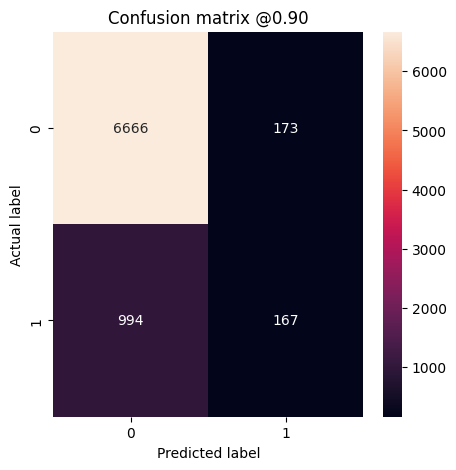

Legitimate TrueClass Detected (True Negatives):  6666
Legitimate TrueClass Incorrectly Detected (False Positives):  173
Fraudulent TrueClass Missed (False Negatives):  994
Fraudulent TrueClass Detected (True Positives):  167
Total FalseClass:  1161


In [95]:
plot_cm(y_valid, y_valid_predicted_one_class, 0.9)

#### 4.6.1 Final Model : Decision Boundary
- By tweaking the decision boundary we can get higher recall or precision. 
- The optimal decision boundary depends on the business use case. In some cases we want comparatively higher recall e.g telemarketing while in other cases i.e disease detection (hiv), we want comparatively higher precision. We do not want to classify a person as having HIV, when in fact he does not.
- However if we are on general looking for a balance between Sensitivity and Specificity. We can use Roc curves and the  geometric mean.
    

Best Threshold=0.1046157032251358, G-Mean=0.688478459096021


0.1046157

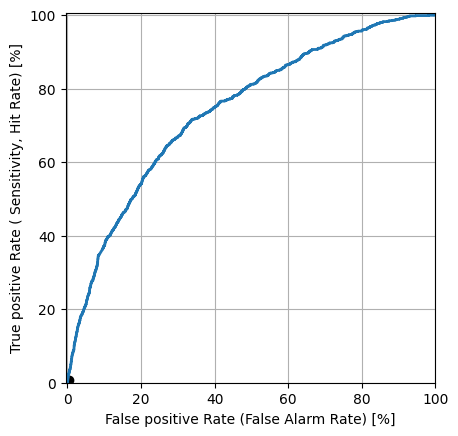

In [69]:
from numpy import sqrt, argmax

def get_best_threshold_with_best_balance_of_sensitivity_and_specificity(name, labels, predictions, **kwargs):
  fpr, tpr, thresholds = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fpr, 100*tpr, label=name, linewidth=2, **kwargs)  
  plt.xlabel('False positive Rate (False Alarm Rate) [%]')
  plt.ylabel('True positive Rate ( Sensitivity, Hit Rate) [%]')  
  plt.xlim([-0.5,100])
  plt.ylim([0,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

  # Geometirc Mean to get optimisd point that has right balance between sensitivity and specificity
  gmeans = sqrt(tpr * (1-fpr))
  # locate the index of the largest g-mean
  ix = argmax(gmeans)
  print(f'Best Threshold={thresholds[ix]}, G-Mean={gmeans[ix]}')
  plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
  return thresholds[ix]


get_best_threshold_with_best_balance_of_sensitivity_and_specificity("Validation Data", y_valid_np_arr, y_valid_predicted_one_class)

#### 4.6.2 Final Model DNN :  Write Prediction
- We will write DNN output for test file to csv now

Restoring model weights from the end of the best epoch: 267.
Epoch 317: early stopping
2/2 [==============================] - 0s 3ms/step
Output File Written at Data/nonglmresults.csv


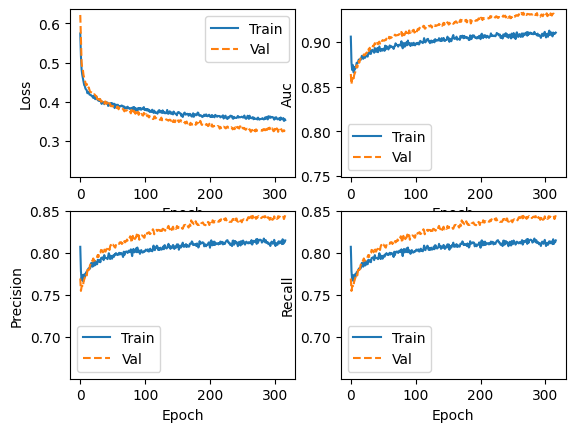

In [70]:
X_all_np_array = np.array(X_all)
y_all_np_array = np.array(y_all)
y_all_np_arr_cross_entropy = tf.one_hot(y_all_np_array, depth=2)

train_history_cross_entropy_all = model_dnn_cross_entropy.fit(
    X_all_np_array,
    y_all_np_arr_cross_entropy,
    validation_data=(X_valid_np_arr, y_valid_np_arr_cross_entropy),
    batch_size=8024,
    epochs=1000,
    callbacks=[early_stopping],
    class_weight=class_weight,
    verbose=0,
)
test_df_predicted_crossentropy = model_dnn_cross_entropy.predict(test_df, batch_size=8024)
test_df_predicted_one_class = tf.gather(test_df_predicted_crossentropy, [1], axis=1)
write_yes_probability_to_a_file(test_df_predicted_crossentropy, "Data/nonglmresults.csv")
print("Output File Written at Data/nonglmresults.csv")

plot_metrics(train_history_cross_entropy_all, metrics=["loss", "auc", "precision", "recall"])


## 5. Model Comparision : LogisticRegression vs DNN
- We will plot the predicitons from Logistic Regression and DNN and compare them

Text(0.5, 1.0, 'NN - Prediction on TestData')

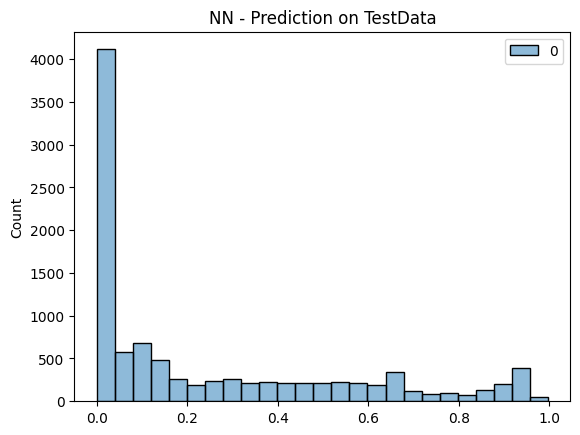

In [71]:
sns.histplot(test_df_predicted_one_class).set_title("NN - Prediction on TestData")

10000


Text(0.5, 1.0, 'Logistic Regression - Prediction TestData')

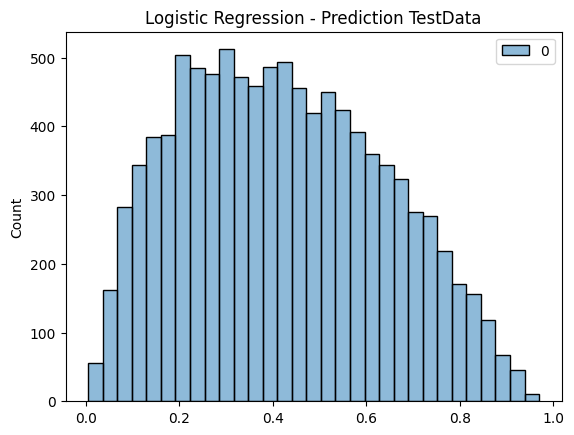

In [72]:
glmresults = pd.read_csv("Data/glmresults.csv", header=None)
print(len(glmresults))
sns.histplot(glmresults).set_title("Logistic Regression - Prediction TestData")


##  6. Modeling with StatsModel : Logistic Regression Explainable Models
- Logistic Regression from sklearn  is good for prediction  however it is barebone. It provides very few statistical information compared to statsmodel i.e it does not provied p-values for coeficients to tell us coeficient significance and also provided musch richer model statistical information. Hence we will  build a Logistic Regression model with statsmodel library and then use it for further explanation. It provides information i.e p-values for the coeficient, pseudo-R2 values.
- Hence for explainable model purpose, we will modeling with statsmodel with more descriptive statistical properties.

Ref: https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.Logit.fit.html




###  6.1 Further Pre-Processing : Multi-colinearity (df-1)
- Transform dummy variable into n-1 variables, because nth variable can be perfectly explained by 1,2,... n-1 variables 
- We will remove the nth variable and during interpretation we will use it as a reference variable to make the explanations.


In [73]:
import statsmodels.api as sm
from scipy import stats
from statsmodels.formula.api import logit
import cvxopt


def normalise_column_names(df):
    for col in list(df.columns):
        if col == "y":
            continue

        if "." in col or "-" in col or " " in col:
            # print('Replacing col ', col, col.replace(".","_").replace("-","_"))
            df.rename(columns={col: col.replace(".", "_").replace("-", "_").replace(" ", "_")}, inplace=True)
    return df


def get_df_n_formulae(df, columns, class_label="y"):
    df = df[columns]
    df = normalise_column_names(df)
    normalised_column_names = sorted(list(df.columns))

    if class_label in normalised_column_names:
        normalised_column_names.remove(class_label)

    return df, class_label + " ~ " + " + ".join(normalised_column_names)

# reference_columns_to_remove = ['education_illiterate', 'job_unemployed','month_dec', 'marital_single', 'day_of_week_fri', 'default_miss' ]
reference_columns_to_remove = [
        "x77_toyota",
        "x33_California",
        "x3_Mon",
        "x60_August",
        "x65_allstate"
]
base_explainable_cols = list(train_df.columns)
explainable_cols = list(set(base_explainable_cols) - set(reference_columns_to_remove))

explainable_data_df, explainable_formulae = get_df_n_formulae(train_df, explainable_cols, class_label="y")


logit_model_explainable_variables = logit(explainable_formulae, explainable_data_df).fit_regularized(
    maxiter=100, method="l1", trim_mode="size", size_trim_tol="auto", auto_trim_tol="auto"
)


lr = logit_model_explainable_variables
# marginal_effect = logit_model_explainable_variables.get_margeff()
# marginal_effect.summary()
logit_model_explainable_variables.summary2()




Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.3516956441452415
            Iterations: 406
            Function evaluations: 411
            Gradient evaluations: 406


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
===================================================================
Model:                Logit            Pseudo R-squared: 0.151     
Dependent Variable:   y                AIC:              28469.6515
Date:                 2023-02-20 18:14 BIC:              29905.2895
No. Observations:     40000            Log-Likelihood:   -14068.   
Df Model:             166              LL-Null:          -16563.   
Df Residuals:         39833            LLR p-value:      0.0000    
Converged:            1.0000           Scale:            1.0000    
No. Iterations:       406.0000                                     
-------------------------------------------------------------------
                    Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------
Intercept          -2.2017   0.1394 -15.7948 0.0000 -2.4749 -1.9285
x1                  0.0281   0.0223   1.2618 0.2070 -0.0156  0.0719
x10                 0.0051   0.0194   0.2608 0.7942 -0.0330  0.0431
x100                0.0728   0.0512   1.4229 0.1548 -0.0275  0.1730
x11                 0.1703   0.0404   4.2143 0.0000  0.0911  0.2496
x12                 0.0327   0.0768   0.4264 0.6698 -0.1177  0.1832
x13                 0.0670   0.0372   1.8013 0.0717 -0.0059  0.1398
x14                 0.0399   0.0241   1.6575 0.0974 -0.0073  0.0870
x15                -0.0326   0.0156  -2.0954 0.0361 -0.0631 -0.0021
x16                -0.0308   0.0206  -1.4979 0.1342 -0.0711  0.0095
x17                 0.0138   0.0406   0.3406 0.7334 -0.0658  0.0934
x18                -0.2305   0.0801  -2.8783 0.0040 -0.3875 -0.0735
x19                -0.1956   0.0207  -9.4281 0.0000 -0.2363 -0.1549
x2                  0.0814   0.0806   1.0098 0.3126 -0.0766  0.2393
x20                -0.1245   0.0539  -2.3102 0.0209 -0.2301 -0.0189
x21                 0.0206   0.0153   1.3534 0.1759 -0.0093  0.0505
x22                -0.0007   0.0194  -0.0342 0.9727 -0.0387  0.0374
x23                 0.0113   0.0176   0.6439 0.5196 -0.0231  0.0457
x24                 0.0050   0.0307   0.1622 0.8712 -0.0551  0.0651
x25                 0.0169   0.0215   0.7855 0.4321 -0.0253  0.0591
x26                -0.0024   0.0190  -0.1286 0.8977 -0.0396  0.0348
x27                 0.1197   0.0524   2.2872 0.0222  0.0171  0.2223
x28                -0.3225   0.0718  -4.4922 0.0000 -0.4632 -0.1818
x29                -0.0117   0.0145  -0.8069 0.4197 -0.0402  0.0168
x31                -0.5885   0.0594  -9.9099 0.0000 -0.7049 -0.4721
x32                 0.0069   0.0109   0.6338 0.5262 -0.0144  0.0282
x33_Alabama         0.0929   0.1391   0.6679 0.5042 -0.1798  0.3656
x33_Alaska          1.2433   0.1740   7.1464 0.0000  0.9023  1.5843
x33_Arizona         0.0500   0.1242   0.4023 0.6875 -0.1935  0.2934
x33_Arkansas        0.0527   0.1706   0.3092 0.7572 -0.2816  0.3871
x33_Colorado       -0.2413   0.1485  -1.6250 0.1042 -0.5324  0.0497
x33_Connecticut     0.2186   0.1459   1.4982 0.1341 -0.0674  0.5045
x33_DC              0.4507   0.2082   2.1654 0.0304  0.0428  0.8587
x33_Delaware       -0.2593   0.2514  -1.0313 0.3024 -0.7520  0.2335
x33_Florida         0.5450   0.0795   6.8516 0.0000  0.3891  0.7009
x33_Georgia         0.5682   0.1003   5.6676 0.0000  0.3717  0.7647
x33_Hawaii          0.1890   0.1753   1.0779 0.2811 -0.1546  0.5326
x33_Idaho           1.1944   0.1443   8.2752 0.0000  0.9115  1.4772
x33_Illinois        0.5594   0.0881   6.3506 0.0000  0.3868  0.7321
x33_Indiana         0.3378   0.1153   2.9292 0.0034  0.1118  0.5638
x33_Iowa            0.4386   0.1514   2.8972 0.0038  0.1419  0.7354
x33_Kansas          0.7806   0.1340   5.8271 0.0000  0.5180  1.0431
x33_Kentucky        0.4746   0.1304   3.6392 0.0003  0.2190  0.7302
x33_Louisiana       0.0534   0.1410   0.3786 0.7050 -0.2229  0.3296
x33_Maine           0.3706   0.1833   2.0216 0.0432  0.0113  0.7300
x33_Maryland        0.1058   0.130

### 6.2 LR Model Confusion Matrix : Diff Threshold

In [77]:
best_lr = logit_model_explainable_variables
print("Confusion Matrix across different threshold")
print(f"\nThreshold=0.5   \n{best_lr.pred_table(0.5)}")
print(f"\nThreshold=0.4   \n{best_lr.pred_table(0.4)}")
print(f"\nThreshold=0.3   \n{best_lr.pred_table(0.3)}")
print(f"\nThreshold=0.2   \n{best_lr.pred_table(0.2)}")
print(f"\nThreshold=0.1   \n{best_lr.pred_table(0.1)}")



Confusion Matrix across different threshold

Threshold=0.5   
[[33775.   422.]
 [ 5167.   636.]]

Threshold=0.4   
[[33109.  1088.]
 [ 4586.  1217.]]

Threshold=0.3   
[[31428.  2769.]
 [ 3722.  2081.]]

Threshold=0.2   
[[27623.  6574.]
 [ 2487.  3316.]]

Threshold=0.1   
[[18480. 15717.]
 [  997.  4806.]]


### 6.3 Future To Dos: Logistic Regression
- Variable slicing for coeficients with larger p-value
- Add in interaction terms